In [1]:
from torchvision import transforms
import torch
from torch import nn
import torch.optim as optim
import argparse
import torch.optim.lr_scheduler as lr_scheduler 
from efficientnet_pytorch import EfficientNet
from torch.utils.data import Dataset
import os
import numpy as np
import pandas as pd
from PIL import Image
from sklearn import preprocessing
import time
import matplotlib.pyplot as plt
import pickle
from sklearn.metrics.cluster import adjusted_rand_score
from sklearn.metrics import accuracy_score
import warnings
from timeit import default_timer as timer
warnings.simplefilter('ignore')

In [2]:
trainy = pd.read_csv("./pretrained_0/trainy_pre.csv")
valy = pd.read_csv("./pretrained_0/valy_pre.csv")
#labels to categorical matrix
le = preprocessing.LabelEncoder()
le.fit(trainy['celltype_l2'])
classes = len(np.unique(trainy['celltype_l2']))
with open("./pretrained_0/label_encoder_pre.obj","wb") as f:
   pickle.dump(le, f)

y_train = pd.DataFrame(le.transform(trainy['celltype_l2']))
y_val = pd.DataFrame(le.transform(valy['celltype_l2']))
np.save('./pretrained_0/train_pre_label.npy', y_train)
np.save('./pretrained_0/val_pre_label.npy', y_val)

In [3]:
class LabelSmoothingCrossEntropy(torch.nn.Module):
    def __init__(self, eps=0.1, reduction='mean'):
        super(LabelSmoothingCrossEntropy, self).__init__()
        self.eps = eps
        self.reduction = reduction
    def forward(self, output, target):
        c = output.size()[-1]
        log_preds = torch.nn.functional.log_softmax(output, dim=-1)
        if self.reduction=='sum':
            loss = -log_preds.sum()
        else:
            loss = -log_preds.sum(dim=-1)
            if self.reduction=='mean':
                loss = loss.mean()
        return loss*self.eps/c + (1-self.eps) * torch.nn.functional.nll_loss(log_preds, target, reduction=self.reduction)


In [4]:
class EarlyStopping:
    def __init__(self, patience=10, verbose=False, path='./pretrained_0/checkpoint_model_pre.pth'):
        self.patience = patience    
        self.verbose = verbose      
        self.counter = 0            
        self.best_score = None      
        self.early_stop = False     
        self.val_acc_max = 0   
        self.path = path             
    def __call__(self, val_acc, model):
        score = val_acc
        if self.best_score is None: 
            self.best_score = score 
            self.checkpoint(val_acc, model)
        elif score < self.best_score: 
            self.counter += 1 
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience: 
                self.early_stop = True
        else:
            self.best_score = score
            self.checkpoint(val_acc, model)
            self.counter = 0  
    def checkpoint(self, val_acc, model):
        if self.verbose:  
            print(f'Validation accuracy increased ({self.val_acc_max:.6f} --> {val_acc:.6f}).  Saving model ...')
        torch.save(model.state_dict(), self.path)  
        self.val_acc_max = val_acc  

In [5]:
class MyDataset(Dataset):
    def __init__(self, img, label):
        self.img = np.load(img)
        self.label = torch.tensor(np.load(label))
        self.transforms = transforms.Compose([transforms.ToTensor(), ])
    def __getitem__(self, index):
        img = self.img[index, :, :, :] 
        img = np.squeeze(img)
        img = Image.fromarray(np.uint8(img))
        img = self.transforms(img)
        label = self.label[index]
        label = np.squeeze(label)
        return img,label
    def __len__(self):
        return self.img.shape[0]

In [6]:
def train_net(pre_epoch, EPOCH, early_patience, training_loader, validation_loader, net, optimizer, scheduler, criteria, device):
    with open("./pretrained_0/acc.txt", "w") as f:
        with open("./pretrained_0/log.txt", "w")as f2:
            start = time.time()
            earlystopping = EarlyStopping(patience=early_patience, verbose=True)
            losses_train = []
            accs_train = []
            losses_val = []
            accs_val = []
            best_acc = 0
            total_poches = 0
            for epoch in range(pre_epoch, EPOCH):
                print('\nEpoch: %d' % (epoch + 1))
                since = time.time()
                net.train()
                sum_loss = 0.0
                correct = 0
                total = 0
                for i, data in enumerate(training_loader):
                    length = len(training_loader)
                    input, target = data
                    input, target = input.to(device), target.to(device)
                    optimizer.zero_grad()
                    # forward + backward
                    output = net(input)
                    loss = criteria(output, target)
                    loss.backward()
                    optimizer.step()
                    sum_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    total += target.size(0)
                    correct += predicted.eq(target.data).cpu().sum()
                    loss_train = sum_loss / (i + 1)
                    acc_train = 100. * float(correct) / float(total)
                    print('[epoch:%d, iter:%d] Loss: %.03f | Accuracy: %.3f%% '
                        % (epoch + 1, (i + 1 + epoch * length), loss_train, acc_train))
                    f2.write('%03d  %05d |Loss: %.03f | Accuracy: %.3f%% '
                        % (epoch + 1, (i + 1 + epoch * length), loss_train, acc_train))
                    f2.write('\n')
                    f2.flush()
                acc_train = 100. * float(correct) / float(total)
                accs_train.append(acc_train)
                losses_train.append(loss_train)
                print("Waiting Test!")
                with torch.no_grad():
                    sum_loss_val = 0
                    correct = 0
                    total = 0
                    loss_val = 0
                    for i, data in enumerate(validation_loader):
                        net.eval()
                        images, labels = data
                        images, labels = images.to(device), labels.to(device)
                        outputs = net(images)
                        loss = criteria(outputs, labels)
                        sum_loss_val += loss.item()
                        _, predicted = torch.max(outputs.data, 1)
                        total += labels.size(0)
                        correct += predicted.eq(labels.data).cpu().sum()
                        loss_val = sum_loss_val / (i + 1)
                    acc_val = 100. * float(correct) / float(total)
                    losses_val.append(loss_val)
                    accs_val.append(acc_val)
                    print("EPOCH=%03d, Loss: %.03f, Accuracy= %.3f%%" % (epoch + 1, loss_val ,acc_val))
                    scheduler.step(acc_val)
                    if acc_val > best_acc:
                        f3 = open("./pretrained_0/best_acc.txt", "w")
                        f3.write("EPOCH=%d,best_acc= %.3f%%" % (epoch + 1, acc_val))
                        f3.close()
                        best_acc = acc_val
                    time_elapsed = time.time() - since
                    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
                    earlystopping(acc_val, net)
                    if earlystopping.early_stop: 
                        print("Early Stopping!")
                        total_poches = epoch + 1
                        break
            print("Training Finished, TotalEPOCH=%d" % total_poches)
            time_total = time.time() - start
            print('The whole training process complete in {:.0f}m {:.0f}s'.format(time_total // 60, time_total % 60))
    return losses_train, accs_train, losses_val, accs_val

In [7]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
batch_size = 128
net = EfficientNet.from_pretrained('efficientnet-b3', num_classes=classes)
net._fc.out_features = classes
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    net = nn.DataParallel(net)

torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.get_device_name()

Loaded pretrained weights for efficientnet-b3


'Quadro RTX 8000'

In [8]:
net.to(device)
net = net.to(device)

In [9]:
train = MyDataset("./pretrained_0/train_pre.npy", "./pretrained_0/train_pre_label.npy")
training_loader = torch.utils.data.DataLoader(train, batch_size=batch_size, shuffle=True)
val = MyDataset("./pretrained_0/val_pre.npy", "./pretrained_0/val_pre_label.npy")
validation_loader = torch.utils.data.DataLoader(val, batch_size=batch_size, shuffle=True)

In [10]:
LR = 3e-4 
# optimizer
params_to_update = net.parameters()
optimizer = optim.NAdam(params_to_update, lr=LR, betas=(0.9, 0.999), eps=1e-9)
# scheduler
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.7, patience=3, verbose=True)
criteria = LabelSmoothingCrossEntropy(0.1)

In [11]:
start = timer()

In [12]:
losses_train, accs_train, losses_val, accs_val = train_net(pre_epoch=0,
                                                           EPOCH = 50,
                                                           early_patience = 20,
                                                           training_loader=training_loader,
                                                           validation_loader = validation_loader,
                                                           net=net,
                                                           optimizer=optimizer,
                                                           scheduler=scheduler,
                                                           criteria=criteria,
                                                           device=device
                                                        )


Epoch: 1
[epoch:1, iter:1] Loss: 3.456 | Accuracy: 3.906% 
[epoch:1, iter:2] Loss: 3.415 | Accuracy: 8.203% 
[epoch:1, iter:3] Loss: 3.365 | Accuracy: 13.802% 
[epoch:1, iter:4] Loss: 3.325 | Accuracy: 16.797% 
[epoch:1, iter:5] Loss: 3.273 | Accuracy: 20.312% 
[epoch:1, iter:6] Loss: 3.217 | Accuracy: 22.786% 
[epoch:1, iter:7] Loss: 3.160 | Accuracy: 25.335% 
[epoch:1, iter:8] Loss: 3.104 | Accuracy: 26.758% 
[epoch:1, iter:9] Loss: 3.054 | Accuracy: 27.691% 
[epoch:1, iter:10] Loss: 3.035 | Accuracy: 27.656% 
[epoch:1, iter:11] Loss: 3.001 | Accuracy: 27.983% 
[epoch:1, iter:12] Loss: 2.969 | Accuracy: 28.320% 
[epoch:1, iter:13] Loss: 2.946 | Accuracy: 28.425% 
[epoch:1, iter:14] Loss: 2.918 | Accuracy: 28.795% 
[epoch:1, iter:15] Loss: 2.884 | Accuracy: 29.531% 
[epoch:1, iter:16] Loss: 2.854 | Accuracy: 30.225% 
[epoch:1, iter:17] Loss: 2.826 | Accuracy: 30.607% 
[epoch:1, iter:18] Loss: 2.795 | Accuracy: 31.380% 
[epoch:1, iter:19] Loss: 2.779 | Accuracy: 31.661% 
[epoch:1, ite

[epoch:1, iter:158] Loss: 2.156 | Accuracy: 41.273% 
[epoch:1, iter:159] Loss: 2.154 | Accuracy: 41.303% 
[epoch:1, iter:160] Loss: 2.154 | Accuracy: 41.318% 
[epoch:1, iter:161] Loss: 2.152 | Accuracy: 41.353% 
[epoch:1, iter:162] Loss: 2.151 | Accuracy: 41.382% 
[epoch:1, iter:163] Loss: 2.150 | Accuracy: 41.421% 
[epoch:1, iter:164] Loss: 2.148 | Accuracy: 41.478% 
[epoch:1, iter:165] Loss: 2.147 | Accuracy: 41.515% 
[epoch:1, iter:166] Loss: 2.145 | Accuracy: 41.524% 
[epoch:1, iter:167] Loss: 2.144 | Accuracy: 41.556% 
[epoch:1, iter:168] Loss: 2.142 | Accuracy: 41.592% 
[epoch:1, iter:169] Loss: 2.142 | Accuracy: 41.582% 
[epoch:1, iter:170] Loss: 2.141 | Accuracy: 41.562% 
[epoch:1, iter:171] Loss: 2.140 | Accuracy: 41.548% 
[epoch:1, iter:172] Loss: 2.139 | Accuracy: 41.583% 
[epoch:1, iter:173] Loss: 2.137 | Accuracy: 41.591% 
[epoch:1, iter:174] Loss: 2.136 | Accuracy: 41.590% 
[epoch:1, iter:175] Loss: 2.136 | Accuracy: 41.594% 
[epoch:1, iter:176] Loss: 2.135 | Accuracy: 41

[epoch:1, iter:313] Loss: 2.021 | Accuracy: 43.163% 
[epoch:1, iter:314] Loss: 2.021 | Accuracy: 43.163% 
[epoch:1, iter:315] Loss: 2.021 | Accuracy: 43.152% 
[epoch:1, iter:316] Loss: 2.020 | Accuracy: 43.169% 
[epoch:1, iter:317] Loss: 2.019 | Accuracy: 43.176% 
[epoch:1, iter:318] Loss: 2.019 | Accuracy: 43.180% 
[epoch:1, iter:319] Loss: 2.019 | Accuracy: 43.174% 
[epoch:1, iter:320] Loss: 2.018 | Accuracy: 43.186% 
[epoch:1, iter:321] Loss: 2.018 | Accuracy: 43.183% 
[epoch:1, iter:322] Loss: 2.017 | Accuracy: 43.216% 
[epoch:1, iter:323] Loss: 2.017 | Accuracy: 43.223% 
[epoch:1, iter:324] Loss: 2.016 | Accuracy: 43.217% 
[epoch:1, iter:325] Loss: 2.016 | Accuracy: 43.245% 
[epoch:1, iter:326] Loss: 2.015 | Accuracy: 43.264% 
[epoch:1, iter:327] Loss: 2.015 | Accuracy: 43.251% 
[epoch:1, iter:328] Loss: 2.015 | Accuracy: 43.262% 
[epoch:1, iter:329] Loss: 2.014 | Accuracy: 43.270% 
[epoch:1, iter:330] Loss: 2.014 | Accuracy: 43.277% 
[epoch:1, iter:331] Loss: 2.013 | Accuracy: 43

[epoch:1, iter:468] Loss: 1.956 | Accuracy: 44.318% 
[epoch:1, iter:469] Loss: 1.956 | Accuracy: 44.318% 
[epoch:1, iter:470] Loss: 1.956 | Accuracy: 44.322% 
[epoch:1, iter:471] Loss: 1.955 | Accuracy: 44.344% 
[epoch:1, iter:472] Loss: 1.955 | Accuracy: 44.351% 
[epoch:1, iter:473] Loss: 1.954 | Accuracy: 44.358% 
[epoch:1, iter:474] Loss: 1.954 | Accuracy: 44.381% 
[epoch:1, iter:475] Loss: 1.954 | Accuracy: 44.383% 
[epoch:1, iter:476] Loss: 1.954 | Accuracy: 44.388% 
[epoch:1, iter:477] Loss: 1.953 | Accuracy: 44.402% 
[epoch:1, iter:478] Loss: 1.953 | Accuracy: 44.415% 
[epoch:1, iter:479] Loss: 1.952 | Accuracy: 44.422% 
[epoch:1, iter:480] Loss: 1.952 | Accuracy: 44.443% 
[epoch:1, iter:481] Loss: 1.952 | Accuracy: 44.439% 
[epoch:1, iter:482] Loss: 1.952 | Accuracy: 44.440% 
[epoch:1, iter:483] Loss: 1.952 | Accuracy: 44.437% 
[epoch:1, iter:484] Loss: 1.951 | Accuracy: 44.454% 
[epoch:1, iter:485] Loss: 1.951 | Accuracy: 44.465% 
[epoch:1, iter:486] Loss: 1.951 | Accuracy: 44

[epoch:1, iter:623] Loss: 1.918 | Accuracy: 45.149% 
[epoch:1, iter:624] Loss: 1.918 | Accuracy: 45.146% 
[epoch:1, iter:625] Loss: 1.918 | Accuracy: 45.140% 
[epoch:1, iter:626] Loss: 1.918 | Accuracy: 45.133% 
[epoch:1, iter:627] Loss: 1.918 | Accuracy: 45.131% 
[epoch:1, iter:628] Loss: 1.918 | Accuracy: 45.136% 
[epoch:1, iter:629] Loss: 1.918 | Accuracy: 45.122% 
[epoch:1, iter:630] Loss: 1.917 | Accuracy: 45.120% 
[epoch:1, iter:631] Loss: 1.917 | Accuracy: 45.122% 
[epoch:1, iter:632] Loss: 1.917 | Accuracy: 45.127% 
[epoch:1, iter:633] Loss: 1.917 | Accuracy: 45.124% 
[epoch:1, iter:634] Loss: 1.917 | Accuracy: 45.123% 
[epoch:1, iter:635] Loss: 1.917 | Accuracy: 45.124% 
[epoch:1, iter:636] Loss: 1.916 | Accuracy: 45.128% 
[epoch:1, iter:637] Loss: 1.916 | Accuracy: 45.144% 
[epoch:1, iter:638] Loss: 1.916 | Accuracy: 45.161% 
[epoch:1, iter:639] Loss: 1.915 | Accuracy: 45.167% 
[epoch:1, iter:640] Loss: 1.915 | Accuracy: 45.164% 
[epoch:1, iter:641] Loss: 1.915 | Accuracy: 45

[epoch:1, iter:778] Loss: 1.896 | Accuracy: 45.526% 
[epoch:1, iter:779] Loss: 1.896 | Accuracy: 45.530% 
[epoch:1, iter:780] Loss: 1.896 | Accuracy: 45.531% 
[epoch:1, iter:781] Loss: 1.896 | Accuracy: 45.533% 
[epoch:1, iter:782] Loss: 1.896 | Accuracy: 45.533% 
[epoch:1, iter:783] Loss: 1.896 | Accuracy: 45.536% 
[epoch:1, iter:784] Loss: 1.896 | Accuracy: 45.538% 
[epoch:1, iter:785] Loss: 1.895 | Accuracy: 45.544% 
[epoch:1, iter:786] Loss: 1.896 | Accuracy: 45.539% 
[epoch:1, iter:787] Loss: 1.895 | Accuracy: 45.543% 
[epoch:1, iter:788] Loss: 1.895 | Accuracy: 45.549% 
[epoch:1, iter:789] Loss: 1.895 | Accuracy: 45.556% 
[epoch:1, iter:790] Loss: 1.895 | Accuracy: 45.551% 
[epoch:1, iter:791] Loss: 1.895 | Accuracy: 45.558% 
[epoch:1, iter:792] Loss: 1.895 | Accuracy: 45.565% 
[epoch:1, iter:793] Loss: 1.895 | Accuracy: 45.564% 
[epoch:1, iter:794] Loss: 1.895 | Accuracy: 45.558% 
[epoch:1, iter:795] Loss: 1.894 | Accuracy: 45.557% 
[epoch:1, iter:796] Loss: 1.894 | Accuracy: 45

[epoch:1, iter:933] Loss: 1.879 | Accuracy: 45.875% 
[epoch:1, iter:934] Loss: 1.879 | Accuracy: 45.880% 
[epoch:1, iter:935] Loss: 1.879 | Accuracy: 45.878% 
[epoch:1, iter:936] Loss: 1.879 | Accuracy: 45.876% 
[epoch:1, iter:937] Loss: 1.879 | Accuracy: 45.880% 
[epoch:1, iter:938] Loss: 1.879 | Accuracy: 45.886% 
[epoch:1, iter:939] Loss: 1.879 | Accuracy: 45.877% 
[epoch:1, iter:940] Loss: 1.879 | Accuracy: 45.874% 
[epoch:1, iter:941] Loss: 1.879 | Accuracy: 45.876% 
[epoch:1, iter:942] Loss: 1.879 | Accuracy: 45.876% 
[epoch:1, iter:943] Loss: 1.879 | Accuracy: 45.878% 
[epoch:1, iter:944] Loss: 1.879 | Accuracy: 45.881% 
[epoch:1, iter:945] Loss: 1.879 | Accuracy: 45.880% 
[epoch:1, iter:946] Loss: 1.878 | Accuracy: 45.882% 
[epoch:1, iter:947] Loss: 1.879 | Accuracy: 45.878% 
[epoch:1, iter:948] Loss: 1.878 | Accuracy: 45.879% 
[epoch:1, iter:949] Loss: 1.878 | Accuracy: 45.881% 
[epoch:1, iter:950] Loss: 1.878 | Accuracy: 45.886% 
[epoch:1, iter:951] Loss: 1.878 | Accuracy: 45

[epoch:1, iter:1086] Loss: 1.866 | Accuracy: 46.108% 
[epoch:1, iter:1087] Loss: 1.866 | Accuracy: 46.104% 
[epoch:1, iter:1088] Loss: 1.866 | Accuracy: 46.111% 
[epoch:1, iter:1089] Loss: 1.866 | Accuracy: 46.108% 
[epoch:1, iter:1090] Loss: 1.866 | Accuracy: 46.107% 
[epoch:1, iter:1091] Loss: 1.866 | Accuracy: 46.113% 
[epoch:1, iter:1092] Loss: 1.866 | Accuracy: 46.109% 
[epoch:1, iter:1093] Loss: 1.866 | Accuracy: 46.109% 
[epoch:1, iter:1094] Loss: 1.866 | Accuracy: 46.106% 
[epoch:1, iter:1095] Loss: 1.865 | Accuracy: 46.099% 
[epoch:1, iter:1096] Loss: 1.865 | Accuracy: 46.106% 
[epoch:1, iter:1097] Loss: 1.865 | Accuracy: 46.102% 
[epoch:1, iter:1098] Loss: 1.865 | Accuracy: 46.107% 
[epoch:1, iter:1099] Loss: 1.865 | Accuracy: 46.112% 
[epoch:1, iter:1100] Loss: 1.865 | Accuracy: 46.109% 
[epoch:1, iter:1101] Loss: 1.865 | Accuracy: 46.104% 
[epoch:1, iter:1102] Loss: 1.865 | Accuracy: 46.109% 
[epoch:1, iter:1103] Loss: 1.865 | Accuracy: 46.108% 
[epoch:1, iter:1104] Loss: 1

[epoch:2, iter:1235] Loss: 1.794 | Accuracy: 47.483% 
[epoch:2, iter:1236] Loss: 1.794 | Accuracy: 47.500% 
[epoch:2, iter:1237] Loss: 1.794 | Accuracy: 47.509% 
[epoch:2, iter:1238] Loss: 1.796 | Accuracy: 47.449% 
[epoch:2, iter:1239] Loss: 1.796 | Accuracy: 47.474% 
[epoch:2, iter:1240] Loss: 1.796 | Accuracy: 47.529% 
[epoch:2, iter:1241] Loss: 1.797 | Accuracy: 47.507% 
[epoch:2, iter:1242] Loss: 1.796 | Accuracy: 47.560% 
[epoch:2, iter:1243] Loss: 1.795 | Accuracy: 47.649% 
[epoch:2, iter:1244] Loss: 1.794 | Accuracy: 47.743% 
[epoch:2, iter:1245] Loss: 1.793 | Accuracy: 47.828% 
[epoch:2, iter:1246] Loss: 1.793 | Accuracy: 47.812% 
[epoch:2, iter:1247] Loss: 1.794 | Accuracy: 47.790% 
[epoch:2, iter:1248] Loss: 1.795 | Accuracy: 47.761% 
[epoch:2, iter:1249] Loss: 1.795 | Accuracy: 47.753% 
[epoch:2, iter:1250] Loss: 1.794 | Accuracy: 47.780% 
[epoch:2, iter:1251] Loss: 1.793 | Accuracy: 47.840% 
[epoch:2, iter:1252] Loss: 1.792 | Accuracy: 47.892% 
[epoch:2, iter:1253] Loss: 1

[epoch:2, iter:1387] Loss: 1.795 | Accuracy: 47.719% 
[epoch:2, iter:1388] Loss: 1.795 | Accuracy: 47.706% 
[epoch:2, iter:1389] Loss: 1.795 | Accuracy: 47.749% 
[epoch:2, iter:1390] Loss: 1.795 | Accuracy: 47.752% 
[epoch:2, iter:1391] Loss: 1.794 | Accuracy: 47.773% 
[epoch:2, iter:1392] Loss: 1.794 | Accuracy: 47.781% 
[epoch:2, iter:1393] Loss: 1.794 | Accuracy: 47.787% 
[epoch:2, iter:1394] Loss: 1.795 | Accuracy: 47.756% 
[epoch:2, iter:1395] Loss: 1.795 | Accuracy: 47.762% 
[epoch:2, iter:1396] Loss: 1.794 | Accuracy: 47.776% 
[epoch:2, iter:1397] Loss: 1.795 | Accuracy: 47.755% 
[epoch:2, iter:1398] Loss: 1.795 | Accuracy: 47.728% 
[epoch:2, iter:1399] Loss: 1.795 | Accuracy: 47.710% 
[epoch:2, iter:1400] Loss: 1.795 | Accuracy: 47.715% 
[epoch:2, iter:1401] Loss: 1.794 | Accuracy: 47.695% 
[epoch:2, iter:1402] Loss: 1.795 | Accuracy: 47.668% 
[epoch:2, iter:1403] Loss: 1.794 | Accuracy: 47.688% 
[epoch:2, iter:1404] Loss: 1.794 | Accuracy: 47.680% 
[epoch:2, iter:1405] Loss: 1

[epoch:2, iter:1539] Loss: 1.791 | Accuracy: 47.883% 
[epoch:2, iter:1540] Loss: 1.791 | Accuracy: 47.881% 
[epoch:2, iter:1541] Loss: 1.791 | Accuracy: 47.867% 
[epoch:2, iter:1542] Loss: 1.791 | Accuracy: 47.870% 
[epoch:2, iter:1543] Loss: 1.791 | Accuracy: 47.858% 
[epoch:2, iter:1544] Loss: 1.791 | Accuracy: 47.852% 
[epoch:2, iter:1545] Loss: 1.790 | Accuracy: 47.857% 
[epoch:2, iter:1546] Loss: 1.791 | Accuracy: 47.845% 
[epoch:2, iter:1547] Loss: 1.791 | Accuracy: 47.848% 
[epoch:2, iter:1548] Loss: 1.791 | Accuracy: 47.855% 
[epoch:2, iter:1549] Loss: 1.790 | Accuracy: 47.857% 
[epoch:2, iter:1550] Loss: 1.790 | Accuracy: 47.854% 
[epoch:2, iter:1551] Loss: 1.790 | Accuracy: 47.858% 
[epoch:2, iter:1552] Loss: 1.790 | Accuracy: 47.855% 
[epoch:2, iter:1553] Loss: 1.790 | Accuracy: 47.836% 
[epoch:2, iter:1554] Loss: 1.790 | Accuracy: 47.849% 
[epoch:2, iter:1555] Loss: 1.790 | Accuracy: 47.850% 
[epoch:2, iter:1556] Loss: 1.789 | Accuracy: 47.842% 
[epoch:2, iter:1557] Loss: 1

[epoch:2, iter:1691] Loss: 1.788 | Accuracy: 47.967% 
[epoch:2, iter:1692] Loss: 1.788 | Accuracy: 47.975% 
[epoch:2, iter:1693] Loss: 1.788 | Accuracy: 47.976% 
[epoch:2, iter:1694] Loss: 1.788 | Accuracy: 47.957% 
[epoch:2, iter:1695] Loss: 1.788 | Accuracy: 47.951% 
[epoch:2, iter:1696] Loss: 1.788 | Accuracy: 47.960% 
[epoch:2, iter:1697] Loss: 1.788 | Accuracy: 47.967% 
[epoch:2, iter:1698] Loss: 1.788 | Accuracy: 47.968% 
[epoch:2, iter:1699] Loss: 1.788 | Accuracy: 47.974% 
[epoch:2, iter:1700] Loss: 1.788 | Accuracy: 47.975% 
[epoch:2, iter:1701] Loss: 1.788 | Accuracy: 47.969% 
[epoch:2, iter:1702] Loss: 1.788 | Accuracy: 47.960% 
[epoch:2, iter:1703] Loss: 1.788 | Accuracy: 47.965% 
[epoch:2, iter:1704] Loss: 1.787 | Accuracy: 47.970% 
[epoch:2, iter:1705] Loss: 1.788 | Accuracy: 47.965% 
[epoch:2, iter:1706] Loss: 1.788 | Accuracy: 47.970% 
[epoch:2, iter:1707] Loss: 1.788 | Accuracy: 47.968% 
[epoch:2, iter:1708] Loss: 1.787 | Accuracy: 47.969% 
[epoch:2, iter:1709] Loss: 1

[epoch:2, iter:1843] Loss: 1.788 | Accuracy: 47.883% 
[epoch:2, iter:1844] Loss: 1.788 | Accuracy: 47.892% 
[epoch:2, iter:1845] Loss: 1.788 | Accuracy: 47.894% 
[epoch:2, iter:1846] Loss: 1.788 | Accuracy: 47.894% 
[epoch:2, iter:1847] Loss: 1.788 | Accuracy: 47.900% 
[epoch:2, iter:1848] Loss: 1.788 | Accuracy: 47.895% 
[epoch:2, iter:1849] Loss: 1.787 | Accuracy: 47.906% 
[epoch:2, iter:1850] Loss: 1.788 | Accuracy: 47.905% 
[epoch:2, iter:1851] Loss: 1.787 | Accuracy: 47.911% 
[epoch:2, iter:1852] Loss: 1.788 | Accuracy: 47.912% 
[epoch:2, iter:1853] Loss: 1.787 | Accuracy: 47.909% 
[epoch:2, iter:1854] Loss: 1.787 | Accuracy: 47.912% 
[epoch:2, iter:1855] Loss: 1.787 | Accuracy: 47.909% 
[epoch:2, iter:1856] Loss: 1.787 | Accuracy: 47.910% 
[epoch:2, iter:1857] Loss: 1.787 | Accuracy: 47.907% 
[epoch:2, iter:1858] Loss: 1.787 | Accuracy: 47.904% 
[epoch:2, iter:1859] Loss: 1.787 | Accuracy: 47.911% 
[epoch:2, iter:1860] Loss: 1.787 | Accuracy: 47.910% 
[epoch:2, iter:1861] Loss: 1

[epoch:2, iter:1995] Loss: 1.788 | Accuracy: 47.779% 
[epoch:2, iter:1996] Loss: 1.788 | Accuracy: 47.778% 
[epoch:2, iter:1997] Loss: 1.788 | Accuracy: 47.771% 
[epoch:2, iter:1998] Loss: 1.788 | Accuracy: 47.780% 
[epoch:2, iter:1999] Loss: 1.788 | Accuracy: 47.778% 
[epoch:2, iter:2000] Loss: 1.788 | Accuracy: 47.761% 
[epoch:2, iter:2001] Loss: 1.788 | Accuracy: 47.758% 
[epoch:2, iter:2002] Loss: 1.788 | Accuracy: 47.770% 
[epoch:2, iter:2003] Loss: 1.788 | Accuracy: 47.770% 
[epoch:2, iter:2004] Loss: 1.788 | Accuracy: 47.761% 
[epoch:2, iter:2005] Loss: 1.788 | Accuracy: 47.761% 
[epoch:2, iter:2006] Loss: 1.788 | Accuracy: 47.756% 
[epoch:2, iter:2007] Loss: 1.788 | Accuracy: 47.767% 
[epoch:2, iter:2008] Loss: 1.788 | Accuracy: 47.762% 
[epoch:2, iter:2009] Loss: 1.788 | Accuracy: 47.758% 
[epoch:2, iter:2010] Loss: 1.788 | Accuracy: 47.752% 
[epoch:2, iter:2011] Loss: 1.788 | Accuracy: 47.751% 
[epoch:2, iter:2012] Loss: 1.788 | Accuracy: 47.755% 
[epoch:2, iter:2013] Loss: 1

[epoch:2, iter:2147] Loss: 1.785 | Accuracy: 47.805% 
[epoch:2, iter:2148] Loss: 1.786 | Accuracy: 47.798% 
[epoch:2, iter:2149] Loss: 1.786 | Accuracy: 47.794% 
[epoch:2, iter:2150] Loss: 1.786 | Accuracy: 47.786% 
[epoch:2, iter:2151] Loss: 1.786 | Accuracy: 47.785% 
[epoch:2, iter:2152] Loss: 1.786 | Accuracy: 47.778% 
[epoch:2, iter:2153] Loss: 1.786 | Accuracy: 47.788% 
[epoch:2, iter:2154] Loss: 1.786 | Accuracy: 47.781% 
[epoch:2, iter:2155] Loss: 1.786 | Accuracy: 47.784% 
[epoch:2, iter:2156] Loss: 1.786 | Accuracy: 47.785% 
[epoch:2, iter:2157] Loss: 1.786 | Accuracy: 47.781% 
[epoch:2, iter:2158] Loss: 1.786 | Accuracy: 47.779% 
[epoch:2, iter:2159] Loss: 1.786 | Accuracy: 47.781% 
[epoch:2, iter:2160] Loss: 1.786 | Accuracy: 47.782% 
[epoch:2, iter:2161] Loss: 1.786 | Accuracy: 47.789% 
[epoch:2, iter:2162] Loss: 1.786 | Accuracy: 47.790% 
[epoch:2, iter:2163] Loss: 1.786 | Accuracy: 47.795% 
[epoch:2, iter:2164] Loss: 1.786 | Accuracy: 47.795% 
[epoch:2, iter:2165] Loss: 1

[epoch:3, iter:2296] Loss: 1.784 | Accuracy: 47.559% 
[epoch:3, iter:2297] Loss: 1.786 | Accuracy: 47.500% 
[epoch:3, iter:2298] Loss: 1.789 | Accuracy: 47.416% 
[epoch:3, iter:2299] Loss: 1.788 | Accuracy: 47.396% 
[epoch:3, iter:2300] Loss: 1.787 | Accuracy: 47.461% 
[epoch:3, iter:2301] Loss: 1.792 | Accuracy: 47.333% 
[epoch:3, iter:2302] Loss: 1.791 | Accuracy: 47.318% 
[epoch:3, iter:2303] Loss: 1.790 | Accuracy: 47.429% 
[epoch:3, iter:2304] Loss: 1.791 | Accuracy: 47.388% 
[epoch:3, iter:2305] Loss: 1.789 | Accuracy: 47.491% 
[epoch:3, iter:2306] Loss: 1.788 | Accuracy: 47.495% 
[epoch:3, iter:2307] Loss: 1.789 | Accuracy: 47.411% 
[epoch:3, iter:2308] Loss: 1.791 | Accuracy: 47.374% 
[epoch:3, iter:2309] Loss: 1.795 | Accuracy: 47.255% 
[epoch:3, iter:2310] Loss: 1.791 | Accuracy: 47.307% 
[epoch:3, iter:2311] Loss: 1.790 | Accuracy: 47.376% 
[epoch:3, iter:2312] Loss: 1.788 | Accuracy: 47.344% 
[epoch:3, iter:2313] Loss: 1.789 | Accuracy: 47.409% 
[epoch:3, iter:2314] Loss: 1

[epoch:3, iter:2448] Loss: 1.780 | Accuracy: 48.380% 
[epoch:3, iter:2449] Loss: 1.780 | Accuracy: 48.385% 
[epoch:3, iter:2450] Loss: 1.780 | Accuracy: 48.394% 
[epoch:3, iter:2451] Loss: 1.780 | Accuracy: 48.372% 
[epoch:3, iter:2452] Loss: 1.781 | Accuracy: 48.346% 
[epoch:3, iter:2453] Loss: 1.781 | Accuracy: 48.334% 
[epoch:3, iter:2454] Loss: 1.780 | Accuracy: 48.347% 
[epoch:3, iter:2455] Loss: 1.781 | Accuracy: 48.327% 
[epoch:3, iter:2456] Loss: 1.782 | Accuracy: 48.289% 
[epoch:3, iter:2457] Loss: 1.781 | Accuracy: 48.319% 
[epoch:3, iter:2458] Loss: 1.781 | Accuracy: 48.349% 
[epoch:3, iter:2459] Loss: 1.781 | Accuracy: 48.341% 
[epoch:3, iter:2460] Loss: 1.782 | Accuracy: 48.317% 
[epoch:3, iter:2461] Loss: 1.782 | Accuracy: 48.309% 
[epoch:3, iter:2462] Loss: 1.783 | Accuracy: 48.318% 
[epoch:3, iter:2463] Loss: 1.783 | Accuracy: 48.298% 
[epoch:3, iter:2464] Loss: 1.783 | Accuracy: 48.328% 
[epoch:3, iter:2465] Loss: 1.783 | Accuracy: 48.352% 
[epoch:3, iter:2466] Loss: 1

[epoch:3, iter:2600] Loss: 1.782 | Accuracy: 48.192% 
[epoch:3, iter:2601] Loss: 1.782 | Accuracy: 48.179% 
[epoch:3, iter:2602] Loss: 1.782 | Accuracy: 48.163% 
[epoch:3, iter:2603] Loss: 1.781 | Accuracy: 48.164% 
[epoch:3, iter:2604] Loss: 1.782 | Accuracy: 48.162% 
[epoch:3, iter:2605] Loss: 1.782 | Accuracy: 48.149% 
[epoch:3, iter:2606] Loss: 1.782 | Accuracy: 48.119% 
[epoch:3, iter:2607] Loss: 1.782 | Accuracy: 48.116% 
[epoch:3, iter:2608] Loss: 1.782 | Accuracy: 48.119% 
[epoch:3, iter:2609] Loss: 1.782 | Accuracy: 48.120% 
[epoch:3, iter:2610] Loss: 1.782 | Accuracy: 48.114% 
[epoch:3, iter:2611] Loss: 1.782 | Accuracy: 48.106% 
[epoch:3, iter:2612] Loss: 1.782 | Accuracy: 48.109% 
[epoch:3, iter:2613] Loss: 1.782 | Accuracy: 48.098% 
[epoch:3, iter:2614] Loss: 1.781 | Accuracy: 48.088% 
[epoch:3, iter:2615] Loss: 1.781 | Accuracy: 48.098% 
[epoch:3, iter:2616] Loss: 1.781 | Accuracy: 48.104% 
[epoch:3, iter:2617] Loss: 1.781 | Accuracy: 48.109% 
[epoch:3, iter:2618] Loss: 1

[epoch:3, iter:2752] Loss: 1.782 | Accuracy: 48.037% 
[epoch:3, iter:2753] Loss: 1.782 | Accuracy: 48.040% 
[epoch:3, iter:2754] Loss: 1.782 | Accuracy: 48.039% 
[epoch:3, iter:2755] Loss: 1.782 | Accuracy: 48.038% 
[epoch:3, iter:2756] Loss: 1.781 | Accuracy: 48.057% 
[epoch:3, iter:2757] Loss: 1.781 | Accuracy: 48.046% 
[epoch:3, iter:2758] Loss: 1.781 | Accuracy: 48.048% 
[epoch:3, iter:2759] Loss: 1.781 | Accuracy: 48.054% 
[epoch:3, iter:2760] Loss: 1.781 | Accuracy: 48.050% 
[epoch:3, iter:2761] Loss: 1.781 | Accuracy: 48.035% 
[epoch:3, iter:2762] Loss: 1.781 | Accuracy: 48.042% 
[epoch:3, iter:2763] Loss: 1.781 | Accuracy: 48.041% 
[epoch:3, iter:2764] Loss: 1.781 | Accuracy: 48.045% 
[epoch:3, iter:2765] Loss: 1.781 | Accuracy: 48.046% 
[epoch:3, iter:2766] Loss: 1.781 | Accuracy: 48.045% 
[epoch:3, iter:2767] Loss: 1.781 | Accuracy: 48.048% 
[epoch:3, iter:2768] Loss: 1.781 | Accuracy: 48.034% 
[epoch:3, iter:2769] Loss: 1.781 | Accuracy: 48.018% 
[epoch:3, iter:2770] Loss: 1

[epoch:3, iter:2904] Loss: 1.782 | Accuracy: 47.975% 
[epoch:3, iter:2905] Loss: 1.782 | Accuracy: 47.977% 
[epoch:3, iter:2906] Loss: 1.782 | Accuracy: 47.977% 
[epoch:3, iter:2907] Loss: 1.782 | Accuracy: 47.975% 
[epoch:3, iter:2908] Loss: 1.782 | Accuracy: 47.965% 
[epoch:3, iter:2909] Loss: 1.782 | Accuracy: 47.969% 
[epoch:3, iter:2910] Loss: 1.782 | Accuracy: 47.965% 
[epoch:3, iter:2911] Loss: 1.782 | Accuracy: 47.966% 
[epoch:3, iter:2912] Loss: 1.782 | Accuracy: 47.959% 
[epoch:3, iter:2913] Loss: 1.782 | Accuracy: 47.965% 
[epoch:3, iter:2914] Loss: 1.782 | Accuracy: 47.976% 
[epoch:3, iter:2915] Loss: 1.782 | Accuracy: 47.988% 
[epoch:3, iter:2916] Loss: 1.782 | Accuracy: 47.995% 
[epoch:3, iter:2917] Loss: 1.782 | Accuracy: 47.991% 
[epoch:3, iter:2918] Loss: 1.782 | Accuracy: 47.983% 
[epoch:3, iter:2919] Loss: 1.782 | Accuracy: 47.993% 
[epoch:3, iter:2920] Loss: 1.782 | Accuracy: 47.985% 
[epoch:3, iter:2921] Loss: 1.782 | Accuracy: 47.987% 
[epoch:3, iter:2922] Loss: 1

[epoch:3, iter:3056] Loss: 1.781 | Accuracy: 47.998% 
[epoch:3, iter:3057] Loss: 1.781 | Accuracy: 48.001% 
[epoch:3, iter:3058] Loss: 1.781 | Accuracy: 48.001% 
[epoch:3, iter:3059] Loss: 1.780 | Accuracy: 48.007% 
[epoch:3, iter:3060] Loss: 1.780 | Accuracy: 48.010% 
[epoch:3, iter:3061] Loss: 1.780 | Accuracy: 48.015% 
[epoch:3, iter:3062] Loss: 1.780 | Accuracy: 48.010% 
[epoch:3, iter:3063] Loss: 1.780 | Accuracy: 48.019% 
[epoch:3, iter:3064] Loss: 1.780 | Accuracy: 48.023% 
[epoch:3, iter:3065] Loss: 1.780 | Accuracy: 48.020% 
[epoch:3, iter:3066] Loss: 1.780 | Accuracy: 48.026% 
[epoch:3, iter:3067] Loss: 1.780 | Accuracy: 48.034% 
[epoch:3, iter:3068] Loss: 1.780 | Accuracy: 48.035% 
[epoch:3, iter:3069] Loss: 1.780 | Accuracy: 48.038% 
[epoch:3, iter:3070] Loss: 1.780 | Accuracy: 48.038% 
[epoch:3, iter:3071] Loss: 1.780 | Accuracy: 48.034% 
[epoch:3, iter:3072] Loss: 1.780 | Accuracy: 48.029% 
[epoch:3, iter:3073] Loss: 1.780 | Accuracy: 48.021% 
[epoch:3, iter:3074] Loss: 1

[epoch:3, iter:3208] Loss: 1.780 | Accuracy: 48.019% 
[epoch:3, iter:3209] Loss: 1.781 | Accuracy: 48.018% 
[epoch:3, iter:3210] Loss: 1.781 | Accuracy: 48.018% 
[epoch:3, iter:3211] Loss: 1.781 | Accuracy: 48.021% 
[epoch:3, iter:3212] Loss: 1.781 | Accuracy: 48.009% 
[epoch:3, iter:3213] Loss: 1.781 | Accuracy: 48.008% 
[epoch:3, iter:3214] Loss: 1.781 | Accuracy: 48.008% 
[epoch:3, iter:3215] Loss: 1.780 | Accuracy: 48.017% 
[epoch:3, iter:3216] Loss: 1.781 | Accuracy: 48.011% 
[epoch:3, iter:3217] Loss: 1.781 | Accuracy: 48.008% 
[epoch:3, iter:3218] Loss: 1.781 | Accuracy: 48.004% 
[epoch:3, iter:3219] Loss: 1.781 | Accuracy: 48.000% 
[epoch:3, iter:3220] Loss: 1.781 | Accuracy: 48.001% 
[epoch:3, iter:3221] Loss: 1.781 | Accuracy: 48.008% 
[epoch:3, iter:3222] Loss: 1.781 | Accuracy: 48.005% 
[epoch:3, iter:3223] Loss: 1.781 | Accuracy: 48.011% 
[epoch:3, iter:3224] Loss: 1.781 | Accuracy: 48.011% 
[epoch:3, iter:3225] Loss: 1.781 | Accuracy: 48.010% 
[epoch:3, iter:3226] Loss: 1

[epoch:3, iter:3360] Loss: 1.781 | Accuracy: 47.943% 
[epoch:3, iter:3361] Loss: 1.781 | Accuracy: 47.945% 
[epoch:3, iter:3362] Loss: 1.781 | Accuracy: 47.942% 
[epoch:3, iter:3363] Loss: 1.781 | Accuracy: 47.939% 
[epoch:3, iter:3364] Loss: 1.781 | Accuracy: 47.938% 
[epoch:3, iter:3365] Loss: 1.781 | Accuracy: 47.936% 
[epoch:3, iter:3366] Loss: 1.781 | Accuracy: 47.932% 
[epoch:3, iter:3367] Loss: 1.781 | Accuracy: 47.926% 
[epoch:3, iter:3368] Loss: 1.781 | Accuracy: 47.921% 
[epoch:3, iter:3369] Loss: 1.781 | Accuracy: 47.918% 
[epoch:3, iter:3370] Loss: 1.781 | Accuracy: 47.915% 
[epoch:3, iter:3371] Loss: 1.781 | Accuracy: 47.916% 
[epoch:3, iter:3372] Loss: 1.781 | Accuracy: 47.915% 
[epoch:3, iter:3373] Loss: 1.781 | Accuracy: 47.913% 
[epoch:3, iter:3374] Loss: 1.781 | Accuracy: 47.914% 
[epoch:3, iter:3375] Loss: 1.781 | Accuracy: 47.913% 
[epoch:3, iter:3376] Loss: 1.781 | Accuracy: 47.908% 
[epoch:3, iter:3377] Loss: 1.781 | Accuracy: 47.907% 
[epoch:3, iter:3378] Loss: 1

[epoch:4, iter:3510] Loss: 1.766 | Accuracy: 48.422% 
[epoch:4, iter:3511] Loss: 1.766 | Accuracy: 48.445% 
[epoch:4, iter:3512] Loss: 1.766 | Accuracy: 48.392% 
[epoch:4, iter:3513] Loss: 1.766 | Accuracy: 48.304% 
[epoch:4, iter:3514] Loss: 1.767 | Accuracy: 48.290% 
[epoch:4, iter:3515] Loss: 1.767 | Accuracy: 48.291% 
[epoch:4, iter:3516] Loss: 1.768 | Accuracy: 48.235% 
[epoch:4, iter:3517] Loss: 1.767 | Accuracy: 48.258% 
[epoch:4, iter:3518] Loss: 1.766 | Accuracy: 48.281% 
[epoch:4, iter:3519] Loss: 1.766 | Accuracy: 48.247% 
[epoch:4, iter:3520] Loss: 1.766 | Accuracy: 48.235% 
[epoch:4, iter:3521] Loss: 1.766 | Accuracy: 48.230% 
[epoch:4, iter:3522] Loss: 1.766 | Accuracy: 48.204% 
[epoch:4, iter:3523] Loss: 1.766 | Accuracy: 48.186% 
[epoch:4, iter:3524] Loss: 1.765 | Accuracy: 48.195% 
[epoch:4, iter:3525] Loss: 1.764 | Accuracy: 48.237% 
[epoch:4, iter:3526] Loss: 1.764 | Accuracy: 48.245% 
[epoch:4, iter:3527] Loss: 1.764 | Accuracy: 48.319% 
[epoch:4, iter:3528] Loss: 1

[epoch:4, iter:3662] Loss: 1.754 | Accuracy: 48.118% 
[epoch:4, iter:3663] Loss: 1.755 | Accuracy: 48.110% 
[epoch:4, iter:3664] Loss: 1.754 | Accuracy: 48.114% 
[epoch:4, iter:3665] Loss: 1.754 | Accuracy: 48.134% 
[epoch:4, iter:3666] Loss: 1.753 | Accuracy: 48.126% 
[epoch:4, iter:3667] Loss: 1.754 | Accuracy: 48.103% 
[epoch:4, iter:3668] Loss: 1.754 | Accuracy: 48.086% 
[epoch:4, iter:3669] Loss: 1.754 | Accuracy: 48.093% 
[epoch:4, iter:3670] Loss: 1.754 | Accuracy: 48.098% 
[epoch:4, iter:3671] Loss: 1.754 | Accuracy: 48.114% 
[epoch:4, iter:3672] Loss: 1.753 | Accuracy: 48.121% 
[epoch:4, iter:3673] Loss: 1.753 | Accuracy: 48.140% 
[epoch:4, iter:3674] Loss: 1.753 | Accuracy: 48.153% 
[epoch:4, iter:3675] Loss: 1.753 | Accuracy: 48.151% 
[epoch:4, iter:3676] Loss: 1.752 | Accuracy: 48.158% 
[epoch:4, iter:3677] Loss: 1.752 | Accuracy: 48.167% 
[epoch:4, iter:3678] Loss: 1.752 | Accuracy: 48.166% 
[epoch:4, iter:3679] Loss: 1.751 | Accuracy: 48.198% 
[epoch:4, iter:3680] Loss: 1

[epoch:4, iter:3814] Loss: 1.732 | Accuracy: 48.428% 
[epoch:4, iter:3815] Loss: 1.732 | Accuracy: 48.424% 
[epoch:4, iter:3816] Loss: 1.732 | Accuracy: 48.428% 
[epoch:4, iter:3817] Loss: 1.732 | Accuracy: 48.411% 
[epoch:4, iter:3818] Loss: 1.732 | Accuracy: 48.401% 
[epoch:4, iter:3819] Loss: 1.732 | Accuracy: 48.399% 
[epoch:4, iter:3820] Loss: 1.732 | Accuracy: 48.409% 
[epoch:4, iter:3821] Loss: 1.732 | Accuracy: 48.409% 
[epoch:4, iter:3822] Loss: 1.732 | Accuracy: 48.413% 
[epoch:4, iter:3823] Loss: 1.731 | Accuracy: 48.438% 
[epoch:4, iter:3824] Loss: 1.731 | Accuracy: 48.434% 
[epoch:4, iter:3825] Loss: 1.731 | Accuracy: 48.432% 
[epoch:4, iter:3826] Loss: 1.731 | Accuracy: 48.434% 
[epoch:4, iter:3827] Loss: 1.730 | Accuracy: 48.436% 
[epoch:4, iter:3828] Loss: 1.730 | Accuracy: 48.447% 
[epoch:4, iter:3829] Loss: 1.730 | Accuracy: 48.460% 
[epoch:4, iter:3830] Loss: 1.730 | Accuracy: 48.475% 
[epoch:4, iter:3831] Loss: 1.730 | Accuracy: 48.469% 
[epoch:4, iter:3832] Loss: 1

[epoch:4, iter:3966] Loss: 1.715 | Accuracy: 48.487% 
[epoch:4, iter:3967] Loss: 1.715 | Accuracy: 48.485% 
[epoch:4, iter:3968] Loss: 1.715 | Accuracy: 48.477% 
[epoch:4, iter:3969] Loss: 1.715 | Accuracy: 48.465% 
[epoch:4, iter:3970] Loss: 1.715 | Accuracy: 48.456% 
[epoch:4, iter:3971] Loss: 1.715 | Accuracy: 48.458% 
[epoch:4, iter:3972] Loss: 1.715 | Accuracy: 48.461% 
[epoch:4, iter:3973] Loss: 1.715 | Accuracy: 48.461% 
[epoch:4, iter:3974] Loss: 1.714 | Accuracy: 48.469% 
[epoch:4, iter:3975] Loss: 1.714 | Accuracy: 48.471% 
[epoch:4, iter:3976] Loss: 1.714 | Accuracy: 48.487% 
[epoch:4, iter:3977] Loss: 1.714 | Accuracy: 48.491% 
[epoch:4, iter:3978] Loss: 1.714 | Accuracy: 48.496% 
[epoch:4, iter:3979] Loss: 1.713 | Accuracy: 48.507% 
[epoch:4, iter:3980] Loss: 1.713 | Accuracy: 48.513% 
[epoch:4, iter:3981] Loss: 1.713 | Accuracy: 48.506% 
[epoch:4, iter:3982] Loss: 1.713 | Accuracy: 48.507% 
[epoch:4, iter:3983] Loss: 1.713 | Accuracy: 48.500% 
[epoch:4, iter:3984] Loss: 1

[epoch:4, iter:4118] Loss: 1.702 | Accuracy: 48.507% 
[epoch:4, iter:4119] Loss: 1.702 | Accuracy: 48.502% 
[epoch:4, iter:4120] Loss: 1.701 | Accuracy: 48.508% 
[epoch:4, iter:4121] Loss: 1.701 | Accuracy: 48.515% 
[epoch:4, iter:4122] Loss: 1.701 | Accuracy: 48.511% 
[epoch:4, iter:4123] Loss: 1.701 | Accuracy: 48.511% 
[epoch:4, iter:4124] Loss: 1.701 | Accuracy: 48.516% 
[epoch:4, iter:4125] Loss: 1.701 | Accuracy: 48.512% 
[epoch:4, iter:4126] Loss: 1.701 | Accuracy: 48.507% 
[epoch:4, iter:4127] Loss: 1.701 | Accuracy: 48.508% 
[epoch:4, iter:4128] Loss: 1.701 | Accuracy: 48.518% 
[epoch:4, iter:4129] Loss: 1.701 | Accuracy: 48.530% 
[epoch:4, iter:4130] Loss: 1.701 | Accuracy: 48.540% 
[epoch:4, iter:4131] Loss: 1.700 | Accuracy: 48.537% 
[epoch:4, iter:4132] Loss: 1.700 | Accuracy: 48.536% 
[epoch:4, iter:4133] Loss: 1.700 | Accuracy: 48.545% 
[epoch:4, iter:4134] Loss: 1.700 | Accuracy: 48.538% 
[epoch:4, iter:4135] Loss: 1.700 | Accuracy: 48.542% 
[epoch:4, iter:4136] Loss: 1

[epoch:4, iter:4270] Loss: 1.691 | Accuracy: 48.588% 
[epoch:4, iter:4271] Loss: 1.691 | Accuracy: 48.583% 
[epoch:4, iter:4272] Loss: 1.691 | Accuracy: 48.578% 
[epoch:4, iter:4273] Loss: 1.691 | Accuracy: 48.568% 
[epoch:4, iter:4274] Loss: 1.691 | Accuracy: 48.572% 
[epoch:4, iter:4275] Loss: 1.691 | Accuracy: 48.573% 
[epoch:4, iter:4276] Loss: 1.691 | Accuracy: 48.571% 
[epoch:4, iter:4277] Loss: 1.691 | Accuracy: 48.563% 
[epoch:4, iter:4278] Loss: 1.691 | Accuracy: 48.562% 
[epoch:4, iter:4279] Loss: 1.691 | Accuracy: 48.555% 
[epoch:4, iter:4280] Loss: 1.691 | Accuracy: 48.546% 
[epoch:4, iter:4281] Loss: 1.691 | Accuracy: 48.543% 
[epoch:4, iter:4282] Loss: 1.691 | Accuracy: 48.539% 
[epoch:4, iter:4283] Loss: 1.691 | Accuracy: 48.548% 
[epoch:4, iter:4284] Loss: 1.691 | Accuracy: 48.551% 
[epoch:4, iter:4285] Loss: 1.691 | Accuracy: 48.552% 
[epoch:4, iter:4286] Loss: 1.691 | Accuracy: 48.551% 
[epoch:4, iter:4287] Loss: 1.691 | Accuracy: 48.545% 
[epoch:4, iter:4288] Loss: 1

[epoch:4, iter:4422] Loss: 1.684 | Accuracy: 48.498% 
[epoch:4, iter:4423] Loss: 1.684 | Accuracy: 48.499% 
[epoch:4, iter:4424] Loss: 1.684 | Accuracy: 48.499% 
[epoch:4, iter:4425] Loss: 1.684 | Accuracy: 48.500% 
[epoch:4, iter:4426] Loss: 1.684 | Accuracy: 48.502% 
[epoch:4, iter:4427] Loss: 1.684 | Accuracy: 48.500% 
[epoch:4, iter:4428] Loss: 1.684 | Accuracy: 48.496% 
[epoch:4, iter:4429] Loss: 1.684 | Accuracy: 48.490% 
[epoch:4, iter:4430] Loss: 1.684 | Accuracy: 48.485% 
[epoch:4, iter:4431] Loss: 1.684 | Accuracy: 48.486% 
[epoch:4, iter:4432] Loss: 1.683 | Accuracy: 48.490% 
[epoch:4, iter:4433] Loss: 1.683 | Accuracy: 48.498% 
[epoch:4, iter:4434] Loss: 1.683 | Accuracy: 48.502% 
[epoch:4, iter:4435] Loss: 1.683 | Accuracy: 48.509% 
[epoch:4, iter:4436] Loss: 1.683 | Accuracy: 48.508% 
[epoch:4, iter:4437] Loss: 1.683 | Accuracy: 48.507% 
[epoch:4, iter:4438] Loss: 1.683 | Accuracy: 48.509% 
[epoch:4, iter:4439] Loss: 1.683 | Accuracy: 48.517% 
[epoch:4, iter:4440] Loss: 1

[epoch:5, iter:4572] Loss: 1.591 | Accuracy: 50.391% 
[epoch:5, iter:4573] Loss: 1.593 | Accuracy: 50.404% 
[epoch:5, iter:4574] Loss: 1.594 | Accuracy: 50.391% 
[epoch:5, iter:4575] Loss: 1.595 | Accuracy: 50.403% 
[epoch:5, iter:4576] Loss: 1.593 | Accuracy: 50.391% 
[epoch:5, iter:4577] Loss: 1.593 | Accuracy: 50.379% 
[epoch:5, iter:4578] Loss: 1.591 | Accuracy: 50.391% 
[epoch:5, iter:4579] Loss: 1.595 | Accuracy: 50.201% 
[epoch:5, iter:4580] Loss: 1.599 | Accuracy: 49.978% 
[epoch:5, iter:4581] Loss: 1.600 | Accuracy: 49.852% 
[epoch:5, iter:4582] Loss: 1.601 | Accuracy: 49.856% 
[epoch:5, iter:4583] Loss: 1.603 | Accuracy: 49.700% 
[epoch:5, iter:4584] Loss: 1.601 | Accuracy: 49.688% 
[epoch:5, iter:4585] Loss: 1.602 | Accuracy: 49.581% 
[epoch:5, iter:4586] Loss: 1.601 | Accuracy: 49.591% 
[epoch:5, iter:4587] Loss: 1.599 | Accuracy: 49.746% 
[epoch:5, iter:4588] Loss: 1.600 | Accuracy: 49.716% 
[epoch:5, iter:4589] Loss: 1.601 | Accuracy: 49.583% 
[epoch:5, iter:4590] Loss: 1

[epoch:5, iter:4724] Loss: 1.602 | Accuracy: 50.347% 
[epoch:5, iter:4725] Loss: 1.602 | Accuracy: 50.367% 
[epoch:5, iter:4726] Loss: 1.602 | Accuracy: 50.348% 
[epoch:5, iter:4727] Loss: 1.603 | Accuracy: 50.324% 
[epoch:5, iter:4728] Loss: 1.603 | Accuracy: 50.344% 
[epoch:5, iter:4729] Loss: 1.603 | Accuracy: 50.321% 
[epoch:5, iter:4730] Loss: 1.603 | Accuracy: 50.344% 
[epoch:5, iter:4731] Loss: 1.604 | Accuracy: 50.338% 
[epoch:5, iter:4732] Loss: 1.604 | Accuracy: 50.308% 
[epoch:5, iter:4733] Loss: 1.604 | Accuracy: 50.314% 
[epoch:5, iter:4734] Loss: 1.604 | Accuracy: 50.317% 
[epoch:5, iter:4735] Loss: 1.604 | Accuracy: 50.360% 
[epoch:5, iter:4736] Loss: 1.603 | Accuracy: 50.362% 
[epoch:5, iter:4737] Loss: 1.604 | Accuracy: 50.340% 
[epoch:5, iter:4738] Loss: 1.604 | Accuracy: 50.310% 
[epoch:5, iter:4739] Loss: 1.604 | Accuracy: 50.333% 
[epoch:5, iter:4740] Loss: 1.604 | Accuracy: 50.307% 
[epoch:5, iter:4741] Loss: 1.604 | Accuracy: 50.329% 
[epoch:5, iter:4742] Loss: 1

[epoch:5, iter:4876] Loss: 1.608 | Accuracy: 50.195% 
[epoch:5, iter:4877] Loss: 1.607 | Accuracy: 50.185% 
[epoch:5, iter:4878] Loss: 1.608 | Accuracy: 50.161% 
[epoch:5, iter:4879] Loss: 1.608 | Accuracy: 50.140% 
[epoch:5, iter:4880] Loss: 1.608 | Accuracy: 50.140% 
[epoch:5, iter:4881] Loss: 1.609 | Accuracy: 50.121% 
[epoch:5, iter:4882] Loss: 1.608 | Accuracy: 50.129% 
[epoch:5, iter:4883] Loss: 1.609 | Accuracy: 50.122% 
[epoch:5, iter:4884] Loss: 1.608 | Accuracy: 50.133% 
[epoch:5, iter:4885] Loss: 1.608 | Accuracy: 50.137% 
[epoch:5, iter:4886] Loss: 1.608 | Accuracy: 50.158% 
[epoch:5, iter:4887] Loss: 1.608 | Accuracy: 50.169% 
[epoch:5, iter:4888] Loss: 1.608 | Accuracy: 50.154% 
[epoch:5, iter:4889] Loss: 1.608 | Accuracy: 50.163% 
[epoch:5, iter:4890] Loss: 1.608 | Accuracy: 50.154% 
[epoch:5, iter:4891] Loss: 1.608 | Accuracy: 50.169% 
[epoch:5, iter:4892] Loss: 1.608 | Accuracy: 50.164% 
[epoch:5, iter:4893] Loss: 1.608 | Accuracy: 50.170% 
[epoch:5, iter:4894] Loss: 1

[epoch:5, iter:5028] Loss: 1.607 | Accuracy: 49.992% 
[epoch:5, iter:5029] Loss: 1.607 | Accuracy: 49.992% 
[epoch:5, iter:5030] Loss: 1.607 | Accuracy: 49.981% 
[epoch:5, iter:5031] Loss: 1.607 | Accuracy: 49.986% 
[epoch:5, iter:5032] Loss: 1.607 | Accuracy: 49.979% 
[epoch:5, iter:5033] Loss: 1.607 | Accuracy: 49.986% 
[epoch:5, iter:5034] Loss: 1.607 | Accuracy: 49.982% 
[epoch:5, iter:5035] Loss: 1.607 | Accuracy: 49.978% 
[epoch:5, iter:5036] Loss: 1.607 | Accuracy: 49.978% 
[epoch:5, iter:5037] Loss: 1.607 | Accuracy: 49.978% 
[epoch:5, iter:5038] Loss: 1.607 | Accuracy: 49.975% 
[epoch:5, iter:5039] Loss: 1.607 | Accuracy: 49.979% 
[epoch:5, iter:5040] Loss: 1.607 | Accuracy: 49.989% 
[epoch:5, iter:5041] Loss: 1.607 | Accuracy: 49.976% 
[epoch:5, iter:5042] Loss: 1.607 | Accuracy: 49.970% 
[epoch:5, iter:5043] Loss: 1.607 | Accuracy: 49.962% 
[epoch:5, iter:5044] Loss: 1.607 | Accuracy: 49.958% 
[epoch:5, iter:5045] Loss: 1.607 | Accuracy: 49.959% 
[epoch:5, iter:5046] Loss: 1

[epoch:5, iter:5180] Loss: 1.607 | Accuracy: 49.802% 
[epoch:5, iter:5181] Loss: 1.607 | Accuracy: 49.803% 
[epoch:5, iter:5182] Loss: 1.607 | Accuracy: 49.800% 
[epoch:5, iter:5183] Loss: 1.607 | Accuracy: 49.791% 
[epoch:5, iter:5184] Loss: 1.607 | Accuracy: 49.797% 
[epoch:5, iter:5185] Loss: 1.607 | Accuracy: 49.800% 
[epoch:5, iter:5186] Loss: 1.607 | Accuracy: 49.802% 
[epoch:5, iter:5187] Loss: 1.607 | Accuracy: 49.793% 
[epoch:5, iter:5188] Loss: 1.607 | Accuracy: 49.785% 
[epoch:5, iter:5189] Loss: 1.607 | Accuracy: 49.790% 
[epoch:5, iter:5190] Loss: 1.607 | Accuracy: 49.791% 
[epoch:5, iter:5191] Loss: 1.607 | Accuracy: 49.798% 
[epoch:5, iter:5192] Loss: 1.607 | Accuracy: 49.796% 
[epoch:5, iter:5193] Loss: 1.607 | Accuracy: 49.789% 
[epoch:5, iter:5194] Loss: 1.607 | Accuracy: 49.786% 
[epoch:5, iter:5195] Loss: 1.607 | Accuracy: 49.784% 
[epoch:5, iter:5196] Loss: 1.607 | Accuracy: 49.783% 
[epoch:5, iter:5197] Loss: 1.607 | Accuracy: 49.780% 
[epoch:5, iter:5198] Loss: 1

[epoch:5, iter:5332] Loss: 1.606 | Accuracy: 49.587% 
[epoch:5, iter:5333] Loss: 1.606 | Accuracy: 49.582% 
[epoch:5, iter:5334] Loss: 1.606 | Accuracy: 49.577% 
[epoch:5, iter:5335] Loss: 1.606 | Accuracy: 49.579% 
[epoch:5, iter:5336] Loss: 1.606 | Accuracy: 49.574% 
[epoch:5, iter:5337] Loss: 1.606 | Accuracy: 49.571% 
[epoch:5, iter:5338] Loss: 1.606 | Accuracy: 49.575% 
[epoch:5, iter:5339] Loss: 1.606 | Accuracy: 49.578% 
[epoch:5, iter:5340] Loss: 1.606 | Accuracy: 49.566% 
[epoch:5, iter:5341] Loss: 1.606 | Accuracy: 49.566% 
[epoch:5, iter:5342] Loss: 1.606 | Accuracy: 49.567% 
[epoch:5, iter:5343] Loss: 1.605 | Accuracy: 49.574% 
[epoch:5, iter:5344] Loss: 1.605 | Accuracy: 49.564% 
[epoch:5, iter:5345] Loss: 1.605 | Accuracy: 49.567% 
[epoch:5, iter:5346] Loss: 1.605 | Accuracy: 49.571% 
[epoch:5, iter:5347] Loss: 1.605 | Accuracy: 49.578% 
[epoch:5, iter:5348] Loss: 1.605 | Accuracy: 49.575% 
[epoch:5, iter:5349] Loss: 1.605 | Accuracy: 49.569% 
[epoch:5, iter:5350] Loss: 1

[epoch:5, iter:5484] Loss: 1.603 | Accuracy: 49.624% 
[epoch:5, iter:5485] Loss: 1.603 | Accuracy: 49.620% 
[epoch:5, iter:5486] Loss: 1.603 | Accuracy: 49.616% 
[epoch:5, iter:5487] Loss: 1.603 | Accuracy: 49.623% 
[epoch:5, iter:5488] Loss: 1.603 | Accuracy: 49.617% 
[epoch:5, iter:5489] Loss: 1.603 | Accuracy: 49.616% 
[epoch:5, iter:5490] Loss: 1.603 | Accuracy: 49.614% 
[epoch:5, iter:5491] Loss: 1.603 | Accuracy: 49.617% 
[epoch:5, iter:5492] Loss: 1.602 | Accuracy: 49.617% 
[epoch:5, iter:5493] Loss: 1.603 | Accuracy: 49.614% 
[epoch:5, iter:5494] Loss: 1.603 | Accuracy: 49.610% 
[epoch:5, iter:5495] Loss: 1.603 | Accuracy: 49.611% 
[epoch:5, iter:5496] Loss: 1.602 | Accuracy: 49.627% 
[epoch:5, iter:5497] Loss: 1.602 | Accuracy: 49.633% 
[epoch:5, iter:5498] Loss: 1.602 | Accuracy: 49.629% 
[epoch:5, iter:5499] Loss: 1.602 | Accuracy: 49.627% 
[epoch:5, iter:5500] Loss: 1.602 | Accuracy: 49.618% 
[epoch:5, iter:5501] Loss: 1.602 | Accuracy: 49.619% 
[epoch:5, iter:5502] Loss: 1

[epoch:5, iter:5636] Loss: 1.599 | Accuracy: 49.672% 
[epoch:5, iter:5637] Loss: 1.599 | Accuracy: 49.673% 
[epoch:5, iter:5638] Loss: 1.599 | Accuracy: 49.671% 
[epoch:5, iter:5639] Loss: 1.599 | Accuracy: 49.671% 
[epoch:5, iter:5640] Loss: 1.599 | Accuracy: 49.673% 
[epoch:5, iter:5641] Loss: 1.599 | Accuracy: 49.666% 
[epoch:5, iter:5642] Loss: 1.599 | Accuracy: 49.658% 
[epoch:5, iter:5643] Loss: 1.599 | Accuracy: 49.661% 
[epoch:5, iter:5644] Loss: 1.599 | Accuracy: 49.662% 
[epoch:5, iter:5645] Loss: 1.599 | Accuracy: 49.669% 
[epoch:5, iter:5646] Loss: 1.599 | Accuracy: 49.671% 
[epoch:5, iter:5647] Loss: 1.599 | Accuracy: 49.672% 
[epoch:5, iter:5648] Loss: 1.599 | Accuracy: 49.677% 
[epoch:5, iter:5649] Loss: 1.599 | Accuracy: 49.675% 
[epoch:5, iter:5650] Loss: 1.599 | Accuracy: 49.679% 
[epoch:5, iter:5651] Loss: 1.599 | Accuracy: 49.682% 
[epoch:5, iter:5652] Loss: 1.598 | Accuracy: 49.697% 
[epoch:5, iter:5653] Loss: 1.599 | Accuracy: 49.693% 
[epoch:5, iter:5654] Loss: 1

[epoch:6, iter:5786] Loss: 1.514 | Accuracy: 53.501% 
[epoch:6, iter:5787] Loss: 1.514 | Accuracy: 53.505% 
[epoch:6, iter:5788] Loss: 1.514 | Accuracy: 53.537% 
[epoch:6, iter:5789] Loss: 1.513 | Accuracy: 53.612% 
[epoch:6, iter:5790] Loss: 1.513 | Accuracy: 53.608% 
[epoch:6, iter:5791] Loss: 1.513 | Accuracy: 53.604% 
[epoch:6, iter:5792] Loss: 1.513 | Accuracy: 53.613% 
[epoch:6, iter:5793] Loss: 1.514 | Accuracy: 53.595% 
[epoch:6, iter:5794] Loss: 1.513 | Accuracy: 53.612% 
[epoch:6, iter:5795] Loss: 1.513 | Accuracy: 53.614% 
[epoch:6, iter:5796] Loss: 1.513 | Accuracy: 53.536% 
[epoch:6, iter:5797] Loss: 1.513 | Accuracy: 53.552% 
[epoch:6, iter:5798] Loss: 1.512 | Accuracy: 53.562% 
[epoch:6, iter:5799] Loss: 1.512 | Accuracy: 53.519% 
[epoch:6, iter:5800] Loss: 1.513 | Accuracy: 53.509% 
[epoch:6, iter:5801] Loss: 1.512 | Accuracy: 53.506% 
[epoch:6, iter:5802] Loss: 1.512 | Accuracy: 53.394% 
[epoch:6, iter:5803] Loss: 1.512 | Accuracy: 53.366% 
[epoch:6, iter:5804] Loss: 1

[epoch:6, iter:5938] Loss: 1.505 | Accuracy: 53.606% 
[epoch:6, iter:5939] Loss: 1.505 | Accuracy: 53.596% 
[epoch:6, iter:5940] Loss: 1.505 | Accuracy: 53.600% 
[epoch:6, iter:5941] Loss: 1.505 | Accuracy: 53.610% 
[epoch:6, iter:5942] Loss: 1.505 | Accuracy: 53.599% 
[epoch:6, iter:5943] Loss: 1.505 | Accuracy: 53.600% 
[epoch:6, iter:5944] Loss: 1.505 | Accuracy: 53.601% 
[epoch:6, iter:5945] Loss: 1.505 | Accuracy: 53.608% 
[epoch:6, iter:5946] Loss: 1.505 | Accuracy: 53.615% 
[epoch:6, iter:5947] Loss: 1.504 | Accuracy: 53.646% 
[epoch:6, iter:5948] Loss: 1.504 | Accuracy: 53.641% 
[epoch:6, iter:5949] Loss: 1.504 | Accuracy: 53.636% 
[epoch:6, iter:5950] Loss: 1.504 | Accuracy: 53.605% 
[epoch:6, iter:5951] Loss: 1.504 | Accuracy: 53.601% 
[epoch:6, iter:5952] Loss: 1.504 | Accuracy: 53.619% 
[epoch:6, iter:5953] Loss: 1.504 | Accuracy: 53.623% 
[epoch:6, iter:5954] Loss: 1.504 | Accuracy: 53.641% 
[epoch:6, iter:5955] Loss: 1.504 | Accuracy: 53.642% 
[epoch:6, iter:5956] Loss: 1

[epoch:6, iter:6090] Loss: 1.492 | Accuracy: 53.746% 
[epoch:6, iter:6091] Loss: 1.492 | Accuracy: 53.737% 
[epoch:6, iter:6092] Loss: 1.492 | Accuracy: 53.730% 
[epoch:6, iter:6093] Loss: 1.492 | Accuracy: 53.734% 
[epoch:6, iter:6094] Loss: 1.492 | Accuracy: 53.727% 
[epoch:6, iter:6095] Loss: 1.491 | Accuracy: 53.731% 
[epoch:6, iter:6096] Loss: 1.491 | Accuracy: 53.724% 
[epoch:6, iter:6097] Loss: 1.491 | Accuracy: 53.721% 
[epoch:6, iter:6098] Loss: 1.491 | Accuracy: 53.714% 
[epoch:6, iter:6099] Loss: 1.491 | Accuracy: 53.718% 
[epoch:6, iter:6100] Loss: 1.491 | Accuracy: 53.724% 
[epoch:6, iter:6101] Loss: 1.491 | Accuracy: 53.734% 
[epoch:6, iter:6102] Loss: 1.491 | Accuracy: 53.743% 
[epoch:6, iter:6103] Loss: 1.491 | Accuracy: 53.753% 
[epoch:6, iter:6104] Loss: 1.491 | Accuracy: 53.748% 
[epoch:6, iter:6105] Loss: 1.491 | Accuracy: 53.752% 
[epoch:6, iter:6106] Loss: 1.491 | Accuracy: 53.741% 
[epoch:6, iter:6107] Loss: 1.491 | Accuracy: 53.753% 
[epoch:6, iter:6108] Loss: 1

[epoch:6, iter:6242] Loss: 1.477 | Accuracy: 54.042% 
[epoch:6, iter:6243] Loss: 1.477 | Accuracy: 54.045% 
[epoch:6, iter:6244] Loss: 1.477 | Accuracy: 54.050% 
[epoch:6, iter:6245] Loss: 1.477 | Accuracy: 54.047% 
[epoch:6, iter:6246] Loss: 1.477 | Accuracy: 54.050% 
[epoch:6, iter:6247] Loss: 1.477 | Accuracy: 54.041% 
[epoch:6, iter:6248] Loss: 1.477 | Accuracy: 54.042% 
[epoch:6, iter:6249] Loss: 1.477 | Accuracy: 54.053% 
[epoch:6, iter:6250] Loss: 1.476 | Accuracy: 54.054% 
[epoch:6, iter:6251] Loss: 1.476 | Accuracy: 54.044% 
[epoch:6, iter:6252] Loss: 1.476 | Accuracy: 54.051% 
[epoch:6, iter:6253] Loss: 1.476 | Accuracy: 54.051% 
[epoch:6, iter:6254] Loss: 1.476 | Accuracy: 54.052% 
[epoch:6, iter:6255] Loss: 1.476 | Accuracy: 54.056% 
[epoch:6, iter:6256] Loss: 1.476 | Accuracy: 54.051% 
[epoch:6, iter:6257] Loss: 1.476 | Accuracy: 54.057% 
[epoch:6, iter:6258] Loss: 1.476 | Accuracy: 54.047% 
[epoch:6, iter:6259] Loss: 1.476 | Accuracy: 54.047% 
[epoch:6, iter:6260] Loss: 1

[epoch:6, iter:6394] Loss: 1.465 | Accuracy: 54.181% 
[epoch:6, iter:6395] Loss: 1.465 | Accuracy: 54.191% 
[epoch:6, iter:6396] Loss: 1.465 | Accuracy: 54.192% 
[epoch:6, iter:6397] Loss: 1.465 | Accuracy: 54.197% 
[epoch:6, iter:6398] Loss: 1.465 | Accuracy: 54.208% 
[epoch:6, iter:6399] Loss: 1.465 | Accuracy: 54.208% 
[epoch:6, iter:6400] Loss: 1.464 | Accuracy: 54.215% 
[epoch:6, iter:6401] Loss: 1.464 | Accuracy: 54.209% 
[epoch:6, iter:6402] Loss: 1.464 | Accuracy: 54.215% 
[epoch:6, iter:6403] Loss: 1.464 | Accuracy: 54.209% 
[epoch:6, iter:6404] Loss: 1.464 | Accuracy: 54.212% 
[epoch:6, iter:6405] Loss: 1.464 | Accuracy: 54.204% 
[epoch:6, iter:6406] Loss: 1.464 | Accuracy: 54.202% 
[epoch:6, iter:6407] Loss: 1.464 | Accuracy: 54.202% 
[epoch:6, iter:6408] Loss: 1.464 | Accuracy: 54.198% 
[epoch:6, iter:6409] Loss: 1.464 | Accuracy: 54.196% 
[epoch:6, iter:6410] Loss: 1.464 | Accuracy: 54.187% 
[epoch:6, iter:6411] Loss: 1.464 | Accuracy: 54.180% 
[epoch:6, iter:6412] Loss: 1

[epoch:6, iter:6546] Loss: 1.454 | Accuracy: 54.447% 
[epoch:6, iter:6547] Loss: 1.454 | Accuracy: 54.448% 
[epoch:6, iter:6548] Loss: 1.454 | Accuracy: 54.455% 
[epoch:6, iter:6549] Loss: 1.454 | Accuracy: 54.453% 
[epoch:6, iter:6550] Loss: 1.453 | Accuracy: 54.454% 
[epoch:6, iter:6551] Loss: 1.453 | Accuracy: 54.460% 
[epoch:6, iter:6552] Loss: 1.453 | Accuracy: 54.456% 
[epoch:6, iter:6553] Loss: 1.453 | Accuracy: 54.455% 
[epoch:6, iter:6554] Loss: 1.453 | Accuracy: 54.456% 
[epoch:6, iter:6555] Loss: 1.453 | Accuracy: 54.456% 
[epoch:6, iter:6556] Loss: 1.453 | Accuracy: 54.454% 
[epoch:6, iter:6557] Loss: 1.453 | Accuracy: 54.454% 
[epoch:6, iter:6558] Loss: 1.453 | Accuracy: 54.451% 
[epoch:6, iter:6559] Loss: 1.453 | Accuracy: 54.449% 
[epoch:6, iter:6560] Loss: 1.453 | Accuracy: 54.449% 
[epoch:6, iter:6561] Loss: 1.453 | Accuracy: 54.447% 
[epoch:6, iter:6562] Loss: 1.453 | Accuracy: 54.452% 
[epoch:6, iter:6563] Loss: 1.453 | Accuracy: 54.452% 
[epoch:6, iter:6564] Loss: 1

[epoch:6, iter:6698] Loss: 1.443 | Accuracy: 54.738% 
[epoch:6, iter:6699] Loss: 1.443 | Accuracy: 54.742% 
[epoch:6, iter:6700] Loss: 1.443 | Accuracy: 54.748% 
[epoch:6, iter:6701] Loss: 1.443 | Accuracy: 54.748% 
[epoch:6, iter:6702] Loss: 1.443 | Accuracy: 54.753% 
[epoch:6, iter:6703] Loss: 1.443 | Accuracy: 54.761% 
[epoch:6, iter:6704] Loss: 1.443 | Accuracy: 54.758% 
[epoch:6, iter:6705] Loss: 1.443 | Accuracy: 54.764% 
[epoch:6, iter:6706] Loss: 1.443 | Accuracy: 54.766% 
[epoch:6, iter:6707] Loss: 1.443 | Accuracy: 54.770% 
[epoch:6, iter:6708] Loss: 1.442 | Accuracy: 54.770% 
[epoch:6, iter:6709] Loss: 1.442 | Accuracy: 54.772% 
[epoch:6, iter:6710] Loss: 1.442 | Accuracy: 54.769% 
[epoch:6, iter:6711] Loss: 1.442 | Accuracy: 54.766% 
[epoch:6, iter:6712] Loss: 1.442 | Accuracy: 54.769% 
[epoch:6, iter:6713] Loss: 1.442 | Accuracy: 54.770% 
[epoch:6, iter:6714] Loss: 1.442 | Accuracy: 54.769% 
[epoch:6, iter:6715] Loss: 1.442 | Accuracy: 54.767% 
[epoch:6, iter:6716] Loss: 1

[epoch:7, iter:6847] Loss: 1.334 | Accuracy: 58.266% 
[epoch:7, iter:6848] Loss: 1.334 | Accuracy: 58.447% 
[epoch:7, iter:6849] Loss: 1.334 | Accuracy: 58.357% 
[epoch:7, iter:6850] Loss: 1.336 | Accuracy: 58.272% 
[epoch:7, iter:6851] Loss: 1.336 | Accuracy: 58.192% 
[epoch:7, iter:6852] Loss: 1.336 | Accuracy: 58.073% 
[epoch:7, iter:6853] Loss: 1.337 | Accuracy: 58.066% 
[epoch:7, iter:6854] Loss: 1.337 | Accuracy: 58.244% 
[epoch:7, iter:6855] Loss: 1.340 | Accuracy: 58.053% 
[epoch:7, iter:6856] Loss: 1.339 | Accuracy: 58.066% 
[epoch:7, iter:6857] Loss: 1.338 | Accuracy: 58.251% 
[epoch:7, iter:6858] Loss: 1.338 | Accuracy: 58.203% 
[epoch:7, iter:6859] Loss: 1.338 | Accuracy: 58.249% 
[epoch:7, iter:6860] Loss: 1.338 | Accuracy: 58.363% 
[epoch:7, iter:6861] Loss: 1.339 | Accuracy: 58.351% 
[epoch:7, iter:6862] Loss: 1.338 | Accuracy: 58.390% 
[epoch:7, iter:6863] Loss: 1.336 | Accuracy: 58.461% 
[epoch:7, iter:6864] Loss: 1.337 | Accuracy: 58.496% 
[epoch:7, iter:6865] Loss: 1

[epoch:7, iter:6999] Loss: 1.319 | Accuracy: 58.457% 
[epoch:7, iter:7000] Loss: 1.319 | Accuracy: 58.471% 
[epoch:7, iter:7001] Loss: 1.319 | Accuracy: 58.480% 
[epoch:7, iter:7002] Loss: 1.319 | Accuracy: 58.468% 
[epoch:7, iter:7003] Loss: 1.319 | Accuracy: 58.443% 
[epoch:7, iter:7004] Loss: 1.320 | Accuracy: 58.411% 
[epoch:7, iter:7005] Loss: 1.320 | Accuracy: 58.399% 
[epoch:7, iter:7006] Loss: 1.320 | Accuracy: 58.384% 
[epoch:7, iter:7007] Loss: 1.320 | Accuracy: 58.373% 
[epoch:7, iter:7008] Loss: 1.320 | Accuracy: 58.394% 
[epoch:7, iter:7009] Loss: 1.320 | Accuracy: 58.395% 
[epoch:7, iter:7010] Loss: 1.321 | Accuracy: 58.364% 
[epoch:7, iter:7011] Loss: 1.321 | Accuracy: 58.381% 
[epoch:7, iter:7012] Loss: 1.321 | Accuracy: 58.379% 
[epoch:7, iter:7013] Loss: 1.321 | Accuracy: 58.388% 
[epoch:7, iter:7014] Loss: 1.321 | Accuracy: 58.393% 
[epoch:7, iter:7015] Loss: 1.321 | Accuracy: 58.374% 
[epoch:7, iter:7016] Loss: 1.321 | Accuracy: 58.348% 
[epoch:7, iter:7017] Loss: 1

[epoch:7, iter:7151] Loss: 1.321 | Accuracy: 58.228% 
[epoch:7, iter:7152] Loss: 1.320 | Accuracy: 58.231% 
[epoch:7, iter:7153] Loss: 1.320 | Accuracy: 58.221% 
[epoch:7, iter:7154] Loss: 1.320 | Accuracy: 58.247% 
[epoch:7, iter:7155] Loss: 1.320 | Accuracy: 58.260% 
[epoch:7, iter:7156] Loss: 1.320 | Accuracy: 58.254% 
[epoch:7, iter:7157] Loss: 1.320 | Accuracy: 58.257% 
[epoch:7, iter:7158] Loss: 1.320 | Accuracy: 58.258% 
[epoch:7, iter:7159] Loss: 1.320 | Accuracy: 58.252% 
[epoch:7, iter:7160] Loss: 1.320 | Accuracy: 58.230% 
[epoch:7, iter:7161] Loss: 1.320 | Accuracy: 58.240% 
[epoch:7, iter:7162] Loss: 1.320 | Accuracy: 58.255% 
[epoch:7, iter:7163] Loss: 1.320 | Accuracy: 58.265% 
[epoch:7, iter:7164] Loss: 1.320 | Accuracy: 58.264% 
[epoch:7, iter:7165] Loss: 1.320 | Accuracy: 58.262% 
[epoch:7, iter:7166] Loss: 1.320 | Accuracy: 58.275% 
[epoch:7, iter:7167] Loss: 1.320 | Accuracy: 58.273% 
[epoch:7, iter:7168] Loss: 1.320 | Accuracy: 58.274% 
[epoch:7, iter:7169] Loss: 1

[epoch:7, iter:7303] Loss: 1.320 | Accuracy: 58.121% 
[epoch:7, iter:7304] Loss: 1.319 | Accuracy: 58.128% 
[epoch:7, iter:7305] Loss: 1.320 | Accuracy: 58.122% 
[epoch:7, iter:7306] Loss: 1.320 | Accuracy: 58.120% 
[epoch:7, iter:7307] Loss: 1.320 | Accuracy: 58.121% 
[epoch:7, iter:7308] Loss: 1.320 | Accuracy: 58.124% 
[epoch:7, iter:7309] Loss: 1.320 | Accuracy: 58.114% 
[epoch:7, iter:7310] Loss: 1.320 | Accuracy: 58.127% 
[epoch:7, iter:7311] Loss: 1.319 | Accuracy: 58.133% 
[epoch:7, iter:7312] Loss: 1.319 | Accuracy: 58.139% 
[epoch:7, iter:7313] Loss: 1.319 | Accuracy: 58.138% 
[epoch:7, iter:7314] Loss: 1.319 | Accuracy: 58.137% 
[epoch:7, iter:7315] Loss: 1.319 | Accuracy: 58.138% 
[epoch:7, iter:7316] Loss: 1.319 | Accuracy: 58.133% 
[epoch:7, iter:7317] Loss: 1.319 | Accuracy: 58.121% 
[epoch:7, iter:7318] Loss: 1.319 | Accuracy: 58.119% 
[epoch:7, iter:7319] Loss: 1.319 | Accuracy: 58.114% 
[epoch:7, iter:7320] Loss: 1.319 | Accuracy: 58.113% 
[epoch:7, iter:7321] Loss: 1

[epoch:7, iter:7455] Loss: 1.317 | Accuracy: 58.105% 
[epoch:7, iter:7456] Loss: 1.318 | Accuracy: 58.102% 
[epoch:7, iter:7457] Loss: 1.318 | Accuracy: 58.105% 
[epoch:7, iter:7458] Loss: 1.318 | Accuracy: 58.106% 
[epoch:7, iter:7459] Loss: 1.317 | Accuracy: 58.099% 
[epoch:7, iter:7460] Loss: 1.317 | Accuracy: 58.098% 
[epoch:7, iter:7461] Loss: 1.317 | Accuracy: 58.092% 
[epoch:7, iter:7462] Loss: 1.317 | Accuracy: 58.097% 
[epoch:7, iter:7463] Loss: 1.317 | Accuracy: 58.101% 
[epoch:7, iter:7464] Loss: 1.317 | Accuracy: 58.108% 
[epoch:7, iter:7465] Loss: 1.317 | Accuracy: 58.113% 
[epoch:7, iter:7466] Loss: 1.317 | Accuracy: 58.109% 
[epoch:7, iter:7467] Loss: 1.317 | Accuracy: 58.109% 
[epoch:7, iter:7468] Loss: 1.317 | Accuracy: 58.111% 
[epoch:7, iter:7469] Loss: 1.317 | Accuracy: 58.109% 
[epoch:7, iter:7470] Loss: 1.317 | Accuracy: 58.114% 
[epoch:7, iter:7471] Loss: 1.317 | Accuracy: 58.124% 
[epoch:7, iter:7472] Loss: 1.317 | Accuracy: 58.126% 
[epoch:7, iter:7473] Loss: 1

[epoch:7, iter:7607] Loss: 1.315 | Accuracy: 58.056% 
[epoch:7, iter:7608] Loss: 1.315 | Accuracy: 58.058% 
[epoch:7, iter:7609] Loss: 1.315 | Accuracy: 58.063% 
[epoch:7, iter:7610] Loss: 1.315 | Accuracy: 58.058% 
[epoch:7, iter:7611] Loss: 1.315 | Accuracy: 58.055% 
[epoch:7, iter:7612] Loss: 1.315 | Accuracy: 58.072% 
[epoch:7, iter:7613] Loss: 1.315 | Accuracy: 58.065% 
[epoch:7, iter:7614] Loss: 1.315 | Accuracy: 58.068% 
[epoch:7, iter:7615] Loss: 1.315 | Accuracy: 58.063% 
[epoch:7, iter:7616] Loss: 1.315 | Accuracy: 58.068% 
[epoch:7, iter:7617] Loss: 1.315 | Accuracy: 58.058% 
[epoch:7, iter:7618] Loss: 1.315 | Accuracy: 58.058% 
[epoch:7, iter:7619] Loss: 1.315 | Accuracy: 58.056% 
[epoch:7, iter:7620] Loss: 1.315 | Accuracy: 58.064% 
[epoch:7, iter:7621] Loss: 1.315 | Accuracy: 58.065% 
[epoch:7, iter:7622] Loss: 1.315 | Accuracy: 58.061% 
[epoch:7, iter:7623] Loss: 1.315 | Accuracy: 58.055% 
[epoch:7, iter:7624] Loss: 1.315 | Accuracy: 58.049% 
[epoch:7, iter:7625] Loss: 1

[epoch:7, iter:7759] Loss: 1.313 | Accuracy: 58.050% 
[epoch:7, iter:7760] Loss: 1.313 | Accuracy: 58.050% 
[epoch:7, iter:7761] Loss: 1.313 | Accuracy: 58.049% 
[epoch:7, iter:7762] Loss: 1.313 | Accuracy: 58.045% 
[epoch:7, iter:7763] Loss: 1.313 | Accuracy: 58.046% 
[epoch:7, iter:7764] Loss: 1.313 | Accuracy: 58.045% 
[epoch:7, iter:7765] Loss: 1.313 | Accuracy: 58.049% 
[epoch:7, iter:7766] Loss: 1.313 | Accuracy: 58.051% 
[epoch:7, iter:7767] Loss: 1.313 | Accuracy: 58.061% 
[epoch:7, iter:7768] Loss: 1.313 | Accuracy: 58.056% 
[epoch:7, iter:7769] Loss: 1.313 | Accuracy: 58.063% 
[epoch:7, iter:7770] Loss: 1.313 | Accuracy: 58.056% 
[epoch:7, iter:7771] Loss: 1.313 | Accuracy: 58.055% 
[epoch:7, iter:7772] Loss: 1.313 | Accuracy: 58.054% 
[epoch:7, iter:7773] Loss: 1.313 | Accuracy: 58.050% 
[epoch:7, iter:7774] Loss: 1.313 | Accuracy: 58.054% 
[epoch:7, iter:7775] Loss: 1.313 | Accuracy: 58.051% 
[epoch:7, iter:7776] Loss: 1.313 | Accuracy: 58.049% 
[epoch:7, iter:7777] Loss: 1

[epoch:7, iter:7911] Loss: 1.312 | Accuracy: 58.099% 
[epoch:7, iter:7912] Loss: 1.312 | Accuracy: 58.102% 
[epoch:7, iter:7913] Loss: 1.312 | Accuracy: 58.098% 
[epoch:7, iter:7914] Loss: 1.312 | Accuracy: 58.100% 
[epoch:7, iter:7915] Loss: 1.312 | Accuracy: 58.104% 
[epoch:7, iter:7916] Loss: 1.312 | Accuracy: 58.107% 
[epoch:7, iter:7917] Loss: 1.311 | Accuracy: 58.111% 
[epoch:7, iter:7918] Loss: 1.311 | Accuracy: 58.101% 
[epoch:7, iter:7919] Loss: 1.311 | Accuracy: 58.102% 
[epoch:7, iter:7920] Loss: 1.311 | Accuracy: 58.103% 
[epoch:7, iter:7921] Loss: 1.311 | Accuracy: 58.103% 
[epoch:7, iter:7922] Loss: 1.311 | Accuracy: 58.106% 
[epoch:7, iter:7923] Loss: 1.311 | Accuracy: 58.104% 
[epoch:7, iter:7924] Loss: 1.311 | Accuracy: 58.112% 
[epoch:7, iter:7925] Loss: 1.311 | Accuracy: 58.113% 
[epoch:7, iter:7926] Loss: 1.311 | Accuracy: 58.107% 
[epoch:7, iter:7927] Loss: 1.311 | Accuracy: 58.104% 
[epoch:7, iter:7928] Loss: 1.311 | Accuracy: 58.105% 
[epoch:7, iter:7929] Loss: 1

[epoch:8, iter:8061] Loss: 1.268 | Accuracy: 60.314% 
[epoch:8, iter:8062] Loss: 1.268 | Accuracy: 60.376% 
[epoch:8, iter:8063] Loss: 1.268 | Accuracy: 60.353% 
[epoch:8, iter:8064] Loss: 1.268 | Accuracy: 60.366% 
[epoch:8, iter:8065] Loss: 1.267 | Accuracy: 60.412% 
[epoch:8, iter:8066] Loss: 1.268 | Accuracy: 60.376% 
[epoch:8, iter:8067] Loss: 1.268 | Accuracy: 60.353% 
[epoch:8, iter:8068] Loss: 1.269 | Accuracy: 60.298% 
[epoch:8, iter:8069] Loss: 1.269 | Accuracy: 60.290% 
[epoch:8, iter:8070] Loss: 1.268 | Accuracy: 60.328% 
[epoch:8, iter:8071] Loss: 1.268 | Accuracy: 60.334% 
[epoch:8, iter:8072] Loss: 1.268 | Accuracy: 60.326% 
[epoch:8, iter:8073] Loss: 1.268 | Accuracy: 60.331% 
[epoch:8, iter:8074] Loss: 1.269 | Accuracy: 60.239% 
[epoch:8, iter:8075] Loss: 1.268 | Accuracy: 60.264% 
[epoch:8, iter:8076] Loss: 1.269 | Accuracy: 60.251% 
[epoch:8, iter:8077] Loss: 1.268 | Accuracy: 60.269% 
[epoch:8, iter:8078] Loss: 1.269 | Accuracy: 60.249% 
[epoch:8, iter:8079] Loss: 1

[epoch:8, iter:8213] Loss: 1.269 | Accuracy: 59.576% 
[epoch:8, iter:8214] Loss: 1.269 | Accuracy: 59.572% 
[epoch:8, iter:8215] Loss: 1.269 | Accuracy: 59.559% 
[epoch:8, iter:8216] Loss: 1.269 | Accuracy: 59.573% 
[epoch:8, iter:8217] Loss: 1.269 | Accuracy: 59.575% 
[epoch:8, iter:8218] Loss: 1.269 | Accuracy: 59.569% 
[epoch:8, iter:8219] Loss: 1.269 | Accuracy: 59.586% 
[epoch:8, iter:8220] Loss: 1.269 | Accuracy: 59.620% 
[epoch:8, iter:8221] Loss: 1.269 | Accuracy: 59.619% 
[epoch:8, iter:8222] Loss: 1.269 | Accuracy: 59.609% 
[epoch:8, iter:8223] Loss: 1.269 | Accuracy: 59.614% 
[epoch:8, iter:8224] Loss: 1.269 | Accuracy: 59.639% 
[epoch:8, iter:8225] Loss: 1.269 | Accuracy: 59.644% 
[epoch:8, iter:8226] Loss: 1.269 | Accuracy: 59.640% 
[epoch:8, iter:8227] Loss: 1.269 | Accuracy: 59.625% 
[epoch:8, iter:8228] Loss: 1.269 | Accuracy: 59.607% 
[epoch:8, iter:8229] Loss: 1.270 | Accuracy: 59.589% 
[epoch:8, iter:8230] Loss: 1.269 | Accuracy: 59.600% 
[epoch:8, iter:8231] Loss: 1

[epoch:8, iter:8365] Loss: 1.268 | Accuracy: 59.347% 
[epoch:8, iter:8366] Loss: 1.268 | Accuracy: 59.349% 
[epoch:8, iter:8367] Loss: 1.268 | Accuracy: 59.364% 
[epoch:8, iter:8368] Loss: 1.268 | Accuracy: 59.369% 
[epoch:8, iter:8369] Loss: 1.268 | Accuracy: 59.382% 
[epoch:8, iter:8370] Loss: 1.268 | Accuracy: 59.368% 
[epoch:8, iter:8371] Loss: 1.268 | Accuracy: 59.354% 
[epoch:8, iter:8372] Loss: 1.268 | Accuracy: 59.356% 
[epoch:8, iter:8373] Loss: 1.268 | Accuracy: 59.347% 
[epoch:8, iter:8374] Loss: 1.268 | Accuracy: 59.347% 
[epoch:8, iter:8375] Loss: 1.268 | Accuracy: 59.342% 
[epoch:8, iter:8376] Loss: 1.268 | Accuracy: 59.322% 
[epoch:8, iter:8377] Loss: 1.268 | Accuracy: 59.335% 
[epoch:8, iter:8378] Loss: 1.268 | Accuracy: 59.338% 
[epoch:8, iter:8379] Loss: 1.268 | Accuracy: 59.335% 
[epoch:8, iter:8380] Loss: 1.268 | Accuracy: 59.338% 
[epoch:8, iter:8381] Loss: 1.268 | Accuracy: 59.344% 
[epoch:8, iter:8382] Loss: 1.268 | Accuracy: 59.344% 
[epoch:8, iter:8383] Loss: 1

[epoch:8, iter:8517] Loss: 1.265 | Accuracy: 59.494% 
[epoch:8, iter:8518] Loss: 1.265 | Accuracy: 59.480% 
[epoch:8, iter:8519] Loss: 1.265 | Accuracy: 59.467% 
[epoch:8, iter:8520] Loss: 1.265 | Accuracy: 59.478% 
[epoch:8, iter:8521] Loss: 1.265 | Accuracy: 59.479% 
[epoch:8, iter:8522] Loss: 1.265 | Accuracy: 59.467% 
[epoch:8, iter:8523] Loss: 1.266 | Accuracy: 59.454% 
[epoch:8, iter:8524] Loss: 1.266 | Accuracy: 59.457% 
[epoch:8, iter:8525] Loss: 1.265 | Accuracy: 59.461% 
[epoch:8, iter:8526] Loss: 1.265 | Accuracy: 59.458% 
[epoch:8, iter:8527] Loss: 1.265 | Accuracy: 59.471% 
[epoch:8, iter:8528] Loss: 1.265 | Accuracy: 59.471% 
[epoch:8, iter:8529] Loss: 1.265 | Accuracy: 59.471% 
[epoch:8, iter:8530] Loss: 1.265 | Accuracy: 59.470% 
[epoch:8, iter:8531] Loss: 1.265 | Accuracy: 59.480% 
[epoch:8, iter:8532] Loss: 1.265 | Accuracy: 59.488% 
[epoch:8, iter:8533] Loss: 1.265 | Accuracy: 59.487% 
[epoch:8, iter:8534] Loss: 1.265 | Accuracy: 59.489% 
[epoch:8, iter:8535] Loss: 1

[epoch:8, iter:8669] Loss: 1.264 | Accuracy: 59.565% 
[epoch:8, iter:8670] Loss: 1.264 | Accuracy: 59.570% 
[epoch:8, iter:8671] Loss: 1.264 | Accuracy: 59.567% 
[epoch:8, iter:8672] Loss: 1.264 | Accuracy: 59.574% 
[epoch:8, iter:8673] Loss: 1.264 | Accuracy: 59.588% 
[epoch:8, iter:8674] Loss: 1.264 | Accuracy: 59.589% 
[epoch:8, iter:8675] Loss: 1.264 | Accuracy: 59.594% 
[epoch:8, iter:8676] Loss: 1.264 | Accuracy: 59.597% 
[epoch:8, iter:8677] Loss: 1.264 | Accuracy: 59.592% 
[epoch:8, iter:8678] Loss: 1.264 | Accuracy: 59.586% 
[epoch:8, iter:8679] Loss: 1.264 | Accuracy: 59.589% 
[epoch:8, iter:8680] Loss: 1.264 | Accuracy: 59.592% 
[epoch:8, iter:8681] Loss: 1.264 | Accuracy: 59.578% 
[epoch:8, iter:8682] Loss: 1.264 | Accuracy: 59.574% 
[epoch:8, iter:8683] Loss: 1.264 | Accuracy: 59.571% 
[epoch:8, iter:8684] Loss: 1.264 | Accuracy: 59.571% 
[epoch:8, iter:8685] Loss: 1.264 | Accuracy: 59.573% 
[epoch:8, iter:8686] Loss: 1.264 | Accuracy: 59.567% 
[epoch:8, iter:8687] Loss: 1

[epoch:8, iter:8821] Loss: 1.262 | Accuracy: 59.561% 
[epoch:8, iter:8822] Loss: 1.262 | Accuracy: 59.556% 
[epoch:8, iter:8823] Loss: 1.262 | Accuracy: 59.546% 
[epoch:8, iter:8824] Loss: 1.262 | Accuracy: 59.552% 
[epoch:8, iter:8825] Loss: 1.262 | Accuracy: 59.547% 
[epoch:8, iter:8826] Loss: 1.262 | Accuracy: 59.549% 
[epoch:8, iter:8827] Loss: 1.262 | Accuracy: 59.550% 
[epoch:8, iter:8828] Loss: 1.262 | Accuracy: 59.550% 
[epoch:8, iter:8829] Loss: 1.262 | Accuracy: 59.556% 
[epoch:8, iter:8830] Loss: 1.262 | Accuracy: 59.549% 
[epoch:8, iter:8831] Loss: 1.262 | Accuracy: 59.549% 
[epoch:8, iter:8832] Loss: 1.262 | Accuracy: 59.545% 
[epoch:8, iter:8833] Loss: 1.262 | Accuracy: 59.544% 
[epoch:8, iter:8834] Loss: 1.262 | Accuracy: 59.559% 
[epoch:8, iter:8835] Loss: 1.262 | Accuracy: 59.561% 
[epoch:8, iter:8836] Loss: 1.262 | Accuracy: 59.560% 
[epoch:8, iter:8837] Loss: 1.262 | Accuracy: 59.559% 
[epoch:8, iter:8838] Loss: 1.262 | Accuracy: 59.565% 
[epoch:8, iter:8839] Loss: 1

[epoch:8, iter:8973] Loss: 1.260 | Accuracy: 59.552% 
[epoch:8, iter:8974] Loss: 1.260 | Accuracy: 59.551% 
[epoch:8, iter:8975] Loss: 1.260 | Accuracy: 59.555% 
[epoch:8, iter:8976] Loss: 1.260 | Accuracy: 59.550% 
[epoch:8, iter:8977] Loss: 1.260 | Accuracy: 59.551% 
[epoch:8, iter:8978] Loss: 1.260 | Accuracy: 59.547% 
[epoch:8, iter:8979] Loss: 1.260 | Accuracy: 59.551% 
[epoch:8, iter:8980] Loss: 1.260 | Accuracy: 59.551% 
[epoch:8, iter:8981] Loss: 1.260 | Accuracy: 59.556% 
[epoch:8, iter:8982] Loss: 1.260 | Accuracy: 59.548% 
[epoch:8, iter:8983] Loss: 1.259 | Accuracy: 59.552% 
[epoch:8, iter:8984] Loss: 1.259 | Accuracy: 59.563% 
[epoch:8, iter:8985] Loss: 1.259 | Accuracy: 59.563% 
[epoch:8, iter:8986] Loss: 1.259 | Accuracy: 59.555% 
[epoch:8, iter:8987] Loss: 1.259 | Accuracy: 59.559% 
[epoch:8, iter:8988] Loss: 1.259 | Accuracy: 59.561% 
[epoch:8, iter:8989] Loss: 1.259 | Accuracy: 59.563% 
[epoch:8, iter:8990] Loss: 1.259 | Accuracy: 59.568% 
[epoch:8, iter:8991] Loss: 1

[epoch:9, iter:9123] Loss: 1.212 | Accuracy: 61.116% 
[epoch:9, iter:9124] Loss: 1.212 | Accuracy: 61.068% 
[epoch:9, iter:9125] Loss: 1.213 | Accuracy: 61.149% 
[epoch:9, iter:9126] Loss: 1.211 | Accuracy: 61.308% 
[epoch:9, iter:9127] Loss: 1.211 | Accuracy: 61.398% 
[epoch:9, iter:9128] Loss: 1.211 | Accuracy: 61.465% 
[epoch:9, iter:9129] Loss: 1.210 | Accuracy: 61.414% 
[epoch:9, iter:9130] Loss: 1.210 | Accuracy: 61.347% 
[epoch:9, iter:9131] Loss: 1.209 | Accuracy: 61.192% 
[epoch:9, iter:9132] Loss: 1.209 | Accuracy: 61.133% 
[epoch:9, iter:9133] Loss: 1.209 | Accuracy: 61.163% 
[epoch:9, iter:9134] Loss: 1.208 | Accuracy: 61.175% 
[epoch:9, iter:9135] Loss: 1.208 | Accuracy: 61.237% 
[epoch:9, iter:9136] Loss: 1.208 | Accuracy: 61.442% 
[epoch:9, iter:9137] Loss: 1.208 | Accuracy: 61.575% 
[epoch:9, iter:9138] Loss: 1.207 | Accuracy: 61.719% 
[epoch:9, iter:9139] Loss: 1.205 | Accuracy: 61.964% 
[epoch:9, iter:9140] Loss: 1.206 | Accuracy: 62.004% 
[epoch:9, iter:9141] Loss: 1

[epoch:9, iter:9275] Loss: 1.208 | Accuracy: 61.042% 
[epoch:9, iter:9276] Loss: 1.208 | Accuracy: 61.054% 
[epoch:9, iter:9277] Loss: 1.208 | Accuracy: 61.086% 
[epoch:9, iter:9278] Loss: 1.208 | Accuracy: 61.073% 
[epoch:9, iter:9279] Loss: 1.208 | Accuracy: 61.077% 
[epoch:9, iter:9280] Loss: 1.208 | Accuracy: 61.056% 
[epoch:9, iter:9281] Loss: 1.208 | Accuracy: 61.051% 
[epoch:9, iter:9282] Loss: 1.208 | Accuracy: 61.062% 
[epoch:9, iter:9283] Loss: 1.209 | Accuracy: 61.122% 
[epoch:9, iter:9284] Loss: 1.208 | Accuracy: 61.113% 
[epoch:9, iter:9285] Loss: 1.208 | Accuracy: 61.132% 
[epoch:9, iter:9286] Loss: 1.208 | Accuracy: 61.091% 
[epoch:9, iter:9287] Loss: 1.209 | Accuracy: 61.110% 
[epoch:9, iter:9288] Loss: 1.208 | Accuracy: 61.102% 
[epoch:9, iter:9289] Loss: 1.209 | Accuracy: 61.112% 
[epoch:9, iter:9290] Loss: 1.209 | Accuracy: 61.123% 
[epoch:9, iter:9291] Loss: 1.209 | Accuracy: 61.149% 
[epoch:9, iter:9292] Loss: 1.209 | Accuracy: 61.106% 
[epoch:9, iter:9293] Loss: 1

[epoch:9, iter:9427] Loss: 1.209 | Accuracy: 61.085% 
[epoch:9, iter:9428] Loss: 1.209 | Accuracy: 61.091% 
[epoch:9, iter:9429] Loss: 1.209 | Accuracy: 61.098% 
[epoch:9, iter:9430] Loss: 1.209 | Accuracy: 61.097% 
[epoch:9, iter:9431] Loss: 1.209 | Accuracy: 61.072% 
[epoch:9, iter:9432] Loss: 1.209 | Accuracy: 61.078% 
[epoch:9, iter:9433] Loss: 1.209 | Accuracy: 61.078% 
[epoch:9, iter:9434] Loss: 1.209 | Accuracy: 61.073% 
[epoch:9, iter:9435] Loss: 1.209 | Accuracy: 61.068% 
[epoch:9, iter:9436] Loss: 1.209 | Accuracy: 61.086% 
[epoch:9, iter:9437] Loss: 1.209 | Accuracy: 61.079% 
[epoch:9, iter:9438] Loss: 1.209 | Accuracy: 61.069% 
[epoch:9, iter:9439] Loss: 1.209 | Accuracy: 61.064% 
[epoch:9, iter:9440] Loss: 1.209 | Accuracy: 61.084% 
[epoch:9, iter:9441] Loss: 1.209 | Accuracy: 61.050% 
[epoch:9, iter:9442] Loss: 1.209 | Accuracy: 61.048% 
[epoch:9, iter:9443] Loss: 1.209 | Accuracy: 61.045% 
[epoch:9, iter:9444] Loss: 1.209 | Accuracy: 61.056% 
[epoch:9, iter:9445] Loss: 1

[epoch:9, iter:9579] Loss: 1.209 | Accuracy: 61.097% 
[epoch:9, iter:9580] Loss: 1.209 | Accuracy: 61.106% 
[epoch:9, iter:9581] Loss: 1.209 | Accuracy: 61.117% 
[epoch:9, iter:9582] Loss: 1.209 | Accuracy: 61.129% 
[epoch:9, iter:9583] Loss: 1.209 | Accuracy: 61.121% 
[epoch:9, iter:9584] Loss: 1.209 | Accuracy: 61.119% 
[epoch:9, iter:9585] Loss: 1.209 | Accuracy: 61.112% 
[epoch:9, iter:9586] Loss: 1.209 | Accuracy: 61.108% 
[epoch:9, iter:9587] Loss: 1.209 | Accuracy: 61.118% 
[epoch:9, iter:9588] Loss: 1.209 | Accuracy: 61.134% 
[epoch:9, iter:9589] Loss: 1.209 | Accuracy: 61.122% 
[epoch:9, iter:9590] Loss: 1.209 | Accuracy: 61.120% 
[epoch:9, iter:9591] Loss: 1.209 | Accuracy: 61.107% 
[epoch:9, iter:9592] Loss: 1.209 | Accuracy: 61.110% 
[epoch:9, iter:9593] Loss: 1.209 | Accuracy: 61.128% 
[epoch:9, iter:9594] Loss: 1.209 | Accuracy: 61.129% 
[epoch:9, iter:9595] Loss: 1.209 | Accuracy: 61.122% 
[epoch:9, iter:9596] Loss: 1.209 | Accuracy: 61.128% 
[epoch:9, iter:9597] Loss: 1

[epoch:9, iter:9731] Loss: 1.209 | Accuracy: 61.085% 
[epoch:9, iter:9732] Loss: 1.209 | Accuracy: 61.084% 
[epoch:9, iter:9733] Loss: 1.209 | Accuracy: 61.084% 
[epoch:9, iter:9734] Loss: 1.209 | Accuracy: 61.086% 
[epoch:9, iter:9735] Loss: 1.209 | Accuracy: 61.076% 
[epoch:9, iter:9736] Loss: 1.209 | Accuracy: 61.077% 
[epoch:9, iter:9737] Loss: 1.209 | Accuracy: 61.078% 
[epoch:9, iter:9738] Loss: 1.209 | Accuracy: 61.082% 
[epoch:9, iter:9739] Loss: 1.209 | Accuracy: 61.078% 
[epoch:9, iter:9740] Loss: 1.209 | Accuracy: 61.060% 
[epoch:9, iter:9741] Loss: 1.209 | Accuracy: 61.055% 
[epoch:9, iter:9742] Loss: 1.209 | Accuracy: 61.064% 
[epoch:9, iter:9743] Loss: 1.209 | Accuracy: 61.069% 
[epoch:9, iter:9744] Loss: 1.209 | Accuracy: 61.070% 
[epoch:9, iter:9745] Loss: 1.209 | Accuracy: 61.067% 
[epoch:9, iter:9746] Loss: 1.209 | Accuracy: 61.074% 
[epoch:9, iter:9747] Loss: 1.209 | Accuracy: 61.068% 
[epoch:9, iter:9748] Loss: 1.209 | Accuracy: 61.058% 
[epoch:9, iter:9749] Loss: 1

[epoch:9, iter:9883] Loss: 1.209 | Accuracy: 60.950% 
[epoch:9, iter:9884] Loss: 1.209 | Accuracy: 60.952% 
[epoch:9, iter:9885] Loss: 1.209 | Accuracy: 60.959% 
[epoch:9, iter:9886] Loss: 1.209 | Accuracy: 60.959% 
[epoch:9, iter:9887] Loss: 1.209 | Accuracy: 60.949% 
[epoch:9, iter:9888] Loss: 1.209 | Accuracy: 60.941% 
[epoch:9, iter:9889] Loss: 1.209 | Accuracy: 60.935% 
[epoch:9, iter:9890] Loss: 1.209 | Accuracy: 60.920% 
[epoch:9, iter:9891] Loss: 1.209 | Accuracy: 60.915% 
[epoch:9, iter:9892] Loss: 1.209 | Accuracy: 60.911% 
[epoch:9, iter:9893] Loss: 1.209 | Accuracy: 60.903% 
[epoch:9, iter:9894] Loss: 1.209 | Accuracy: 60.898% 
[epoch:9, iter:9895] Loss: 1.209 | Accuracy: 60.898% 
[epoch:9, iter:9896] Loss: 1.210 | Accuracy: 60.901% 
[epoch:9, iter:9897] Loss: 1.210 | Accuracy: 60.893% 
[epoch:9, iter:9898] Loss: 1.210 | Accuracy: 60.885% 
[epoch:9, iter:9899] Loss: 1.210 | Accuracy: 60.885% 
[epoch:9, iter:9900] Loss: 1.210 | Accuracy: 60.882% 
[epoch:9, iter:9901] Loss: 1

[epoch:9, iter:10035] Loss: 1.210 | Accuracy: 60.853% 
[epoch:9, iter:10036] Loss: 1.210 | Accuracy: 60.858% 
[epoch:9, iter:10037] Loss: 1.210 | Accuracy: 60.858% 
[epoch:9, iter:10038] Loss: 1.210 | Accuracy: 60.859% 
[epoch:9, iter:10039] Loss: 1.210 | Accuracy: 60.862% 
[epoch:9, iter:10040] Loss: 1.210 | Accuracy: 60.864% 
[epoch:9, iter:10041] Loss: 1.210 | Accuracy: 60.858% 
[epoch:9, iter:10042] Loss: 1.210 | Accuracy: 60.856% 
[epoch:9, iter:10043] Loss: 1.210 | Accuracy: 60.861% 
[epoch:9, iter:10044] Loss: 1.210 | Accuracy: 60.861% 
[epoch:9, iter:10045] Loss: 1.210 | Accuracy: 60.855% 
[epoch:9, iter:10046] Loss: 1.210 | Accuracy: 60.856% 
[epoch:9, iter:10047] Loss: 1.210 | Accuracy: 60.852% 
[epoch:9, iter:10048] Loss: 1.210 | Accuracy: 60.850% 
[epoch:9, iter:10049] Loss: 1.210 | Accuracy: 60.846% 
[epoch:9, iter:10050] Loss: 1.210 | Accuracy: 60.851% 
[epoch:9, iter:10051] Loss: 1.210 | Accuracy: 60.850% 
[epoch:9, iter:10052] Loss: 1.210 | Accuracy: 60.842% 
[epoch:9, 

[epoch:9, iter:10184] Loss: 1.209 | Accuracy: 60.833% 
[epoch:9, iter:10185] Loss: 1.209 | Accuracy: 60.834% 
[epoch:9, iter:10186] Loss: 1.209 | Accuracy: 60.827% 
[epoch:9, iter:10187] Loss: 1.209 | Accuracy: 60.825% 
[epoch:9, iter:10188] Loss: 1.209 | Accuracy: 60.822% 
[epoch:9, iter:10189] Loss: 1.209 | Accuracy: 60.823% 
[epoch:9, iter:10190] Loss: 1.209 | Accuracy: 60.820% 
[epoch:9, iter:10191] Loss: 1.209 | Accuracy: 60.831% 
[epoch:9, iter:10192] Loss: 1.209 | Accuracy: 60.836% 
[epoch:9, iter:10193] Loss: 1.209 | Accuracy: 60.836% 
[epoch:9, iter:10194] Loss: 1.209 | Accuracy: 60.834% 
[epoch:9, iter:10195] Loss: 1.210 | Accuracy: 60.828% 
[epoch:9, iter:10196] Loss: 1.210 | Accuracy: 60.823% 
[epoch:9, iter:10197] Loss: 1.210 | Accuracy: 60.824% 
[epoch:9, iter:10198] Loss: 1.210 | Accuracy: 60.821% 
[epoch:9, iter:10199] Loss: 1.210 | Accuracy: 60.824% 
[epoch:9, iter:10200] Loss: 1.210 | Accuracy: 60.829% 
[epoch:9, iter:10201] Loss: 1.210 | Accuracy: 60.832% 
[epoch:9, 

[epoch:10, iter:10329] Loss: 1.184 | Accuracy: 61.019% 
[epoch:10, iter:10330] Loss: 1.185 | Accuracy: 61.026% 
[epoch:10, iter:10331] Loss: 1.185 | Accuracy: 61.018% 
[epoch:10, iter:10332] Loss: 1.185 | Accuracy: 61.010% 
[epoch:10, iter:10333] Loss: 1.185 | Accuracy: 61.031% 
[epoch:10, iter:10334] Loss: 1.185 | Accuracy: 61.001% 
[epoch:10, iter:10335] Loss: 1.186 | Accuracy: 61.001% 
[epoch:10, iter:10336] Loss: 1.186 | Accuracy: 60.986% 
[epoch:10, iter:10337] Loss: 1.186 | Accuracy: 60.958% 
[epoch:10, iter:10338] Loss: 1.187 | Accuracy: 60.890% 
[epoch:10, iter:10339] Loss: 1.186 | Accuracy: 60.938% 
[epoch:10, iter:10340] Loss: 1.186 | Accuracy: 60.964% 
[epoch:10, iter:10341] Loss: 1.186 | Accuracy: 60.938% 
[epoch:10, iter:10342] Loss: 1.186 | Accuracy: 60.984% 
[epoch:10, iter:10343] Loss: 1.186 | Accuracy: 60.983% 
[epoch:10, iter:10344] Loss: 1.186 | Accuracy: 60.951% 
[epoch:10, iter:10345] Loss: 1.186 | Accuracy: 60.912% 
[epoch:10, iter:10346] Loss: 1.186 | Accuracy: 6

[epoch:10, iter:10476] Loss: 1.181 | Accuracy: 61.561% 
[epoch:10, iter:10477] Loss: 1.181 | Accuracy: 61.546% 
[epoch:10, iter:10478] Loss: 1.181 | Accuracy: 61.559% 
[epoch:10, iter:10479] Loss: 1.181 | Accuracy: 61.569% 
[epoch:10, iter:10480] Loss: 1.181 | Accuracy: 61.578% 
[epoch:10, iter:10481] Loss: 1.181 | Accuracy: 61.585% 
[epoch:10, iter:10482] Loss: 1.181 | Accuracy: 61.598% 
[epoch:10, iter:10483] Loss: 1.182 | Accuracy: 61.583% 
[epoch:10, iter:10484] Loss: 1.181 | Accuracy: 61.584% 
[epoch:10, iter:10485] Loss: 1.181 | Accuracy: 61.599% 
[epoch:10, iter:10486] Loss: 1.181 | Accuracy: 61.602% 
[epoch:10, iter:10487] Loss: 1.181 | Accuracy: 61.597% 
[epoch:10, iter:10488] Loss: 1.181 | Accuracy: 61.589% 
[epoch:10, iter:10489] Loss: 1.181 | Accuracy: 61.571% 
[epoch:10, iter:10490] Loss: 1.181 | Accuracy: 61.572% 
[epoch:10, iter:10491] Loss: 1.181 | Accuracy: 61.581% 
[epoch:10, iter:10492] Loss: 1.181 | Accuracy: 61.573% 
[epoch:10, iter:10493] Loss: 1.181 | Accuracy: 6

[epoch:10, iter:10623] Loss: 1.183 | Accuracy: 61.400% 
[epoch:10, iter:10624] Loss: 1.182 | Accuracy: 61.426% 
[epoch:10, iter:10625] Loss: 1.182 | Accuracy: 61.448% 
[epoch:10, iter:10626] Loss: 1.182 | Accuracy: 61.445% 
[epoch:10, iter:10627] Loss: 1.182 | Accuracy: 61.438% 
[epoch:10, iter:10628] Loss: 1.182 | Accuracy: 61.433% 
[epoch:10, iter:10629] Loss: 1.182 | Accuracy: 61.412% 
[epoch:10, iter:10630] Loss: 1.182 | Accuracy: 61.409% 
[epoch:10, iter:10631] Loss: 1.183 | Accuracy: 61.398% 
[epoch:10, iter:10632] Loss: 1.182 | Accuracy: 61.384% 
[epoch:10, iter:10633] Loss: 1.182 | Accuracy: 61.386% 
[epoch:10, iter:10634] Loss: 1.182 | Accuracy: 61.376% 
[epoch:10, iter:10635] Loss: 1.183 | Accuracy: 61.369% 
[epoch:10, iter:10636] Loss: 1.183 | Accuracy: 61.387% 
[epoch:10, iter:10637] Loss: 1.182 | Accuracy: 61.390% 
[epoch:10, iter:10638] Loss: 1.182 | Accuracy: 61.392% 
[epoch:10, iter:10639] Loss: 1.182 | Accuracy: 61.387% 
[epoch:10, iter:10640] Loss: 1.182 | Accuracy: 6

[epoch:10, iter:10770] Loss: 1.182 | Accuracy: 61.375% 
[epoch:10, iter:10771] Loss: 1.182 | Accuracy: 61.383% 
[epoch:10, iter:10772] Loss: 1.182 | Accuracy: 61.392% 
[epoch:10, iter:10773] Loss: 1.182 | Accuracy: 61.384% 
[epoch:10, iter:10774] Loss: 1.182 | Accuracy: 61.388% 
[epoch:10, iter:10775] Loss: 1.182 | Accuracy: 61.378% 
[epoch:10, iter:10776] Loss: 1.182 | Accuracy: 61.378% 
[epoch:10, iter:10777] Loss: 1.182 | Accuracy: 61.377% 
[epoch:10, iter:10778] Loss: 1.182 | Accuracy: 61.363% 
[epoch:10, iter:10779] Loss: 1.182 | Accuracy: 61.351% 
[epoch:10, iter:10780] Loss: 1.182 | Accuracy: 61.356% 
[epoch:10, iter:10781] Loss: 1.182 | Accuracy: 61.354% 
[epoch:10, iter:10782] Loss: 1.182 | Accuracy: 61.349% 
[epoch:10, iter:10783] Loss: 1.182 | Accuracy: 61.355% 
[epoch:10, iter:10784] Loss: 1.182 | Accuracy: 61.349% 
[epoch:10, iter:10785] Loss: 1.182 | Accuracy: 61.352% 
[epoch:10, iter:10786] Loss: 1.182 | Accuracy: 61.355% 
[epoch:10, iter:10787] Loss: 1.182 | Accuracy: 6

[epoch:10, iter:10917] Loss: 1.183 | Accuracy: 61.210% 
[epoch:10, iter:10918] Loss: 1.183 | Accuracy: 61.212% 
[epoch:10, iter:10919] Loss: 1.183 | Accuracy: 61.219% 
[epoch:10, iter:10920] Loss: 1.183 | Accuracy: 61.225% 
[epoch:10, iter:10921] Loss: 1.183 | Accuracy: 61.230% 
[epoch:10, iter:10922] Loss: 1.183 | Accuracy: 61.224% 
[epoch:10, iter:10923] Loss: 1.183 | Accuracy: 61.228% 
[epoch:10, iter:10924] Loss: 1.183 | Accuracy: 61.228% 
[epoch:10, iter:10925] Loss: 1.183 | Accuracy: 61.233% 
[epoch:10, iter:10926] Loss: 1.183 | Accuracy: 61.231% 
[epoch:10, iter:10927] Loss: 1.183 | Accuracy: 61.236% 
[epoch:10, iter:10928] Loss: 1.183 | Accuracy: 61.233% 
[epoch:10, iter:10929] Loss: 1.183 | Accuracy: 61.228% 
[epoch:10, iter:10930] Loss: 1.183 | Accuracy: 61.227% 
[epoch:10, iter:10931] Loss: 1.183 | Accuracy: 61.223% 
[epoch:10, iter:10932] Loss: 1.183 | Accuracy: 61.216% 
[epoch:10, iter:10933] Loss: 1.183 | Accuracy: 61.212% 
[epoch:10, iter:10934] Loss: 1.183 | Accuracy: 6

[epoch:10, iter:11064] Loss: 1.184 | Accuracy: 61.019% 
[epoch:10, iter:11065] Loss: 1.184 | Accuracy: 61.022% 
[epoch:10, iter:11066] Loss: 1.184 | Accuracy: 61.028% 
[epoch:10, iter:11067] Loss: 1.184 | Accuracy: 61.028% 
[epoch:10, iter:11068] Loss: 1.184 | Accuracy: 61.024% 
[epoch:10, iter:11069] Loss: 1.184 | Accuracy: 61.023% 
[epoch:10, iter:11070] Loss: 1.184 | Accuracy: 61.022% 
[epoch:10, iter:11071] Loss: 1.184 | Accuracy: 61.022% 
[epoch:10, iter:11072] Loss: 1.184 | Accuracy: 61.014% 
[epoch:10, iter:11073] Loss: 1.184 | Accuracy: 61.018% 
[epoch:10, iter:11074] Loss: 1.184 | Accuracy: 61.006% 
[epoch:10, iter:11075] Loss: 1.185 | Accuracy: 61.001% 
[epoch:10, iter:11076] Loss: 1.185 | Accuracy: 61.002% 
[epoch:10, iter:11077] Loss: 1.185 | Accuracy: 61.006% 
[epoch:10, iter:11078] Loss: 1.184 | Accuracy: 61.002% 
[epoch:10, iter:11079] Loss: 1.184 | Accuracy: 61.004% 
[epoch:10, iter:11080] Loss: 1.184 | Accuracy: 61.003% 
[epoch:10, iter:11081] Loss: 1.184 | Accuracy: 6

[epoch:10, iter:11211] Loss: 1.185 | Accuracy: 60.960% 
[epoch:10, iter:11212] Loss: 1.185 | Accuracy: 60.955% 
[epoch:10, iter:11213] Loss: 1.185 | Accuracy: 60.949% 
[epoch:10, iter:11214] Loss: 1.185 | Accuracy: 60.941% 
[epoch:10, iter:11215] Loss: 1.185 | Accuracy: 60.941% 
[epoch:10, iter:11216] Loss: 1.185 | Accuracy: 60.942% 
[epoch:10, iter:11217] Loss: 1.185 | Accuracy: 60.938% 
[epoch:10, iter:11218] Loss: 1.185 | Accuracy: 60.937% 
[epoch:10, iter:11219] Loss: 1.185 | Accuracy: 60.940% 
[epoch:10, iter:11220] Loss: 1.185 | Accuracy: 60.940% 
[epoch:10, iter:11221] Loss: 1.185 | Accuracy: 60.942% 
[epoch:10, iter:11222] Loss: 1.185 | Accuracy: 60.941% 
[epoch:10, iter:11223] Loss: 1.185 | Accuracy: 60.937% 
[epoch:10, iter:11224] Loss: 1.185 | Accuracy: 60.944% 
[epoch:10, iter:11225] Loss: 1.185 | Accuracy: 60.940% 
[epoch:10, iter:11226] Loss: 1.185 | Accuracy: 60.944% 
[epoch:10, iter:11227] Loss: 1.185 | Accuracy: 60.944% 
[epoch:10, iter:11228] Loss: 1.185 | Accuracy: 6

[epoch:10, iter:11358] Loss: 1.185 | Accuracy: 60.909% 
[epoch:10, iter:11359] Loss: 1.185 | Accuracy: 60.908% 
[epoch:10, iter:11360] Loss: 1.185 | Accuracy: 60.908% 
Waiting Test!
EPOCH=010, Loss: 4.633, Accuracy= 12.943%
Epoch 00010: reducing learning rate of group 0 to 1.4700e-04.
Training complete in 15m 23s
EarlyStopping counter: 8 out of 20

Epoch: 11
[epoch:11, iter:11361] Loss: 1.199 | Accuracy: 57.031% 
[epoch:11, iter:11362] Loss: 1.165 | Accuracy: 62.109% 
[epoch:11, iter:11363] Loss: 1.168 | Accuracy: 62.760% 
[epoch:11, iter:11364] Loss: 1.167 | Accuracy: 61.719% 
[epoch:11, iter:11365] Loss: 1.164 | Accuracy: 63.438% 
[epoch:11, iter:11366] Loss: 1.170 | Accuracy: 62.500% 
[epoch:11, iter:11367] Loss: 1.174 | Accuracy: 62.500% 
[epoch:11, iter:11368] Loss: 1.170 | Accuracy: 62.793% 
[epoch:11, iter:11369] Loss: 1.168 | Accuracy: 62.674% 
[epoch:11, iter:11370] Loss: 1.166 | Accuracy: 63.281% 
[epoch:11, iter:11371] Loss: 1.167 | Accuracy: 62.642% 
[epoch:11, iter:11372] 

[epoch:11, iter:11501] Loss: 1.160 | Accuracy: 62.395% 
[epoch:11, iter:11502] Loss: 1.161 | Accuracy: 62.351% 
[epoch:11, iter:11503] Loss: 1.161 | Accuracy: 62.352% 
[epoch:11, iter:11504] Loss: 1.161 | Accuracy: 62.332% 
[epoch:11, iter:11505] Loss: 1.161 | Accuracy: 62.333% 
[epoch:11, iter:11506] Loss: 1.161 | Accuracy: 62.318% 
[epoch:11, iter:11507] Loss: 1.161 | Accuracy: 62.341% 
[epoch:11, iter:11508] Loss: 1.161 | Accuracy: 62.315% 
[epoch:11, iter:11509] Loss: 1.161 | Accuracy: 62.311% 
[epoch:11, iter:11510] Loss: 1.161 | Accuracy: 62.307% 
[epoch:11, iter:11511] Loss: 1.160 | Accuracy: 62.288% 
[epoch:11, iter:11512] Loss: 1.160 | Accuracy: 62.300% 
[epoch:11, iter:11513] Loss: 1.161 | Accuracy: 62.250% 
[epoch:11, iter:11514] Loss: 1.161 | Accuracy: 62.287% 
[epoch:11, iter:11515] Loss: 1.161 | Accuracy: 62.303% 
[epoch:11, iter:11516] Loss: 1.161 | Accuracy: 62.265% 
[epoch:11, iter:11517] Loss: 1.161 | Accuracy: 62.206% 
[epoch:11, iter:11518] Loss: 1.161 | Accuracy: 6

[epoch:11, iter:11648] Loss: 1.161 | Accuracy: 61.960% 
[epoch:11, iter:11649] Loss: 1.161 | Accuracy: 61.970% 
[epoch:11, iter:11650] Loss: 1.161 | Accuracy: 61.991% 
[epoch:11, iter:11651] Loss: 1.161 | Accuracy: 61.990% 
[epoch:11, iter:11652] Loss: 1.161 | Accuracy: 62.000% 
[epoch:11, iter:11653] Loss: 1.161 | Accuracy: 61.977% 
[epoch:11, iter:11654] Loss: 1.161 | Accuracy: 62.000% 
[epoch:11, iter:11655] Loss: 1.161 | Accuracy: 62.026% 
[epoch:11, iter:11656] Loss: 1.161 | Accuracy: 62.028% 
[epoch:11, iter:11657] Loss: 1.161 | Accuracy: 62.027% 
[epoch:11, iter:11658] Loss: 1.161 | Accuracy: 62.025% 
[epoch:11, iter:11659] Loss: 1.161 | Accuracy: 62.022% 
[epoch:11, iter:11660] Loss: 1.161 | Accuracy: 62.018% 
[epoch:11, iter:11661] Loss: 1.161 | Accuracy: 62.033% 
[epoch:11, iter:11662] Loss: 1.161 | Accuracy: 62.014% 
[epoch:11, iter:11663] Loss: 1.161 | Accuracy: 62.033% 
[epoch:11, iter:11664] Loss: 1.161 | Accuracy: 62.032% 
[epoch:11, iter:11665] Loss: 1.161 | Accuracy: 6

[epoch:11, iter:11795] Loss: 1.161 | Accuracy: 61.810% 
[epoch:11, iter:11796] Loss: 1.161 | Accuracy: 61.807% 
[epoch:11, iter:11797] Loss: 1.161 | Accuracy: 61.794% 
[epoch:11, iter:11798] Loss: 1.161 | Accuracy: 61.794% 
[epoch:11, iter:11799] Loss: 1.161 | Accuracy: 61.802% 
[epoch:11, iter:11800] Loss: 1.161 | Accuracy: 61.824% 
[epoch:11, iter:11801] Loss: 1.161 | Accuracy: 61.821% 
[epoch:11, iter:11802] Loss: 1.161 | Accuracy: 61.823% 
[epoch:11, iter:11803] Loss: 1.161 | Accuracy: 61.832% 
[epoch:11, iter:11804] Loss: 1.161 | Accuracy: 61.833% 
[epoch:11, iter:11805] Loss: 1.161 | Accuracy: 61.817% 
[epoch:11, iter:11806] Loss: 1.161 | Accuracy: 61.820% 
[epoch:11, iter:11807] Loss: 1.161 | Accuracy: 61.820% 
[epoch:11, iter:11808] Loss: 1.161 | Accuracy: 61.823% 
[epoch:11, iter:11809] Loss: 1.161 | Accuracy: 61.814% 
[epoch:11, iter:11810] Loss: 1.161 | Accuracy: 61.804% 
[epoch:11, iter:11811] Loss: 1.161 | Accuracy: 61.811% 
[epoch:11, iter:11812] Loss: 1.161 | Accuracy: 6

[epoch:11, iter:11942] Loss: 1.160 | Accuracy: 61.751% 
[epoch:11, iter:11943] Loss: 1.160 | Accuracy: 61.754% 
[epoch:11, iter:11944] Loss: 1.160 | Accuracy: 61.755% 
[epoch:11, iter:11945] Loss: 1.160 | Accuracy: 61.745% 
[epoch:11, iter:11946] Loss: 1.160 | Accuracy: 61.735% 
[epoch:11, iter:11947] Loss: 1.160 | Accuracy: 61.737% 
[epoch:11, iter:11948] Loss: 1.160 | Accuracy: 61.737% 
[epoch:11, iter:11949] Loss: 1.160 | Accuracy: 61.733% 
[epoch:11, iter:11950] Loss: 1.160 | Accuracy: 61.739% 
[epoch:11, iter:11951] Loss: 1.160 | Accuracy: 61.725% 
[epoch:11, iter:11952] Loss: 1.160 | Accuracy: 61.733% 
[epoch:11, iter:11953] Loss: 1.160 | Accuracy: 61.725% 
[epoch:11, iter:11954] Loss: 1.160 | Accuracy: 61.733% 
[epoch:11, iter:11955] Loss: 1.160 | Accuracy: 61.740% 
[epoch:11, iter:11956] Loss: 1.160 | Accuracy: 61.741% 
[epoch:11, iter:11957] Loss: 1.160 | Accuracy: 61.745% 
[epoch:11, iter:11958] Loss: 1.160 | Accuracy: 61.741% 
[epoch:11, iter:11959] Loss: 1.160 | Accuracy: 6

[epoch:11, iter:12089] Loss: 1.159 | Accuracy: 61.684% 
[epoch:11, iter:12090] Loss: 1.159 | Accuracy: 61.686% 
[epoch:11, iter:12091] Loss: 1.159 | Accuracy: 61.682% 
[epoch:11, iter:12092] Loss: 1.159 | Accuracy: 61.678% 
[epoch:11, iter:12093] Loss: 1.159 | Accuracy: 61.685% 
[epoch:11, iter:12094] Loss: 1.159 | Accuracy: 61.679% 
[epoch:11, iter:12095] Loss: 1.159 | Accuracy: 61.675% 
[epoch:11, iter:12096] Loss: 1.159 | Accuracy: 61.670% 
[epoch:11, iter:12097] Loss: 1.159 | Accuracy: 61.665% 
[epoch:11, iter:12098] Loss: 1.159 | Accuracy: 61.673% 
[epoch:11, iter:12099] Loss: 1.159 | Accuracy: 61.681% 
[epoch:11, iter:12100] Loss: 1.159 | Accuracy: 61.685% 
[epoch:11, iter:12101] Loss: 1.159 | Accuracy: 61.681% 
[epoch:11, iter:12102] Loss: 1.159 | Accuracy: 61.672% 
[epoch:11, iter:12103] Loss: 1.159 | Accuracy: 61.659% 
[epoch:11, iter:12104] Loss: 1.159 | Accuracy: 61.650% 
[epoch:11, iter:12105] Loss: 1.159 | Accuracy: 61.650% 
[epoch:11, iter:12106] Loss: 1.159 | Accuracy: 6

[epoch:11, iter:12236] Loss: 1.159 | Accuracy: 61.621% 
[epoch:11, iter:12237] Loss: 1.159 | Accuracy: 61.626% 
[epoch:11, iter:12238] Loss: 1.159 | Accuracy: 61.629% 
[epoch:11, iter:12239] Loss: 1.159 | Accuracy: 61.634% 
[epoch:11, iter:12240] Loss: 1.159 | Accuracy: 61.627% 
[epoch:11, iter:12241] Loss: 1.159 | Accuracy: 61.626% 
[epoch:11, iter:12242] Loss: 1.159 | Accuracy: 61.640% 
[epoch:11, iter:12243] Loss: 1.159 | Accuracy: 61.644% 
[epoch:11, iter:12244] Loss: 1.159 | Accuracy: 61.657% 
[epoch:11, iter:12245] Loss: 1.159 | Accuracy: 61.653% 
[epoch:11, iter:12246] Loss: 1.159 | Accuracy: 61.652% 
[epoch:11, iter:12247] Loss: 1.159 | Accuracy: 61.647% 
[epoch:11, iter:12248] Loss: 1.159 | Accuracy: 61.647% 
[epoch:11, iter:12249] Loss: 1.159 | Accuracy: 61.648% 
[epoch:11, iter:12250] Loss: 1.159 | Accuracy: 61.645% 
[epoch:11, iter:12251] Loss: 1.159 | Accuracy: 61.650% 
[epoch:11, iter:12252] Loss: 1.159 | Accuracy: 61.649% 
[epoch:11, iter:12253] Loss: 1.159 | Accuracy: 6

[epoch:11, iter:12383] Loss: 1.158 | Accuracy: 61.615% 
[epoch:11, iter:12384] Loss: 1.158 | Accuracy: 61.609% 
[epoch:11, iter:12385] Loss: 1.158 | Accuracy: 61.607% 
[epoch:11, iter:12386] Loss: 1.158 | Accuracy: 61.605% 
[epoch:11, iter:12387] Loss: 1.158 | Accuracy: 61.599% 
[epoch:11, iter:12388] Loss: 1.158 | Accuracy: 61.599% 
[epoch:11, iter:12389] Loss: 1.158 | Accuracy: 61.589% 
[epoch:11, iter:12390] Loss: 1.158 | Accuracy: 61.585% 
[epoch:11, iter:12391] Loss: 1.158 | Accuracy: 61.585% 
[epoch:11, iter:12392] Loss: 1.158 | Accuracy: 61.583% 
[epoch:11, iter:12393] Loss: 1.158 | Accuracy: 61.588% 
[epoch:11, iter:12394] Loss: 1.158 | Accuracy: 61.592% 
[epoch:11, iter:12395] Loss: 1.158 | Accuracy: 61.594% 
[epoch:11, iter:12396] Loss: 1.158 | Accuracy: 61.587% 
[epoch:11, iter:12397] Loss: 1.158 | Accuracy: 61.586% 
[epoch:11, iter:12398] Loss: 1.158 | Accuracy: 61.589% 
[epoch:11, iter:12399] Loss: 1.158 | Accuracy: 61.587% 
[epoch:11, iter:12400] Loss: 1.158 | Accuracy: 6

[epoch:12, iter:12527] Loss: 1.148 | Accuracy: 61.215% 
[epoch:12, iter:12528] Loss: 1.148 | Accuracy: 61.255% 
[epoch:12, iter:12529] Loss: 1.147 | Accuracy: 61.387% 
[epoch:12, iter:12530] Loss: 1.149 | Accuracy: 61.259% 
[epoch:12, iter:12531] Loss: 1.148 | Accuracy: 61.317% 
[epoch:12, iter:12532] Loss: 1.148 | Accuracy: 61.350% 
[epoch:12, iter:12533] Loss: 1.147 | Accuracy: 61.423% 
[epoch:12, iter:12534] Loss: 1.147 | Accuracy: 61.390% 
[epoch:12, iter:12535] Loss: 1.149 | Accuracy: 61.198% 
[epoch:12, iter:12536] Loss: 1.150 | Accuracy: 61.152% 
[epoch:12, iter:12537] Loss: 1.149 | Accuracy: 61.223% 
[epoch:12, iter:12538] Loss: 1.149 | Accuracy: 61.328% 
[epoch:12, iter:12539] Loss: 1.150 | Accuracy: 61.410% 
[epoch:12, iter:12540] Loss: 1.149 | Accuracy: 61.506% 
[epoch:12, iter:12541] Loss: 1.149 | Accuracy: 61.424% 
[epoch:12, iter:12542] Loss: 1.148 | Accuracy: 61.498% 
[epoch:12, iter:12543] Loss: 1.149 | Accuracy: 61.469% 
[epoch:12, iter:12544] Loss: 1.149 | Accuracy: 6

[epoch:12, iter:12674] Loss: 1.150 | Accuracy: 61.815% 
[epoch:12, iter:12675] Loss: 1.150 | Accuracy: 61.832% 
[epoch:12, iter:12676] Loss: 1.150 | Accuracy: 61.797% 
[epoch:12, iter:12677] Loss: 1.150 | Accuracy: 61.805% 
[epoch:12, iter:12678] Loss: 1.150 | Accuracy: 61.813% 
[epoch:12, iter:12679] Loss: 1.150 | Accuracy: 61.791% 
[epoch:12, iter:12680] Loss: 1.150 | Accuracy: 61.778% 
[epoch:12, iter:12681] Loss: 1.150 | Accuracy: 61.791% 
[epoch:12, iter:12682] Loss: 1.150 | Accuracy: 61.794% 
[epoch:12, iter:12683] Loss: 1.150 | Accuracy: 61.794% 
[epoch:12, iter:12684] Loss: 1.150 | Accuracy: 61.773% 
[epoch:12, iter:12685] Loss: 1.150 | Accuracy: 61.772% 
[epoch:12, iter:12686] Loss: 1.150 | Accuracy: 61.789% 
[epoch:12, iter:12687] Loss: 1.150 | Accuracy: 61.768% 
[epoch:12, iter:12688] Loss: 1.150 | Accuracy: 61.792% 
[epoch:12, iter:12689] Loss: 1.150 | Accuracy: 61.812% 
[epoch:12, iter:12690] Loss: 1.150 | Accuracy: 61.751% 
[epoch:12, iter:12691] Loss: 1.150 | Accuracy: 6

[epoch:12, iter:12821] Loss: 1.149 | Accuracy: 61.863% 
[epoch:12, iter:12822] Loss: 1.149 | Accuracy: 61.879% 
[epoch:12, iter:12823] Loss: 1.149 | Accuracy: 61.872% 
[epoch:12, iter:12824] Loss: 1.149 | Accuracy: 61.905% 
[epoch:12, iter:12825] Loss: 1.149 | Accuracy: 61.916% 
[epoch:12, iter:12826] Loss: 1.149 | Accuracy: 61.925% 
[epoch:12, iter:12827] Loss: 1.149 | Accuracy: 61.931% 
[epoch:12, iter:12828] Loss: 1.149 | Accuracy: 61.933% 
[epoch:12, iter:12829] Loss: 1.149 | Accuracy: 61.923% 
[epoch:12, iter:12830] Loss: 1.149 | Accuracy: 61.939% 
[epoch:12, iter:12831] Loss: 1.149 | Accuracy: 61.947% 
[epoch:12, iter:12832] Loss: 1.149 | Accuracy: 61.947% 
[epoch:12, iter:12833] Loss: 1.149 | Accuracy: 61.960% 
[epoch:12, iter:12834] Loss: 1.149 | Accuracy: 61.978% 
[epoch:12, iter:12835] Loss: 1.149 | Accuracy: 61.979% 
[epoch:12, iter:12836] Loss: 1.149 | Accuracy: 61.965% 
[epoch:12, iter:12837] Loss: 1.149 | Accuracy: 61.966% 
[epoch:12, iter:12838] Loss: 1.149 | Accuracy: 6

[epoch:12, iter:12968] Loss: 1.149 | Accuracy: 61.853% 
[epoch:12, iter:12969] Loss: 1.149 | Accuracy: 61.857% 
[epoch:12, iter:12970] Loss: 1.149 | Accuracy: 61.859% 
[epoch:12, iter:12971] Loss: 1.149 | Accuracy: 61.854% 
[epoch:12, iter:12972] Loss: 1.149 | Accuracy: 61.837% 
[epoch:12, iter:12973] Loss: 1.149 | Accuracy: 61.833% 
[epoch:12, iter:12974] Loss: 1.149 | Accuracy: 61.836% 
[epoch:12, iter:12975] Loss: 1.149 | Accuracy: 61.846% 
[epoch:12, iter:12976] Loss: 1.149 | Accuracy: 61.836% 
[epoch:12, iter:12977] Loss: 1.149 | Accuracy: 61.850% 
[epoch:12, iter:12978] Loss: 1.148 | Accuracy: 61.844% 
[epoch:12, iter:12979] Loss: 1.149 | Accuracy: 61.858% 
[epoch:12, iter:12980] Loss: 1.149 | Accuracy: 61.845% 
[epoch:12, iter:12981] Loss: 1.149 | Accuracy: 61.843% 
[epoch:12, iter:12982] Loss: 1.149 | Accuracy: 61.836% 
[epoch:12, iter:12983] Loss: 1.149 | Accuracy: 61.842% 
[epoch:12, iter:12984] Loss: 1.148 | Accuracy: 61.845% 
[epoch:12, iter:12985] Loss: 1.148 | Accuracy: 6

[epoch:12, iter:13115] Loss: 1.149 | Accuracy: 61.740% 
[epoch:12, iter:13116] Loss: 1.149 | Accuracy: 61.743% 
[epoch:12, iter:13117] Loss: 1.149 | Accuracy: 61.743% 
[epoch:12, iter:13118] Loss: 1.149 | Accuracy: 61.740% 
[epoch:12, iter:13119] Loss: 1.149 | Accuracy: 61.736% 
[epoch:12, iter:13120] Loss: 1.149 | Accuracy: 61.726% 
[epoch:12, iter:13121] Loss: 1.149 | Accuracy: 61.715% 
[epoch:12, iter:13122] Loss: 1.149 | Accuracy: 61.703% 
[epoch:12, iter:13123] Loss: 1.149 | Accuracy: 61.701% 
[epoch:12, iter:13124] Loss: 1.149 | Accuracy: 61.698% 
[epoch:12, iter:13125] Loss: 1.149 | Accuracy: 61.698% 
[epoch:12, iter:13126] Loss: 1.149 | Accuracy: 61.688% 
[epoch:12, iter:13127] Loss: 1.149 | Accuracy: 61.688% 
[epoch:12, iter:13128] Loss: 1.149 | Accuracy: 61.693% 
[epoch:12, iter:13129] Loss: 1.149 | Accuracy: 61.684% 
[epoch:12, iter:13130] Loss: 1.149 | Accuracy: 61.679% 
[epoch:12, iter:13131] Loss: 1.149 | Accuracy: 61.692% 
[epoch:12, iter:13132] Loss: 1.149 | Accuracy: 6

[epoch:12, iter:13262] Loss: 1.149 | Accuracy: 61.670% 
[epoch:12, iter:13263] Loss: 1.149 | Accuracy: 61.664% 
[epoch:12, iter:13264] Loss: 1.149 | Accuracy: 61.658% 
[epoch:12, iter:13265] Loss: 1.149 | Accuracy: 61.656% 
[epoch:12, iter:13266] Loss: 1.149 | Accuracy: 61.656% 
[epoch:12, iter:13267] Loss: 1.149 | Accuracy: 61.662% 
[epoch:12, iter:13268] Loss: 1.149 | Accuracy: 61.667% 
[epoch:12, iter:13269] Loss: 1.149 | Accuracy: 61.657% 
[epoch:12, iter:13270] Loss: 1.149 | Accuracy: 61.660% 
[epoch:12, iter:13271] Loss: 1.149 | Accuracy: 61.657% 
[epoch:12, iter:13272] Loss: 1.149 | Accuracy: 61.652% 
[epoch:12, iter:13273] Loss: 1.149 | Accuracy: 61.655% 
[epoch:12, iter:13274] Loss: 1.149 | Accuracy: 61.663% 
[epoch:12, iter:13275] Loss: 1.149 | Accuracy: 61.649% 
[epoch:12, iter:13276] Loss: 1.149 | Accuracy: 61.654% 
[epoch:12, iter:13277] Loss: 1.149 | Accuracy: 61.654% 
[epoch:12, iter:13278] Loss: 1.149 | Accuracy: 61.649% 
[epoch:12, iter:13279] Loss: 1.149 | Accuracy: 6

[epoch:12, iter:13409] Loss: 1.149 | Accuracy: 61.689% 
[epoch:12, iter:13410] Loss: 1.149 | Accuracy: 61.690% 
[epoch:12, iter:13411] Loss: 1.148 | Accuracy: 61.692% 
[epoch:12, iter:13412] Loss: 1.148 | Accuracy: 61.697% 
[epoch:12, iter:13413] Loss: 1.149 | Accuracy: 61.695% 
[epoch:12, iter:13414] Loss: 1.149 | Accuracy: 61.694% 
[epoch:12, iter:13415] Loss: 1.149 | Accuracy: 61.693% 
[epoch:12, iter:13416] Loss: 1.148 | Accuracy: 61.691% 
[epoch:12, iter:13417] Loss: 1.148 | Accuracy: 61.687% 
[epoch:12, iter:13418] Loss: 1.148 | Accuracy: 61.688% 
[epoch:12, iter:13419] Loss: 1.148 | Accuracy: 61.687% 
[epoch:12, iter:13420] Loss: 1.148 | Accuracy: 61.694% 
[epoch:12, iter:13421] Loss: 1.148 | Accuracy: 61.697% 
[epoch:12, iter:13422] Loss: 1.148 | Accuracy: 61.698% 
[epoch:12, iter:13423] Loss: 1.148 | Accuracy: 61.695% 
[epoch:12, iter:13424] Loss: 1.148 | Accuracy: 61.695% 
[epoch:12, iter:13425] Loss: 1.148 | Accuracy: 61.699% 
[epoch:12, iter:13426] Loss: 1.148 | Accuracy: 6

[epoch:12, iter:13556] Loss: 1.149 | Accuracy: 61.651% 
[epoch:12, iter:13557] Loss: 1.149 | Accuracy: 61.649% 
[epoch:12, iter:13558] Loss: 1.149 | Accuracy: 61.646% 
[epoch:12, iter:13559] Loss: 1.149 | Accuracy: 61.647% 
[epoch:12, iter:13560] Loss: 1.149 | Accuracy: 61.647% 
[epoch:12, iter:13561] Loss: 1.149 | Accuracy: 61.646% 
[epoch:12, iter:13562] Loss: 1.149 | Accuracy: 61.645% 
[epoch:12, iter:13563] Loss: 1.149 | Accuracy: 61.640% 
[epoch:12, iter:13564] Loss: 1.149 | Accuracy: 61.640% 
[epoch:12, iter:13565] Loss: 1.149 | Accuracy: 61.636% 
[epoch:12, iter:13566] Loss: 1.149 | Accuracy: 61.639% 
[epoch:12, iter:13567] Loss: 1.149 | Accuracy: 61.645% 
[epoch:12, iter:13568] Loss: 1.149 | Accuracy: 61.645% 
[epoch:12, iter:13569] Loss: 1.149 | Accuracy: 61.647% 
[epoch:12, iter:13570] Loss: 1.149 | Accuracy: 61.651% 
[epoch:12, iter:13571] Loss: 1.149 | Accuracy: 61.655% 
[epoch:12, iter:13572] Loss: 1.149 | Accuracy: 61.662% 
[epoch:12, iter:13573] Loss: 1.149 | Accuracy: 6

[epoch:13, iter:13700] Loss: 1.141 | Accuracy: 61.788% 
[epoch:13, iter:13701] Loss: 1.140 | Accuracy: 61.877% 
[epoch:13, iter:13702] Loss: 1.140 | Accuracy: 61.842% 
[epoch:13, iter:13703] Loss: 1.139 | Accuracy: 61.862% 
[epoch:13, iter:13704] Loss: 1.139 | Accuracy: 61.871% 
[epoch:13, iter:13705] Loss: 1.139 | Accuracy: 61.890% 
[epoch:13, iter:13706] Loss: 1.139 | Accuracy: 61.888% 
[epoch:13, iter:13707] Loss: 1.139 | Accuracy: 61.854% 
[epoch:13, iter:13708] Loss: 1.139 | Accuracy: 61.811% 
[epoch:13, iter:13709] Loss: 1.139 | Accuracy: 61.841% 
[epoch:13, iter:13710] Loss: 1.139 | Accuracy: 61.989% 
[epoch:13, iter:13711] Loss: 1.139 | Accuracy: 61.966% 
[epoch:13, iter:13712] Loss: 1.139 | Accuracy: 62.041% 
[epoch:13, iter:13713] Loss: 1.138 | Accuracy: 62.105% 
[epoch:13, iter:13714] Loss: 1.138 | Accuracy: 62.024% 
[epoch:13, iter:13715] Loss: 1.138 | Accuracy: 62.039% 
[epoch:13, iter:13716] Loss: 1.138 | Accuracy: 62.007% 
[epoch:13, iter:13717] Loss: 1.138 | Accuracy: 6

[epoch:13, iter:13847] Loss: 1.141 | Accuracy: 61.904% 
[epoch:13, iter:13848] Loss: 1.141 | Accuracy: 61.918% 
[epoch:13, iter:13849] Loss: 1.141 | Accuracy: 61.938% 
[epoch:13, iter:13850] Loss: 1.141 | Accuracy: 61.916% 
[epoch:13, iter:13851] Loss: 1.141 | Accuracy: 61.943% 
[epoch:13, iter:13852] Loss: 1.141 | Accuracy: 61.939% 
[epoch:13, iter:13853] Loss: 1.141 | Accuracy: 61.949% 
[epoch:13, iter:13854] Loss: 1.141 | Accuracy: 61.962% 
[epoch:13, iter:13855] Loss: 1.142 | Accuracy: 61.932% 
[epoch:13, iter:13856] Loss: 1.142 | Accuracy: 61.935% 
[epoch:13, iter:13857] Loss: 1.142 | Accuracy: 61.927% 
[epoch:13, iter:13858] Loss: 1.142 | Accuracy: 61.957% 
[epoch:13, iter:13859] Loss: 1.142 | Accuracy: 61.939% 
[epoch:13, iter:13860] Loss: 1.142 | Accuracy: 61.959% 
[epoch:13, iter:13861] Loss: 1.142 | Accuracy: 61.941% 
[epoch:13, iter:13862] Loss: 1.142 | Accuracy: 61.933% 
[epoch:13, iter:13863] Loss: 1.142 | Accuracy: 61.881% 
[epoch:13, iter:13864] Loss: 1.143 | Accuracy: 6

[epoch:13, iter:13994] Loss: 1.143 | Accuracy: 61.799% 
[epoch:13, iter:13995] Loss: 1.143 | Accuracy: 61.807% 
[epoch:13, iter:13996] Loss: 1.143 | Accuracy: 61.809% 
[epoch:13, iter:13997] Loss: 1.143 | Accuracy: 61.813% 
[epoch:13, iter:13998] Loss: 1.143 | Accuracy: 61.838% 
[epoch:13, iter:13999] Loss: 1.143 | Accuracy: 61.849% 
[epoch:13, iter:14000] Loss: 1.143 | Accuracy: 61.838% 
[epoch:13, iter:14001] Loss: 1.143 | Accuracy: 61.822% 
[epoch:13, iter:14002] Loss: 1.143 | Accuracy: 61.816% 
[epoch:13, iter:14003] Loss: 1.143 | Accuracy: 61.809% 
[epoch:13, iter:14004] Loss: 1.143 | Accuracy: 61.771% 
[epoch:13, iter:14005] Loss: 1.143 | Accuracy: 61.759% 
[epoch:13, iter:14006] Loss: 1.143 | Accuracy: 61.779% 
[epoch:13, iter:14007] Loss: 1.143 | Accuracy: 61.777% 
[epoch:13, iter:14008] Loss: 1.143 | Accuracy: 61.787% 
[epoch:13, iter:14009] Loss: 1.143 | Accuracy: 61.779% 
[epoch:13, iter:14010] Loss: 1.143 | Accuracy: 61.783% 
[epoch:13, iter:14011] Loss: 1.143 | Accuracy: 6

[epoch:13, iter:14141] Loss: 1.142 | Accuracy: 61.627% 
[epoch:13, iter:14142] Loss: 1.142 | Accuracy: 61.631% 
[epoch:13, iter:14143] Loss: 1.142 | Accuracy: 61.633% 
[epoch:13, iter:14144] Loss: 1.142 | Accuracy: 61.633% 
[epoch:13, iter:14145] Loss: 1.142 | Accuracy: 61.638% 
[epoch:13, iter:14146] Loss: 1.142 | Accuracy: 61.638% 
[epoch:13, iter:14147] Loss: 1.142 | Accuracy: 61.632% 
[epoch:13, iter:14148] Loss: 1.142 | Accuracy: 61.632% 
[epoch:13, iter:14149] Loss: 1.142 | Accuracy: 61.628% 
[epoch:13, iter:14150] Loss: 1.142 | Accuracy: 61.636% 
[epoch:13, iter:14151] Loss: 1.142 | Accuracy: 61.634% 
[epoch:13, iter:14152] Loss: 1.142 | Accuracy: 61.635% 
[epoch:13, iter:14153] Loss: 1.143 | Accuracy: 61.629% 
[epoch:13, iter:14154] Loss: 1.143 | Accuracy: 61.630% 
[epoch:13, iter:14155] Loss: 1.143 | Accuracy: 61.623% 
[epoch:13, iter:14156] Loss: 1.143 | Accuracy: 61.614% 
[epoch:13, iter:14157] Loss: 1.143 | Accuracy: 61.612% 
[epoch:13, iter:14158] Loss: 1.143 | Accuracy: 6

[epoch:13, iter:14288] Loss: 1.143 | Accuracy: 61.621% 
[epoch:13, iter:14289] Loss: 1.143 | Accuracy: 61.624% 
[epoch:13, iter:14290] Loss: 1.143 | Accuracy: 61.614% 
[epoch:13, iter:14291] Loss: 1.143 | Accuracy: 61.611% 
[epoch:13, iter:14292] Loss: 1.143 | Accuracy: 61.605% 
[epoch:13, iter:14293] Loss: 1.143 | Accuracy: 61.604% 
[epoch:13, iter:14294] Loss: 1.143 | Accuracy: 61.603% 
[epoch:13, iter:14295] Loss: 1.143 | Accuracy: 61.612% 
[epoch:13, iter:14296] Loss: 1.143 | Accuracy: 61.613% 
[epoch:13, iter:14297] Loss: 1.143 | Accuracy: 61.613% 
[epoch:13, iter:14298] Loss: 1.143 | Accuracy: 61.611% 
[epoch:13, iter:14299] Loss: 1.143 | Accuracy: 61.619% 
[epoch:13, iter:14300] Loss: 1.143 | Accuracy: 61.631% 
[epoch:13, iter:14301] Loss: 1.143 | Accuracy: 61.634% 
[epoch:13, iter:14302] Loss: 1.143 | Accuracy: 61.632% 
[epoch:13, iter:14303] Loss: 1.143 | Accuracy: 61.628% 
[epoch:13, iter:14304] Loss: 1.143 | Accuracy: 61.630% 
[epoch:13, iter:14305] Loss: 1.143 | Accuracy: 6

[epoch:13, iter:14435] Loss: 1.143 | Accuracy: 61.641% 
[epoch:13, iter:14436] Loss: 1.143 | Accuracy: 61.646% 
[epoch:13, iter:14437] Loss: 1.143 | Accuracy: 61.647% 
[epoch:13, iter:14438] Loss: 1.143 | Accuracy: 61.658% 
[epoch:13, iter:14439] Loss: 1.143 | Accuracy: 61.652% 
[epoch:13, iter:14440] Loss: 1.143 | Accuracy: 61.653% 
[epoch:13, iter:14441] Loss: 1.143 | Accuracy: 61.648% 
[epoch:13, iter:14442] Loss: 1.143 | Accuracy: 61.654% 
[epoch:13, iter:14443] Loss: 1.143 | Accuracy: 61.652% 
[epoch:13, iter:14444] Loss: 1.143 | Accuracy: 61.651% 
[epoch:13, iter:14445] Loss: 1.143 | Accuracy: 61.644% 
[epoch:13, iter:14446] Loss: 1.144 | Accuracy: 61.638% 
[epoch:13, iter:14447] Loss: 1.144 | Accuracy: 61.628% 
[epoch:13, iter:14448] Loss: 1.144 | Accuracy: 61.617% 
[epoch:13, iter:14449] Loss: 1.144 | Accuracy: 61.615% 
[epoch:13, iter:14450] Loss: 1.144 | Accuracy: 61.623% 
[epoch:13, iter:14451] Loss: 1.143 | Accuracy: 61.621% 
[epoch:13, iter:14452] Loss: 1.143 | Accuracy: 6

[epoch:13, iter:14582] Loss: 1.144 | Accuracy: 61.555% 
[epoch:13, iter:14583] Loss: 1.144 | Accuracy: 61.547% 
[epoch:13, iter:14584] Loss: 1.144 | Accuracy: 61.549% 
[epoch:13, iter:14585] Loss: 1.144 | Accuracy: 61.548% 
[epoch:13, iter:14586] Loss: 1.144 | Accuracy: 61.543% 
[epoch:13, iter:14587] Loss: 1.144 | Accuracy: 61.544% 
[epoch:13, iter:14588] Loss: 1.144 | Accuracy: 61.546% 
[epoch:13, iter:14589] Loss: 1.144 | Accuracy: 61.545% 
[epoch:13, iter:14590] Loss: 1.144 | Accuracy: 61.546% 
[epoch:13, iter:14591] Loss: 1.144 | Accuracy: 61.541% 
[epoch:13, iter:14592] Loss: 1.144 | Accuracy: 61.544% 
[epoch:13, iter:14593] Loss: 1.144 | Accuracy: 61.542% 
[epoch:13, iter:14594] Loss: 1.144 | Accuracy: 61.543% 
[epoch:13, iter:14595] Loss: 1.144 | Accuracy: 61.536% 
[epoch:13, iter:14596] Loss: 1.144 | Accuracy: 61.532% 
[epoch:13, iter:14597] Loss: 1.144 | Accuracy: 61.539% 
[epoch:13, iter:14598] Loss: 1.144 | Accuracy: 61.541% 
[epoch:13, iter:14599] Loss: 1.144 | Accuracy: 6

[epoch:13, iter:14729] Loss: 1.145 | Accuracy: 61.493% 
[epoch:13, iter:14730] Loss: 1.145 | Accuracy: 61.489% 
[epoch:13, iter:14731] Loss: 1.145 | Accuracy: 61.490% 
[epoch:13, iter:14732] Loss: 1.145 | Accuracy: 61.488% 
[epoch:13, iter:14733] Loss: 1.145 | Accuracy: 61.484% 
[epoch:13, iter:14734] Loss: 1.145 | Accuracy: 61.482% 
[epoch:13, iter:14735] Loss: 1.145 | Accuracy: 61.485% 
[epoch:13, iter:14736] Loss: 1.145 | Accuracy: 61.488% 
[epoch:13, iter:14737] Loss: 1.145 | Accuracy: 61.488% 
[epoch:13, iter:14738] Loss: 1.145 | Accuracy: 61.491% 
[epoch:13, iter:14739] Loss: 1.145 | Accuracy: 61.496% 
[epoch:13, iter:14740] Loss: 1.145 | Accuracy: 61.504% 
[epoch:13, iter:14741] Loss: 1.145 | Accuracy: 61.506% 
[epoch:13, iter:14742] Loss: 1.145 | Accuracy: 61.510% 
[epoch:13, iter:14743] Loss: 1.145 | Accuracy: 61.513% 
[epoch:13, iter:14744] Loss: 1.145 | Accuracy: 61.513% 
[epoch:13, iter:14745] Loss: 1.145 | Accuracy: 61.510% 
[epoch:13, iter:14746] Loss: 1.145 | Accuracy: 6

[epoch:14, iter:14873] Loss: 1.137 | Accuracy: 61.845% 
[epoch:14, iter:14874] Loss: 1.137 | Accuracy: 61.851% 
[epoch:14, iter:14875] Loss: 1.137 | Accuracy: 61.806% 
[epoch:14, iter:14876] Loss: 1.137 | Accuracy: 61.777% 
[epoch:14, iter:14877] Loss: 1.137 | Accuracy: 61.790% 
[epoch:14, iter:14878] Loss: 1.137 | Accuracy: 61.825% 
[epoch:14, iter:14879] Loss: 1.137 | Accuracy: 61.838% 
[epoch:14, iter:14880] Loss: 1.137 | Accuracy: 61.809% 
[epoch:14, iter:14881] Loss: 1.137 | Accuracy: 61.760% 
[epoch:14, iter:14882] Loss: 1.137 | Accuracy: 61.739% 
[epoch:14, iter:14883] Loss: 1.137 | Accuracy: 61.760% 
[epoch:14, iter:14884] Loss: 1.137 | Accuracy: 61.732% 
[epoch:14, iter:14885] Loss: 1.137 | Accuracy: 61.765% 
[epoch:14, iter:14886] Loss: 1.137 | Accuracy: 61.772% 
[epoch:14, iter:14887] Loss: 1.136 | Accuracy: 61.817% 
[epoch:14, iter:14888] Loss: 1.137 | Accuracy: 61.738% 
[epoch:14, iter:14889] Loss: 1.136 | Accuracy: 61.725% 
[epoch:14, iter:14890] Loss: 1.136 | Accuracy: 6

[epoch:14, iter:15020] Loss: 1.136 | Accuracy: 61.762% 
[epoch:14, iter:15021] Loss: 1.136 | Accuracy: 61.743% 
[epoch:14, iter:15022] Loss: 1.136 | Accuracy: 61.753% 
[epoch:14, iter:15023] Loss: 1.136 | Accuracy: 61.725% 
[epoch:14, iter:15024] Loss: 1.136 | Accuracy: 61.734% 
[epoch:14, iter:15025] Loss: 1.136 | Accuracy: 61.746% 
[epoch:14, iter:15026] Loss: 1.136 | Accuracy: 61.755% 
[epoch:14, iter:15027] Loss: 1.136 | Accuracy: 61.761% 
[epoch:14, iter:15028] Loss: 1.136 | Accuracy: 61.767% 
[epoch:14, iter:15029] Loss: 1.136 | Accuracy: 61.770% 
[epoch:14, iter:15030] Loss: 1.136 | Accuracy: 61.787% 
[epoch:14, iter:15031] Loss: 1.136 | Accuracy: 61.775% 
[epoch:14, iter:15032] Loss: 1.136 | Accuracy: 61.790% 
[epoch:14, iter:15033] Loss: 1.136 | Accuracy: 61.807% 
[epoch:14, iter:15034] Loss: 1.136 | Accuracy: 61.795% 
[epoch:14, iter:15035] Loss: 1.136 | Accuracy: 61.798% 
[epoch:14, iter:15036] Loss: 1.136 | Accuracy: 61.815% 
[epoch:14, iter:15037] Loss: 1.136 | Accuracy: 6

[epoch:14, iter:15167] Loss: 1.138 | Accuracy: 61.709% 
[epoch:14, iter:15168] Loss: 1.138 | Accuracy: 61.715% 
[epoch:14, iter:15169] Loss: 1.138 | Accuracy: 61.695% 
[epoch:14, iter:15170] Loss: 1.138 | Accuracy: 61.709% 
[epoch:14, iter:15171] Loss: 1.138 | Accuracy: 61.713% 
[epoch:14, iter:15172] Loss: 1.138 | Accuracy: 61.726% 
[epoch:14, iter:15173] Loss: 1.138 | Accuracy: 61.728% 
[epoch:14, iter:15174] Loss: 1.138 | Accuracy: 61.736% 
[epoch:14, iter:15175] Loss: 1.138 | Accuracy: 61.728% 
[epoch:14, iter:15176] Loss: 1.138 | Accuracy: 61.749% 
[epoch:14, iter:15177] Loss: 1.138 | Accuracy: 61.740% 
[epoch:14, iter:15178] Loss: 1.138 | Accuracy: 61.734% 
[epoch:14, iter:15179] Loss: 1.138 | Accuracy: 61.728% 
[epoch:14, iter:15180] Loss: 1.138 | Accuracy: 61.709% 
[epoch:14, iter:15181] Loss: 1.138 | Accuracy: 61.706% 
[epoch:14, iter:15182] Loss: 1.138 | Accuracy: 61.713% 
[epoch:14, iter:15183] Loss: 1.138 | Accuracy: 61.715% 
[epoch:14, iter:15184] Loss: 1.138 | Accuracy: 6

[epoch:14, iter:15314] Loss: 1.137 | Accuracy: 61.829% 
[epoch:14, iter:15315] Loss: 1.137 | Accuracy: 61.820% 
[epoch:14, iter:15316] Loss: 1.137 | Accuracy: 61.816% 
[epoch:14, iter:15317] Loss: 1.138 | Accuracy: 61.807% 
[epoch:14, iter:15318] Loss: 1.138 | Accuracy: 61.812% 
[epoch:14, iter:15319] Loss: 1.138 | Accuracy: 61.808% 
[epoch:14, iter:15320] Loss: 1.138 | Accuracy: 61.804% 
[epoch:14, iter:15321] Loss: 1.138 | Accuracy: 61.799% 
[epoch:14, iter:15322] Loss: 1.138 | Accuracy: 61.805% 
[epoch:14, iter:15323] Loss: 1.138 | Accuracy: 61.802% 
[epoch:14, iter:15324] Loss: 1.138 | Accuracy: 61.803% 
[epoch:14, iter:15325] Loss: 1.138 | Accuracy: 61.797% 
[epoch:14, iter:15326] Loss: 1.138 | Accuracy: 61.790% 
[epoch:14, iter:15327] Loss: 1.138 | Accuracy: 61.789% 
[epoch:14, iter:15328] Loss: 1.138 | Accuracy: 61.783% 
[epoch:14, iter:15329] Loss: 1.138 | Accuracy: 61.780% 
[epoch:14, iter:15330] Loss: 1.138 | Accuracy: 61.784% 
[epoch:14, iter:15331] Loss: 1.138 | Accuracy: 6

[epoch:14, iter:15461] Loss: 1.139 | Accuracy: 61.750% 
[epoch:14, iter:15462] Loss: 1.138 | Accuracy: 61.757% 
[epoch:14, iter:15463] Loss: 1.138 | Accuracy: 61.758% 
[epoch:14, iter:15464] Loss: 1.138 | Accuracy: 61.756% 
[epoch:14, iter:15465] Loss: 1.139 | Accuracy: 61.756% 
[epoch:14, iter:15466] Loss: 1.139 | Accuracy: 61.751% 
[epoch:14, iter:15467] Loss: 1.139 | Accuracy: 61.747% 
[epoch:14, iter:15468] Loss: 1.139 | Accuracy: 61.741% 
[epoch:14, iter:15469] Loss: 1.139 | Accuracy: 61.741% 
[epoch:14, iter:15470] Loss: 1.139 | Accuracy: 61.738% 
[epoch:14, iter:15471] Loss: 1.139 | Accuracy: 61.745% 
[epoch:14, iter:15472] Loss: 1.139 | Accuracy: 61.745% 
[epoch:14, iter:15473] Loss: 1.139 | Accuracy: 61.745% 
[epoch:14, iter:15474] Loss: 1.139 | Accuracy: 61.748% 
[epoch:14, iter:15475] Loss: 1.139 | Accuracy: 61.752% 
[epoch:14, iter:15476] Loss: 1.139 | Accuracy: 61.749% 
[epoch:14, iter:15477] Loss: 1.139 | Accuracy: 61.741% 
[epoch:14, iter:15478] Loss: 1.139 | Accuracy: 6

[epoch:14, iter:15608] Loss: 1.139 | Accuracy: 61.729% 
[epoch:14, iter:15609] Loss: 1.139 | Accuracy: 61.734% 
[epoch:14, iter:15610] Loss: 1.139 | Accuracy: 61.731% 
[epoch:14, iter:15611] Loss: 1.139 | Accuracy: 61.728% 
[epoch:14, iter:15612] Loss: 1.139 | Accuracy: 61.727% 
[epoch:14, iter:15613] Loss: 1.139 | Accuracy: 61.721% 
[epoch:14, iter:15614] Loss: 1.139 | Accuracy: 61.718% 
[epoch:14, iter:15615] Loss: 1.139 | Accuracy: 61.723% 
[epoch:14, iter:15616] Loss: 1.139 | Accuracy: 61.719% 
[epoch:14, iter:15617] Loss: 1.139 | Accuracy: 61.709% 
[epoch:14, iter:15618] Loss: 1.139 | Accuracy: 61.711% 
[epoch:14, iter:15619] Loss: 1.139 | Accuracy: 61.716% 
[epoch:14, iter:15620] Loss: 1.139 | Accuracy: 61.711% 
[epoch:14, iter:15621] Loss: 1.139 | Accuracy: 61.706% 
[epoch:14, iter:15622] Loss: 1.139 | Accuracy: 61.711% 
[epoch:14, iter:15623] Loss: 1.139 | Accuracy: 61.716% 
[epoch:14, iter:15624] Loss: 1.139 | Accuracy: 61.713% 
[epoch:14, iter:15625] Loss: 1.139 | Accuracy: 6

[epoch:14, iter:15755] Loss: 1.140 | Accuracy: 61.697% 
[epoch:14, iter:15756] Loss: 1.140 | Accuracy: 61.698% 
[epoch:14, iter:15757] Loss: 1.140 | Accuracy: 61.698% 
[epoch:14, iter:15758] Loss: 1.140 | Accuracy: 61.697% 
[epoch:14, iter:15759] Loss: 1.140 | Accuracy: 61.697% 
[epoch:14, iter:15760] Loss: 1.140 | Accuracy: 61.694% 
[epoch:14, iter:15761] Loss: 1.140 | Accuracy: 61.692% 
[epoch:14, iter:15762] Loss: 1.140 | Accuracy: 61.690% 
[epoch:14, iter:15763] Loss: 1.140 | Accuracy: 61.691% 
[epoch:14, iter:15764] Loss: 1.140 | Accuracy: 61.691% 
[epoch:14, iter:15765] Loss: 1.140 | Accuracy: 61.691% 
[epoch:14, iter:15766] Loss: 1.140 | Accuracy: 61.686% 
[epoch:14, iter:15767] Loss: 1.140 | Accuracy: 61.684% 
[epoch:14, iter:15768] Loss: 1.140 | Accuracy: 61.688% 
[epoch:14, iter:15769] Loss: 1.140 | Accuracy: 61.686% 
[epoch:14, iter:15770] Loss: 1.140 | Accuracy: 61.681% 
[epoch:14, iter:15771] Loss: 1.140 | Accuracy: 61.678% 
[epoch:14, iter:15772] Loss: 1.140 | Accuracy: 6

[epoch:14, iter:15902] Loss: 1.141 | Accuracy: 61.682% 
[epoch:14, iter:15903] Loss: 1.141 | Accuracy: 61.680% 
[epoch:14, iter:15904] Loss: 1.141 | Accuracy: 61.675% 
Waiting Test!
EPOCH=014, Loss: 4.671, Accuracy= 12.831%
Training complete in 15m 27s
EarlyStopping counter: 2 out of 20

Epoch: 15
[epoch:15, iter:15905] Loss: 1.154 | Accuracy: 57.812% 
[epoch:15, iter:15906] Loss: 1.169 | Accuracy: 59.375% 
[epoch:15, iter:15907] Loss: 1.162 | Accuracy: 59.115% 
[epoch:15, iter:15908] Loss: 1.150 | Accuracy: 60.742% 
[epoch:15, iter:15909] Loss: 1.136 | Accuracy: 62.812% 
[epoch:15, iter:15910] Loss: 1.134 | Accuracy: 61.979% 
[epoch:15, iter:15911] Loss: 1.138 | Accuracy: 62.500% 
[epoch:15, iter:15912] Loss: 1.141 | Accuracy: 61.719% 
[epoch:15, iter:15913] Loss: 1.137 | Accuracy: 61.632% 
[epoch:15, iter:15914] Loss: 1.138 | Accuracy: 61.953% 
[epoch:15, iter:15915] Loss: 1.132 | Accuracy: 62.358% 
[epoch:15, iter:15916] Loss: 1.132 | Accuracy: 62.370% 
[epoch:15, iter:15917] Loss: 

[epoch:15, iter:16046] Loss: 1.137 | Accuracy: 61.790% 
[epoch:15, iter:16047] Loss: 1.138 | Accuracy: 61.784% 
[epoch:15, iter:16048] Loss: 1.138 | Accuracy: 61.735% 
[epoch:15, iter:16049] Loss: 1.137 | Accuracy: 61.751% 
[epoch:15, iter:16050] Loss: 1.137 | Accuracy: 61.762% 
[epoch:15, iter:16051] Loss: 1.137 | Accuracy: 61.793% 
[epoch:15, iter:16052] Loss: 1.137 | Accuracy: 61.808% 
[epoch:15, iter:16053] Loss: 1.137 | Accuracy: 61.818% 
[epoch:15, iter:16054] Loss: 1.137 | Accuracy: 61.844% 
[epoch:15, iter:16055] Loss: 1.137 | Accuracy: 61.833% 
[epoch:15, iter:16056] Loss: 1.137 | Accuracy: 61.837% 
[epoch:15, iter:16057] Loss: 1.137 | Accuracy: 61.811% 
[epoch:15, iter:16058] Loss: 1.137 | Accuracy: 61.810% 
[epoch:15, iter:16059] Loss: 1.137 | Accuracy: 61.820% 
[epoch:15, iter:16060] Loss: 1.137 | Accuracy: 61.794% 
[epoch:15, iter:16061] Loss: 1.137 | Accuracy: 61.838% 
[epoch:15, iter:16062] Loss: 1.138 | Accuracy: 61.862% 
[epoch:15, iter:16063] Loss: 1.137 | Accuracy: 6

[epoch:15, iter:16193] Loss: 1.136 | Accuracy: 61.854% 
[epoch:15, iter:16194] Loss: 1.136 | Accuracy: 61.856% 
[epoch:15, iter:16195] Loss: 1.136 | Accuracy: 61.877% 
[epoch:15, iter:16196] Loss: 1.136 | Accuracy: 61.882% 
[epoch:15, iter:16197] Loss: 1.136 | Accuracy: 61.897% 
[epoch:15, iter:16198] Loss: 1.136 | Accuracy: 61.897% 
[epoch:15, iter:16199] Loss: 1.136 | Accuracy: 61.883% 
[epoch:15, iter:16200] Loss: 1.136 | Accuracy: 61.911% 
[epoch:15, iter:16201] Loss: 1.136 | Accuracy: 61.898% 
[epoch:15, iter:16202] Loss: 1.136 | Accuracy: 61.892% 
[epoch:15, iter:16203] Loss: 1.136 | Accuracy: 61.904% 
[epoch:15, iter:16204] Loss: 1.136 | Accuracy: 61.901% 
[epoch:15, iter:16205] Loss: 1.136 | Accuracy: 61.890% 
[epoch:15, iter:16206] Loss: 1.136 | Accuracy: 61.892% 
[epoch:15, iter:16207] Loss: 1.136 | Accuracy: 61.904% 
[epoch:15, iter:16208] Loss: 1.136 | Accuracy: 61.896% 
[epoch:15, iter:16209] Loss: 1.136 | Accuracy: 61.885% 
[epoch:15, iter:16210] Loss: 1.136 | Accuracy: 6

[epoch:15, iter:16340] Loss: 1.136 | Accuracy: 61.898% 
[epoch:15, iter:16341] Loss: 1.136 | Accuracy: 61.919% 
[epoch:15, iter:16342] Loss: 1.136 | Accuracy: 61.922% 
[epoch:15, iter:16343] Loss: 1.136 | Accuracy: 61.936% 
[epoch:15, iter:16344] Loss: 1.136 | Accuracy: 61.925% 
[epoch:15, iter:16345] Loss: 1.136 | Accuracy: 61.933% 
[epoch:15, iter:16346] Loss: 1.136 | Accuracy: 61.936% 
[epoch:15, iter:16347] Loss: 1.136 | Accuracy: 61.943% 
[epoch:15, iter:16348] Loss: 1.136 | Accuracy: 61.928% 
[epoch:15, iter:16349] Loss: 1.136 | Accuracy: 61.907% 
[epoch:15, iter:16350] Loss: 1.136 | Accuracy: 61.920% 
[epoch:15, iter:16351] Loss: 1.136 | Accuracy: 61.916% 
[epoch:15, iter:16352] Loss: 1.136 | Accuracy: 61.914% 
[epoch:15, iter:16353] Loss: 1.136 | Accuracy: 61.917% 
[epoch:15, iter:16354] Loss: 1.136 | Accuracy: 61.906% 
[epoch:15, iter:16355] Loss: 1.136 | Accuracy: 61.902% 
[epoch:15, iter:16356] Loss: 1.136 | Accuracy: 61.902% 
[epoch:15, iter:16357] Loss: 1.136 | Accuracy: 6

[epoch:15, iter:16487] Loss: 1.136 | Accuracy: 61.821% 
[epoch:15, iter:16488] Loss: 1.136 | Accuracy: 61.820% 
[epoch:15, iter:16489] Loss: 1.136 | Accuracy: 61.822% 
[epoch:15, iter:16490] Loss: 1.136 | Accuracy: 61.819% 
[epoch:15, iter:16491] Loss: 1.136 | Accuracy: 61.815% 
[epoch:15, iter:16492] Loss: 1.136 | Accuracy: 61.805% 
[epoch:15, iter:16493] Loss: 1.136 | Accuracy: 61.798% 
[epoch:15, iter:16494] Loss: 1.136 | Accuracy: 61.803% 
[epoch:15, iter:16495] Loss: 1.136 | Accuracy: 61.795% 
[epoch:15, iter:16496] Loss: 1.136 | Accuracy: 61.782% 
[epoch:15, iter:16497] Loss: 1.136 | Accuracy: 61.791% 
[epoch:15, iter:16498] Loss: 1.136 | Accuracy: 61.790% 
[epoch:15, iter:16499] Loss: 1.136 | Accuracy: 61.800% 
[epoch:15, iter:16500] Loss: 1.136 | Accuracy: 61.786% 
[epoch:15, iter:16501] Loss: 1.136 | Accuracy: 61.785% 
[epoch:15, iter:16502] Loss: 1.136 | Accuracy: 61.795% 
[epoch:15, iter:16503] Loss: 1.136 | Accuracy: 61.793% 
[epoch:15, iter:16504] Loss: 1.136 | Accuracy: 6

[epoch:15, iter:16634] Loss: 1.137 | Accuracy: 61.686% 
[epoch:15, iter:16635] Loss: 1.137 | Accuracy: 61.679% 
[epoch:15, iter:16636] Loss: 1.137 | Accuracy: 61.671% 
[epoch:15, iter:16637] Loss: 1.137 | Accuracy: 61.671% 
[epoch:15, iter:16638] Loss: 1.137 | Accuracy: 61.675% 
[epoch:15, iter:16639] Loss: 1.137 | Accuracy: 61.683% 
[epoch:15, iter:16640] Loss: 1.137 | Accuracy: 61.688% 
[epoch:15, iter:16641] Loss: 1.137 | Accuracy: 61.677% 
[epoch:15, iter:16642] Loss: 1.137 | Accuracy: 61.672% 
[epoch:15, iter:16643] Loss: 1.137 | Accuracy: 61.667% 
[epoch:15, iter:16644] Loss: 1.137 | Accuracy: 61.671% 
[epoch:15, iter:16645] Loss: 1.137 | Accuracy: 61.662% 
[epoch:15, iter:16646] Loss: 1.137 | Accuracy: 61.664% 
[epoch:15, iter:16647] Loss: 1.137 | Accuracy: 61.657% 
[epoch:15, iter:16648] Loss: 1.137 | Accuracy: 61.662% 
[epoch:15, iter:16649] Loss: 1.137 | Accuracy: 61.656% 
[epoch:15, iter:16650] Loss: 1.137 | Accuracy: 61.653% 
[epoch:15, iter:16651] Loss: 1.137 | Accuracy: 6

[epoch:15, iter:16781] Loss: 1.137 | Accuracy: 61.715% 
[epoch:15, iter:16782] Loss: 1.137 | Accuracy: 61.714% 
[epoch:15, iter:16783] Loss: 1.137 | Accuracy: 61.718% 
[epoch:15, iter:16784] Loss: 1.137 | Accuracy: 61.719% 
[epoch:15, iter:16785] Loss: 1.137 | Accuracy: 61.712% 
[epoch:15, iter:16786] Loss: 1.137 | Accuracy: 61.718% 
[epoch:15, iter:16787] Loss: 1.137 | Accuracy: 61.719% 
[epoch:15, iter:16788] Loss: 1.137 | Accuracy: 61.716% 
[epoch:15, iter:16789] Loss: 1.137 | Accuracy: 61.719% 
[epoch:15, iter:16790] Loss: 1.137 | Accuracy: 61.713% 
[epoch:15, iter:16791] Loss: 1.137 | Accuracy: 61.708% 
[epoch:15, iter:16792] Loss: 1.137 | Accuracy: 61.700% 
[epoch:15, iter:16793] Loss: 1.137 | Accuracy: 61.704% 
[epoch:15, iter:16794] Loss: 1.137 | Accuracy: 61.703% 
[epoch:15, iter:16795] Loss: 1.137 | Accuracy: 61.706% 
[epoch:15, iter:16796] Loss: 1.137 | Accuracy: 61.712% 
[epoch:15, iter:16797] Loss: 1.137 | Accuracy: 61.712% 
[epoch:15, iter:16798] Loss: 1.137 | Accuracy: 6

[epoch:15, iter:16928] Loss: 1.138 | Accuracy: 61.698% 
[epoch:15, iter:16929] Loss: 1.138 | Accuracy: 61.699% 
[epoch:15, iter:16930] Loss: 1.138 | Accuracy: 61.697% 
[epoch:15, iter:16931] Loss: 1.138 | Accuracy: 61.697% 
[epoch:15, iter:16932] Loss: 1.138 | Accuracy: 61.699% 
[epoch:15, iter:16933] Loss: 1.138 | Accuracy: 61.705% 
[epoch:15, iter:16934] Loss: 1.138 | Accuracy: 61.697% 
[epoch:15, iter:16935] Loss: 1.138 | Accuracy: 61.698% 
[epoch:15, iter:16936] Loss: 1.138 | Accuracy: 61.701% 
[epoch:15, iter:16937] Loss: 1.138 | Accuracy: 61.701% 
[epoch:15, iter:16938] Loss: 1.138 | Accuracy: 61.695% 
[epoch:15, iter:16939] Loss: 1.138 | Accuracy: 61.690% 
[epoch:15, iter:16940] Loss: 1.138 | Accuracy: 61.692% 
[epoch:15, iter:16941] Loss: 1.138 | Accuracy: 61.694% 
[epoch:15, iter:16942] Loss: 1.138 | Accuracy: 61.693% 
[epoch:15, iter:16943] Loss: 1.138 | Accuracy: 61.697% 
[epoch:15, iter:16944] Loss: 1.138 | Accuracy: 61.700% 
[epoch:15, iter:16945] Loss: 1.138 | Accuracy: 6

[epoch:16, iter:17072] Loss: 1.124 | Accuracy: 62.476% 
[epoch:16, iter:17073] Loss: 1.124 | Accuracy: 62.429% 
[epoch:16, iter:17074] Loss: 1.125 | Accuracy: 62.523% 
[epoch:16, iter:17075] Loss: 1.126 | Accuracy: 62.411% 
[epoch:16, iter:17076] Loss: 1.126 | Accuracy: 62.391% 
[epoch:16, iter:17077] Loss: 1.125 | Accuracy: 62.542% 
[epoch:16, iter:17078] Loss: 1.126 | Accuracy: 62.603% 
[epoch:16, iter:17079] Loss: 1.125 | Accuracy: 62.780% 
[epoch:16, iter:17080] Loss: 1.125 | Accuracy: 62.734% 
[epoch:16, iter:17081] Loss: 1.126 | Accuracy: 62.710% 
[epoch:16, iter:17082] Loss: 1.124 | Accuracy: 62.891% 
[epoch:16, iter:17083] Loss: 1.124 | Accuracy: 63.027% 
[epoch:16, iter:17084] Loss: 1.124 | Accuracy: 63.139% 
[epoch:16, iter:17085] Loss: 1.124 | Accuracy: 63.194% 
[epoch:16, iter:17086] Loss: 1.124 | Accuracy: 63.196% 
[epoch:16, iter:17087] Loss: 1.124 | Accuracy: 63.281% 
[epoch:16, iter:17088] Loss: 1.124 | Accuracy: 63.216% 
[epoch:16, iter:17089] Loss: 1.126 | Accuracy: 6

[epoch:16, iter:17219] Loss: 1.131 | Accuracy: 62.465% 
[epoch:16, iter:17220] Loss: 1.131 | Accuracy: 62.513% 
[epoch:16, iter:17221] Loss: 1.131 | Accuracy: 62.513% 
[epoch:16, iter:17222] Loss: 1.131 | Accuracy: 62.539% 
[epoch:16, iter:17223] Loss: 1.131 | Accuracy: 62.555% 
[epoch:16, iter:17224] Loss: 1.131 | Accuracy: 62.559% 
[epoch:16, iter:17225] Loss: 1.131 | Accuracy: 62.559% 
[epoch:16, iter:17226] Loss: 1.131 | Accuracy: 62.513% 
[epoch:16, iter:17227] Loss: 1.131 | Accuracy: 62.504% 
[epoch:16, iter:17228] Loss: 1.131 | Accuracy: 62.508% 
[epoch:16, iter:17229] Loss: 1.131 | Accuracy: 62.492% 
[epoch:16, iter:17230] Loss: 1.131 | Accuracy: 62.504% 
[epoch:16, iter:17231] Loss: 1.131 | Accuracy: 62.467% 
[epoch:16, iter:17232] Loss: 1.131 | Accuracy: 62.476% 
[epoch:16, iter:17233] Loss: 1.131 | Accuracy: 62.516% 
[epoch:16, iter:17234] Loss: 1.131 | Accuracy: 62.516% 
[epoch:16, iter:17235] Loss: 1.131 | Accuracy: 62.512% 
[epoch:16, iter:17236] Loss: 1.131 | Accuracy: 6

[epoch:16, iter:17366] Loss: 1.133 | Accuracy: 62.052% 
[epoch:16, iter:17367] Loss: 1.133 | Accuracy: 62.060% 
[epoch:16, iter:17368] Loss: 1.133 | Accuracy: 62.071% 
[epoch:16, iter:17369] Loss: 1.133 | Accuracy: 62.070% 
[epoch:16, iter:17370] Loss: 1.133 | Accuracy: 62.076% 
[epoch:16, iter:17371] Loss: 1.133 | Accuracy: 62.070% 
[epoch:16, iter:17372] Loss: 1.133 | Accuracy: 62.053% 
[epoch:16, iter:17373] Loss: 1.133 | Accuracy: 62.064% 
[epoch:16, iter:17374] Loss: 1.133 | Accuracy: 62.060% 
[epoch:16, iter:17375] Loss: 1.133 | Accuracy: 62.062% 
[epoch:16, iter:17376] Loss: 1.133 | Accuracy: 62.054% 
[epoch:16, iter:17377] Loss: 1.133 | Accuracy: 62.050% 
[epoch:16, iter:17378] Loss: 1.133 | Accuracy: 62.042% 
[epoch:16, iter:17379] Loss: 1.133 | Accuracy: 62.053% 
[epoch:16, iter:17380] Loss: 1.133 | Accuracy: 62.047% 
[epoch:16, iter:17381] Loss: 1.133 | Accuracy: 62.069% 
[epoch:16, iter:17382] Loss: 1.133 | Accuracy: 62.073% 
[epoch:16, iter:17383] Loss: 1.133 | Accuracy: 6

[epoch:16, iter:17513] Loss: 1.134 | Accuracy: 62.193% 
[epoch:16, iter:17514] Loss: 1.134 | Accuracy: 62.205% 
[epoch:16, iter:17515] Loss: 1.134 | Accuracy: 62.192% 
[epoch:16, iter:17516] Loss: 1.134 | Accuracy: 62.193% 
[epoch:16, iter:17517] Loss: 1.134 | Accuracy: 62.187% 
[epoch:16, iter:17518] Loss: 1.134 | Accuracy: 62.188% 
[epoch:16, iter:17519] Loss: 1.134 | Accuracy: 62.175% 
[epoch:16, iter:17520] Loss: 1.134 | Accuracy: 62.179% 
[epoch:16, iter:17521] Loss: 1.134 | Accuracy: 62.177% 
[epoch:16, iter:17522] Loss: 1.134 | Accuracy: 62.184% 
[epoch:16, iter:17523] Loss: 1.134 | Accuracy: 62.181% 
[epoch:16, iter:17524] Loss: 1.134 | Accuracy: 62.177% 
[epoch:16, iter:17525] Loss: 1.134 | Accuracy: 62.188% 
[epoch:16, iter:17526] Loss: 1.134 | Accuracy: 62.162% 
[epoch:16, iter:17527] Loss: 1.134 | Accuracy: 62.162% 
[epoch:16, iter:17528] Loss: 1.134 | Accuracy: 62.170% 
[epoch:16, iter:17529] Loss: 1.134 | Accuracy: 62.171% 
[epoch:16, iter:17530] Loss: 1.134 | Accuracy: 6

[epoch:16, iter:17660] Loss: 1.134 | Accuracy: 62.069% 
[epoch:16, iter:17661] Loss: 1.134 | Accuracy: 62.075% 
[epoch:16, iter:17662] Loss: 1.134 | Accuracy: 62.062% 
[epoch:16, iter:17663] Loss: 1.135 | Accuracy: 62.052% 
[epoch:16, iter:17664] Loss: 1.134 | Accuracy: 62.061% 
[epoch:16, iter:17665] Loss: 1.135 | Accuracy: 62.061% 
[epoch:16, iter:17666] Loss: 1.134 | Accuracy: 62.063% 
[epoch:16, iter:17667] Loss: 1.134 | Accuracy: 62.060% 
[epoch:16, iter:17668] Loss: 1.134 | Accuracy: 62.062% 
[epoch:16, iter:17669] Loss: 1.134 | Accuracy: 62.069% 
[epoch:16, iter:17670] Loss: 1.134 | Accuracy: 62.072% 
[epoch:16, iter:17671] Loss: 1.134 | Accuracy: 62.070% 
[epoch:16, iter:17672] Loss: 1.134 | Accuracy: 62.071% 
[epoch:16, iter:17673] Loss: 1.134 | Accuracy: 62.063% 
[epoch:16, iter:17674] Loss: 1.134 | Accuracy: 62.082% 
[epoch:16, iter:17675] Loss: 1.134 | Accuracy: 62.080% 
[epoch:16, iter:17676] Loss: 1.134 | Accuracy: 62.091% 
[epoch:16, iter:17677] Loss: 1.134 | Accuracy: 6

[epoch:16, iter:17807] Loss: 1.135 | Accuracy: 62.050% 
[epoch:16, iter:17808] Loss: 1.135 | Accuracy: 62.045% 
[epoch:16, iter:17809] Loss: 1.135 | Accuracy: 62.052% 
[epoch:16, iter:17810] Loss: 1.134 | Accuracy: 62.064% 
[epoch:16, iter:17811] Loss: 1.134 | Accuracy: 62.068% 
[epoch:16, iter:17812] Loss: 1.134 | Accuracy: 62.064% 
[epoch:16, iter:17813] Loss: 1.134 | Accuracy: 62.065% 
[epoch:16, iter:17814] Loss: 1.134 | Accuracy: 62.067% 
[epoch:16, iter:17815] Loss: 1.135 | Accuracy: 62.045% 
[epoch:16, iter:17816] Loss: 1.135 | Accuracy: 62.043% 
[epoch:16, iter:17817] Loss: 1.135 | Accuracy: 62.036% 
[epoch:16, iter:17818] Loss: 1.135 | Accuracy: 62.034% 
[epoch:16, iter:17819] Loss: 1.135 | Accuracy: 62.031% 
[epoch:16, iter:17820] Loss: 1.135 | Accuracy: 62.029% 
[epoch:16, iter:17821] Loss: 1.135 | Accuracy: 62.021% 
[epoch:16, iter:17822] Loss: 1.135 | Accuracy: 62.019% 
[epoch:16, iter:17823] Loss: 1.135 | Accuracy: 62.019% 
[epoch:16, iter:17824] Loss: 1.135 | Accuracy: 6

[epoch:16, iter:17954] Loss: 1.135 | Accuracy: 61.997% 
[epoch:16, iter:17955] Loss: 1.135 | Accuracy: 62.006% 
[epoch:16, iter:17956] Loss: 1.135 | Accuracy: 62.007% 
[epoch:16, iter:17957] Loss: 1.135 | Accuracy: 62.000% 
[epoch:16, iter:17958] Loss: 1.135 | Accuracy: 61.990% 
[epoch:16, iter:17959] Loss: 1.135 | Accuracy: 61.984% 
[epoch:16, iter:17960] Loss: 1.135 | Accuracy: 61.975% 
[epoch:16, iter:17961] Loss: 1.135 | Accuracy: 61.975% 
[epoch:16, iter:17962] Loss: 1.135 | Accuracy: 61.980% 
[epoch:16, iter:17963] Loss: 1.135 | Accuracy: 61.982% 
[epoch:16, iter:17964] Loss: 1.135 | Accuracy: 61.988% 
[epoch:16, iter:17965] Loss: 1.135 | Accuracy: 61.990% 
[epoch:16, iter:17966] Loss: 1.135 | Accuracy: 61.997% 
[epoch:16, iter:17967] Loss: 1.135 | Accuracy: 62.001% 
[epoch:16, iter:17968] Loss: 1.135 | Accuracy: 61.988% 
[epoch:16, iter:17969] Loss: 1.135 | Accuracy: 61.987% 
[epoch:16, iter:17970] Loss: 1.135 | Accuracy: 61.988% 
[epoch:16, iter:17971] Loss: 1.135 | Accuracy: 6

[epoch:16, iter:18101] Loss: 1.135 | Accuracy: 61.970% 
[epoch:16, iter:18102] Loss: 1.135 | Accuracy: 61.965% 
[epoch:16, iter:18103] Loss: 1.135 | Accuracy: 61.965% 
[epoch:16, iter:18104] Loss: 1.135 | Accuracy: 61.968% 
[epoch:16, iter:18105] Loss: 1.135 | Accuracy: 61.970% 
[epoch:16, iter:18106] Loss: 1.135 | Accuracy: 61.971% 
[epoch:16, iter:18107] Loss: 1.135 | Accuracy: 61.976% 
[epoch:16, iter:18108] Loss: 1.135 | Accuracy: 61.981% 
[epoch:16, iter:18109] Loss: 1.135 | Accuracy: 61.981% 
[epoch:16, iter:18110] Loss: 1.135 | Accuracy: 61.976% 
[epoch:16, iter:18111] Loss: 1.135 | Accuracy: 61.978% 
[epoch:16, iter:18112] Loss: 1.135 | Accuracy: 61.977% 
[epoch:16, iter:18113] Loss: 1.135 | Accuracy: 61.974% 
[epoch:16, iter:18114] Loss: 1.135 | Accuracy: 61.973% 
[epoch:16, iter:18115] Loss: 1.135 | Accuracy: 61.972% 
[epoch:16, iter:18116] Loss: 1.135 | Accuracy: 61.974% 
[epoch:16, iter:18117] Loss: 1.135 | Accuracy: 61.976% 
[epoch:16, iter:18118] Loss: 1.135 | Accuracy: 6

[epoch:17, iter:18244] Loss: 1.128 | Accuracy: 63.017% 
[epoch:17, iter:18245] Loss: 1.128 | Accuracy: 63.066% 
[epoch:17, iter:18246] Loss: 1.127 | Accuracy: 63.092% 
[epoch:17, iter:18247] Loss: 1.127 | Accuracy: 62.973% 
[epoch:17, iter:18248] Loss: 1.127 | Accuracy: 62.847% 
[epoch:17, iter:18249] Loss: 1.127 | Accuracy: 62.778% 
[epoch:17, iter:18250] Loss: 1.127 | Accuracy: 62.785% 
[epoch:17, iter:18251] Loss: 1.127 | Accuracy: 62.792% 
[epoch:17, iter:18252] Loss: 1.127 | Accuracy: 62.716% 
[epoch:17, iter:18253] Loss: 1.127 | Accuracy: 62.774% 
[epoch:17, iter:18254] Loss: 1.126 | Accuracy: 62.770% 
[epoch:17, iter:18255] Loss: 1.126 | Accuracy: 62.836% 
[epoch:17, iter:18256] Loss: 1.127 | Accuracy: 62.930% 
[epoch:17, iter:18257] Loss: 1.127 | Accuracy: 62.915% 
[epoch:17, iter:18258] Loss: 1.128 | Accuracy: 62.814% 
[epoch:17, iter:18259] Loss: 1.128 | Accuracy: 62.848% 
[epoch:17, iter:18260] Loss: 1.128 | Accuracy: 62.872% 
[epoch:17, iter:18261] Loss: 1.127 | Accuracy: 6

[epoch:17, iter:18391] Loss: 1.129 | Accuracy: 62.438% 
[epoch:17, iter:18392] Loss: 1.128 | Accuracy: 62.457% 
[epoch:17, iter:18393] Loss: 1.128 | Accuracy: 62.475% 
[epoch:17, iter:18394] Loss: 1.128 | Accuracy: 62.475% 
[epoch:17, iter:18395] Loss: 1.128 | Accuracy: 62.493% 
[epoch:17, iter:18396] Loss: 1.128 | Accuracy: 62.468% 
[epoch:17, iter:18397] Loss: 1.128 | Accuracy: 62.468% 
[epoch:17, iter:18398] Loss: 1.128 | Accuracy: 62.479% 
[epoch:17, iter:18399] Loss: 1.128 | Accuracy: 62.475% 
[epoch:17, iter:18400] Loss: 1.128 | Accuracy: 62.469% 
[epoch:17, iter:18401] Loss: 1.128 | Accuracy: 62.451% 
[epoch:17, iter:18402] Loss: 1.128 | Accuracy: 62.465% 
[epoch:17, iter:18403] Loss: 1.128 | Accuracy: 62.445% 
[epoch:17, iter:18404] Loss: 1.128 | Accuracy: 62.425% 
[epoch:17, iter:18405] Loss: 1.128 | Accuracy: 62.418% 
[epoch:17, iter:18406] Loss: 1.128 | Accuracy: 62.401% 
[epoch:17, iter:18407] Loss: 1.128 | Accuracy: 62.409% 
[epoch:17, iter:18408] Loss: 1.128 | Accuracy: 6

[epoch:17, iter:18538] Loss: 1.127 | Accuracy: 62.522% 
[epoch:17, iter:18539] Loss: 1.127 | Accuracy: 62.524% 
[epoch:17, iter:18540] Loss: 1.127 | Accuracy: 62.536% 
[epoch:17, iter:18541] Loss: 1.127 | Accuracy: 62.547% 
[epoch:17, iter:18542] Loss: 1.127 | Accuracy: 62.553% 
[epoch:17, iter:18543] Loss: 1.127 | Accuracy: 62.564% 
[epoch:17, iter:18544] Loss: 1.127 | Accuracy: 62.551% 
[epoch:17, iter:18545] Loss: 1.127 | Accuracy: 62.532% 
[epoch:17, iter:18546] Loss: 1.127 | Accuracy: 62.532% 
[epoch:17, iter:18547] Loss: 1.127 | Accuracy: 62.544% 
[epoch:17, iter:18548] Loss: 1.127 | Accuracy: 62.550% 
[epoch:17, iter:18549] Loss: 1.127 | Accuracy: 62.536% 
[epoch:17, iter:18550] Loss: 1.127 | Accuracy: 62.538% 
[epoch:17, iter:18551] Loss: 1.127 | Accuracy: 62.535% 
[epoch:17, iter:18552] Loss: 1.127 | Accuracy: 62.531% 
[epoch:17, iter:18553] Loss: 1.127 | Accuracy: 62.527% 
[epoch:17, iter:18554] Loss: 1.127 | Accuracy: 62.517% 
[epoch:17, iter:18555] Loss: 1.127 | Accuracy: 6

[epoch:17, iter:18685] Loss: 1.128 | Accuracy: 62.431% 
[epoch:17, iter:18686] Loss: 1.128 | Accuracy: 62.431% 
[epoch:17, iter:18687] Loss: 1.128 | Accuracy: 62.420% 
[epoch:17, iter:18688] Loss: 1.128 | Accuracy: 62.411% 
[epoch:17, iter:18689] Loss: 1.128 | Accuracy: 62.430% 
[epoch:17, iter:18690] Loss: 1.128 | Accuracy: 62.427% 
[epoch:17, iter:18691] Loss: 1.128 | Accuracy: 62.448% 
[epoch:17, iter:18692] Loss: 1.128 | Accuracy: 62.456% 
[epoch:17, iter:18693] Loss: 1.128 | Accuracy: 62.458% 
[epoch:17, iter:18694] Loss: 1.128 | Accuracy: 62.455% 
[epoch:17, iter:18695] Loss: 1.128 | Accuracy: 62.461% 
[epoch:17, iter:18696] Loss: 1.128 | Accuracy: 62.458% 
[epoch:17, iter:18697] Loss: 1.128 | Accuracy: 62.469% 
[epoch:17, iter:18698] Loss: 1.128 | Accuracy: 62.476% 
[epoch:17, iter:18699] Loss: 1.128 | Accuracy: 62.467% 
[epoch:17, iter:18700] Loss: 1.128 | Accuracy: 62.454% 
[epoch:17, iter:18701] Loss: 1.128 | Accuracy: 62.460% 
[epoch:17, iter:18702] Loss: 1.128 | Accuracy: 6

[epoch:17, iter:18832] Loss: 1.127 | Accuracy: 62.457% 
[epoch:17, iter:18833] Loss: 1.127 | Accuracy: 62.448% 
[epoch:17, iter:18834] Loss: 1.127 | Accuracy: 62.442% 
[epoch:17, iter:18835] Loss: 1.127 | Accuracy: 62.428% 
[epoch:17, iter:18836] Loss: 1.127 | Accuracy: 62.436% 
[epoch:17, iter:18837] Loss: 1.127 | Accuracy: 62.435% 
[epoch:17, iter:18838] Loss: 1.127 | Accuracy: 62.439% 
[epoch:17, iter:18839] Loss: 1.127 | Accuracy: 62.425% 
[epoch:17, iter:18840] Loss: 1.127 | Accuracy: 62.419% 
[epoch:17, iter:18841] Loss: 1.127 | Accuracy: 62.415% 
[epoch:17, iter:18842] Loss: 1.127 | Accuracy: 62.396% 
[epoch:17, iter:18843] Loss: 1.127 | Accuracy: 62.384% 
[epoch:17, iter:18844] Loss: 1.127 | Accuracy: 62.380% 
[epoch:17, iter:18845] Loss: 1.127 | Accuracy: 62.382% 
[epoch:17, iter:18846] Loss: 1.127 | Accuracy: 62.383% 
[epoch:17, iter:18847] Loss: 1.127 | Accuracy: 62.386% 
[epoch:17, iter:18848] Loss: 1.127 | Accuracy: 62.393% 
[epoch:17, iter:18849] Loss: 1.127 | Accuracy: 6

[epoch:17, iter:18979] Loss: 1.127 | Accuracy: 62.417% 
[epoch:17, iter:18980] Loss: 1.127 | Accuracy: 62.419% 
[epoch:17, iter:18981] Loss: 1.127 | Accuracy: 62.420% 
[epoch:17, iter:18982] Loss: 1.127 | Accuracy: 62.419% 
[epoch:17, iter:18983] Loss: 1.127 | Accuracy: 62.434% 
[epoch:17, iter:18984] Loss: 1.127 | Accuracy: 62.432% 
[epoch:17, iter:18985] Loss: 1.127 | Accuracy: 62.437% 
[epoch:17, iter:18986] Loss: 1.127 | Accuracy: 62.435% 
[epoch:17, iter:18987] Loss: 1.127 | Accuracy: 62.435% 
[epoch:17, iter:18988] Loss: 1.127 | Accuracy: 62.438% 
[epoch:17, iter:18989] Loss: 1.127 | Accuracy: 62.438% 
[epoch:17, iter:18990] Loss: 1.127 | Accuracy: 62.438% 
[epoch:17, iter:18991] Loss: 1.127 | Accuracy: 62.432% 
[epoch:17, iter:18992] Loss: 1.127 | Accuracy: 62.435% 
[epoch:17, iter:18993] Loss: 1.127 | Accuracy: 62.427% 
[epoch:17, iter:18994] Loss: 1.127 | Accuracy: 62.428% 
[epoch:17, iter:18995] Loss: 1.127 | Accuracy: 62.430% 
[epoch:17, iter:18996] Loss: 1.127 | Accuracy: 6

[epoch:17, iter:19126] Loss: 1.127 | Accuracy: 62.431% 
[epoch:17, iter:19127] Loss: 1.127 | Accuracy: 62.429% 
[epoch:17, iter:19128] Loss: 1.127 | Accuracy: 62.434% 
[epoch:17, iter:19129] Loss: 1.127 | Accuracy: 62.436% 
[epoch:17, iter:19130] Loss: 1.127 | Accuracy: 62.431% 
[epoch:17, iter:19131] Loss: 1.127 | Accuracy: 62.426% 
[epoch:17, iter:19132] Loss: 1.127 | Accuracy: 62.422% 
[epoch:17, iter:19133] Loss: 1.127 | Accuracy: 62.422% 
[epoch:17, iter:19134] Loss: 1.127 | Accuracy: 62.428% 
[epoch:17, iter:19135] Loss: 1.127 | Accuracy: 62.431% 
[epoch:17, iter:19136] Loss: 1.126 | Accuracy: 62.430% 
[epoch:17, iter:19137] Loss: 1.126 | Accuracy: 62.430% 
[epoch:17, iter:19138] Loss: 1.127 | Accuracy: 62.420% 
[epoch:17, iter:19139] Loss: 1.126 | Accuracy: 62.423% 
[epoch:17, iter:19140] Loss: 1.126 | Accuracy: 62.421% 
[epoch:17, iter:19141] Loss: 1.126 | Accuracy: 62.417% 
[epoch:17, iter:19142] Loss: 1.126 | Accuracy: 62.415% 
[epoch:17, iter:19143] Loss: 1.126 | Accuracy: 6

[epoch:17, iter:19273] Loss: 1.127 | Accuracy: 62.323% 
[epoch:17, iter:19274] Loss: 1.127 | Accuracy: 62.324% 
[epoch:17, iter:19275] Loss: 1.126 | Accuracy: 62.324% 
[epoch:17, iter:19276] Loss: 1.127 | Accuracy: 62.324% 
[epoch:17, iter:19277] Loss: 1.127 | Accuracy: 62.323% 
[epoch:17, iter:19278] Loss: 1.127 | Accuracy: 62.320% 
[epoch:17, iter:19279] Loss: 1.127 | Accuracy: 62.319% 
[epoch:17, iter:19280] Loss: 1.127 | Accuracy: 62.321% 
[epoch:17, iter:19281] Loss: 1.127 | Accuracy: 62.319% 
[epoch:17, iter:19282] Loss: 1.127 | Accuracy: 62.315% 
[epoch:17, iter:19283] Loss: 1.127 | Accuracy: 62.312% 
[epoch:17, iter:19284] Loss: 1.127 | Accuracy: 62.315% 
[epoch:17, iter:19285] Loss: 1.127 | Accuracy: 62.319% 
[epoch:17, iter:19286] Loss: 1.127 | Accuracy: 62.320% 
[epoch:17, iter:19287] Loss: 1.127 | Accuracy: 62.322% 
[epoch:17, iter:19288] Loss: 1.127 | Accuracy: 62.320% 
[epoch:17, iter:19289] Loss: 1.127 | Accuracy: 62.320% 
[epoch:17, iter:19290] Loss: 1.127 | Accuracy: 6

[epoch:18, iter:19417] Loss: 1.123 | Accuracy: 61.756% 
[epoch:18, iter:19418] Loss: 1.123 | Accuracy: 61.733% 
[epoch:18, iter:19419] Loss: 1.123 | Accuracy: 61.770% 
[epoch:18, iter:19420] Loss: 1.123 | Accuracy: 61.769% 
[epoch:18, iter:19421] Loss: 1.123 | Accuracy: 61.740% 
[epoch:18, iter:19422] Loss: 1.123 | Accuracy: 61.712% 
[epoch:18, iter:19423] Loss: 1.123 | Accuracy: 61.761% 
[epoch:18, iter:19424] Loss: 1.123 | Accuracy: 61.802% 
[epoch:18, iter:19425] Loss: 1.122 | Accuracy: 61.802% 
[epoch:18, iter:19426] Loss: 1.123 | Accuracy: 61.780% 
[epoch:18, iter:19427] Loss: 1.123 | Accuracy: 61.807% 
[epoch:18, iter:19428] Loss: 1.123 | Accuracy: 61.847% 
[epoch:18, iter:19429] Loss: 1.123 | Accuracy: 61.872% 
[epoch:18, iter:19430] Loss: 1.123 | Accuracy: 61.878% 
[epoch:18, iter:19431] Loss: 1.123 | Accuracy: 61.909% 
[epoch:18, iter:19432] Loss: 1.123 | Accuracy: 61.895% 
[epoch:18, iter:19433] Loss: 1.122 | Accuracy: 61.951% 
[epoch:18, iter:19434] Loss: 1.122 | Accuracy: 6

[epoch:18, iter:19564] Loss: 1.122 | Accuracy: 61.964% 
[epoch:18, iter:19565] Loss: 1.122 | Accuracy: 61.960% 
[epoch:18, iter:19566] Loss: 1.122 | Accuracy: 61.953% 
[epoch:18, iter:19567] Loss: 1.122 | Accuracy: 61.955% 
[epoch:18, iter:19568] Loss: 1.122 | Accuracy: 61.981% 
[epoch:18, iter:19569] Loss: 1.122 | Accuracy: 61.992% 
[epoch:18, iter:19570] Loss: 1.122 | Accuracy: 61.976% 
[epoch:18, iter:19571] Loss: 1.122 | Accuracy: 61.963% 
[epoch:18, iter:19572] Loss: 1.122 | Accuracy: 61.956% 
[epoch:18, iter:19573] Loss: 1.122 | Accuracy: 61.937% 
[epoch:18, iter:19574] Loss: 1.122 | Accuracy: 61.945% 
[epoch:18, iter:19575] Loss: 1.122 | Accuracy: 61.945% 
[epoch:18, iter:19576] Loss: 1.122 | Accuracy: 61.953% 
[epoch:18, iter:19577] Loss: 1.122 | Accuracy: 61.946% 
[epoch:18, iter:19578] Loss: 1.122 | Accuracy: 61.980% 
[epoch:18, iter:19579] Loss: 1.122 | Accuracy: 61.982% 
[epoch:18, iter:19580] Loss: 1.122 | Accuracy: 61.993% 
[epoch:18, iter:19581] Loss: 1.122 | Accuracy: 6

[epoch:18, iter:19711] Loss: 1.123 | Accuracy: 62.034% 
[epoch:18, iter:19712] Loss: 1.123 | Accuracy: 62.035% 
[epoch:18, iter:19713] Loss: 1.123 | Accuracy: 62.030% 
[epoch:18, iter:19714] Loss: 1.123 | Accuracy: 62.022% 
[epoch:18, iter:19715] Loss: 1.123 | Accuracy: 62.041% 
[epoch:18, iter:19716] Loss: 1.123 | Accuracy: 62.032% 
[epoch:18, iter:19717] Loss: 1.123 | Accuracy: 62.029% 
[epoch:18, iter:19718] Loss: 1.123 | Accuracy: 62.021% 
[epoch:18, iter:19719] Loss: 1.123 | Accuracy: 62.024% 
[epoch:18, iter:19720] Loss: 1.123 | Accuracy: 62.040% 
[epoch:18, iter:19721] Loss: 1.123 | Accuracy: 62.015% 
[epoch:18, iter:19722] Loss: 1.123 | Accuracy: 62.041% 
[epoch:18, iter:19723] Loss: 1.123 | Accuracy: 62.042% 
[epoch:18, iter:19724] Loss: 1.123 | Accuracy: 62.039% 
[epoch:18, iter:19725] Loss: 1.123 | Accuracy: 62.037% 
[epoch:18, iter:19726] Loss: 1.123 | Accuracy: 62.015% 
[epoch:18, iter:19727] Loss: 1.123 | Accuracy: 62.022% 
[epoch:18, iter:19728] Loss: 1.123 | Accuracy: 6

[epoch:18, iter:19858] Loss: 1.124 | Accuracy: 62.026% 
[epoch:18, iter:19859] Loss: 1.124 | Accuracy: 62.023% 
[epoch:18, iter:19860] Loss: 1.124 | Accuracy: 62.022% 
[epoch:18, iter:19861] Loss: 1.124 | Accuracy: 62.030% 
[epoch:18, iter:19862] Loss: 1.124 | Accuracy: 62.024% 
[epoch:18, iter:19863] Loss: 1.124 | Accuracy: 62.012% 
[epoch:18, iter:19864] Loss: 1.124 | Accuracy: 62.027% 
[epoch:18, iter:19865] Loss: 1.124 | Accuracy: 62.025% 
[epoch:18, iter:19866] Loss: 1.124 | Accuracy: 62.029% 
[epoch:18, iter:19867] Loss: 1.124 | Accuracy: 62.040% 
[epoch:18, iter:19868] Loss: 1.125 | Accuracy: 62.024% 
[epoch:18, iter:19869] Loss: 1.125 | Accuracy: 62.030% 
[epoch:18, iter:19870] Loss: 1.125 | Accuracy: 62.024% 
[epoch:18, iter:19871] Loss: 1.125 | Accuracy: 62.022% 
[epoch:18, iter:19872] Loss: 1.125 | Accuracy: 62.015% 
[epoch:18, iter:19873] Loss: 1.125 | Accuracy: 62.024% 
[epoch:18, iter:19874] Loss: 1.124 | Accuracy: 62.038% 
[epoch:18, iter:19875] Loss: 1.124 | Accuracy: 6

[epoch:18, iter:20005] Loss: 1.125 | Accuracy: 62.032% 
[epoch:18, iter:20006] Loss: 1.125 | Accuracy: 62.025% 
[epoch:18, iter:20007] Loss: 1.125 | Accuracy: 62.022% 
[epoch:18, iter:20008] Loss: 1.125 | Accuracy: 62.021% 
[epoch:18, iter:20009] Loss: 1.125 | Accuracy: 62.011% 
[epoch:18, iter:20010] Loss: 1.125 | Accuracy: 61.999% 
[epoch:18, iter:20011] Loss: 1.125 | Accuracy: 61.998% 
[epoch:18, iter:20012] Loss: 1.125 | Accuracy: 61.991% 
[epoch:18, iter:20013] Loss: 1.125 | Accuracy: 61.988% 
[epoch:18, iter:20014] Loss: 1.125 | Accuracy: 61.989% 
[epoch:18, iter:20015] Loss: 1.125 | Accuracy: 61.987% 
[epoch:18, iter:20016] Loss: 1.125 | Accuracy: 61.991% 
[epoch:18, iter:20017] Loss: 1.125 | Accuracy: 61.987% 
[epoch:18, iter:20018] Loss: 1.125 | Accuracy: 61.988% 
[epoch:18, iter:20019] Loss: 1.125 | Accuracy: 61.988% 
[epoch:18, iter:20020] Loss: 1.125 | Accuracy: 61.994% 
[epoch:18, iter:20021] Loss: 1.125 | Accuracy: 61.989% 
[epoch:18, iter:20022] Loss: 1.125 | Accuracy: 6

[epoch:18, iter:20152] Loss: 1.125 | Accuracy: 61.919% 
[epoch:18, iter:20153] Loss: 1.125 | Accuracy: 61.921% 
[epoch:18, iter:20154] Loss: 1.125 | Accuracy: 61.927% 
[epoch:18, iter:20155] Loss: 1.125 | Accuracy: 61.928% 
[epoch:18, iter:20156] Loss: 1.125 | Accuracy: 61.929% 
[epoch:18, iter:20157] Loss: 1.125 | Accuracy: 61.935% 
[epoch:18, iter:20158] Loss: 1.125 | Accuracy: 61.936% 
[epoch:18, iter:20159] Loss: 1.125 | Accuracy: 61.936% 
[epoch:18, iter:20160] Loss: 1.125 | Accuracy: 61.925% 
[epoch:18, iter:20161] Loss: 1.125 | Accuracy: 61.922% 
[epoch:18, iter:20162] Loss: 1.125 | Accuracy: 61.933% 
[epoch:18, iter:20163] Loss: 1.125 | Accuracy: 61.930% 
[epoch:18, iter:20164] Loss: 1.125 | Accuracy: 61.930% 
[epoch:18, iter:20165] Loss: 1.125 | Accuracy: 61.926% 
[epoch:18, iter:20166] Loss: 1.125 | Accuracy: 61.925% 
[epoch:18, iter:20167] Loss: 1.125 | Accuracy: 61.927% 
[epoch:18, iter:20168] Loss: 1.125 | Accuracy: 61.937% 
[epoch:18, iter:20169] Loss: 1.125 | Accuracy: 6

[epoch:18, iter:20299] Loss: 1.125 | Accuracy: 61.906% 
[epoch:18, iter:20300] Loss: 1.125 | Accuracy: 61.905% 
[epoch:18, iter:20301] Loss: 1.125 | Accuracy: 61.906% 
[epoch:18, iter:20302] Loss: 1.125 | Accuracy: 61.899% 
[epoch:18, iter:20303] Loss: 1.125 | Accuracy: 61.898% 
[epoch:18, iter:20304] Loss: 1.125 | Accuracy: 61.901% 
[epoch:18, iter:20305] Loss: 1.125 | Accuracy: 61.908% 
[epoch:18, iter:20306] Loss: 1.125 | Accuracy: 61.916% 
[epoch:18, iter:20307] Loss: 1.125 | Accuracy: 61.917% 
[epoch:18, iter:20308] Loss: 1.125 | Accuracy: 61.915% 
[epoch:18, iter:20309] Loss: 1.125 | Accuracy: 61.906% 
[epoch:18, iter:20310] Loss: 1.125 | Accuracy: 61.907% 
[epoch:18, iter:20311] Loss: 1.125 | Accuracy: 61.909% 
[epoch:18, iter:20312] Loss: 1.125 | Accuracy: 61.913% 
[epoch:18, iter:20313] Loss: 1.125 | Accuracy: 61.911% 
[epoch:18, iter:20314] Loss: 1.125 | Accuracy: 61.914% 
[epoch:18, iter:20315] Loss: 1.125 | Accuracy: 61.910% 
[epoch:18, iter:20316] Loss: 1.125 | Accuracy: 6

[epoch:18, iter:20446] Loss: 1.125 | Accuracy: 61.916% 
[epoch:18, iter:20447] Loss: 1.125 | Accuracy: 61.920% 
[epoch:18, iter:20448] Loss: 1.125 | Accuracy: 61.915% 
Waiting Test!
EPOCH=018, Loss: 4.679, Accuracy= 13.265%
Training complete in 15m 21s
EarlyStopping counter: 6 out of 20

Epoch: 19
[epoch:19, iter:20449] Loss: 1.084 | Accuracy: 63.281% 
[epoch:19, iter:20450] Loss: 1.096 | Accuracy: 60.547% 
[epoch:19, iter:20451] Loss: 1.106 | Accuracy: 62.500% 
[epoch:19, iter:20452] Loss: 1.105 | Accuracy: 63.086% 
[epoch:19, iter:20453] Loss: 1.109 | Accuracy: 62.031% 
[epoch:19, iter:20454] Loss: 1.107 | Accuracy: 63.151% 
[epoch:19, iter:20455] Loss: 1.105 | Accuracy: 63.393% 
[epoch:19, iter:20456] Loss: 1.109 | Accuracy: 62.988% 
[epoch:19, iter:20457] Loss: 1.111 | Accuracy: 62.413% 
[epoch:19, iter:20458] Loss: 1.112 | Accuracy: 62.188% 
[epoch:19, iter:20459] Loss: 1.113 | Accuracy: 62.713% 
[epoch:19, iter:20460] Loss: 1.115 | Accuracy: 62.565% 
[epoch:19, iter:20461] Loss: 

[epoch:19, iter:20590] Loss: 1.120 | Accuracy: 62.770% 
[epoch:19, iter:20591] Loss: 1.120 | Accuracy: 62.790% 
[epoch:19, iter:20592] Loss: 1.120 | Accuracy: 62.826% 
[epoch:19, iter:20593] Loss: 1.119 | Accuracy: 62.845% 
[epoch:19, iter:20594] Loss: 1.119 | Accuracy: 62.869% 
[epoch:19, iter:20595] Loss: 1.119 | Accuracy: 62.909% 
[epoch:19, iter:20596] Loss: 1.119 | Accuracy: 62.896% 
[epoch:19, iter:20597] Loss: 1.119 | Accuracy: 62.857% 
[epoch:19, iter:20598] Loss: 1.119 | Accuracy: 62.859% 
[epoch:19, iter:20599] Loss: 1.120 | Accuracy: 62.769% 
[epoch:19, iter:20600] Loss: 1.120 | Accuracy: 62.747% 
[epoch:19, iter:20601] Loss: 1.120 | Accuracy: 62.745% 
[epoch:19, iter:20602] Loss: 1.120 | Accuracy: 62.744% 
[epoch:19, iter:20603] Loss: 1.120 | Accuracy: 62.772% 
[epoch:19, iter:20604] Loss: 1.119 | Accuracy: 62.775% 
[epoch:19, iter:20605] Loss: 1.120 | Accuracy: 62.789% 
[epoch:19, iter:20606] Loss: 1.119 | Accuracy: 62.767% 
[epoch:19, iter:20607] Loss: 1.120 | Accuracy: 6

[epoch:19, iter:20737] Loss: 1.122 | Accuracy: 62.454% 
[epoch:19, iter:20738] Loss: 1.122 | Accuracy: 62.452% 
[epoch:19, iter:20739] Loss: 1.122 | Accuracy: 62.449% 
[epoch:19, iter:20740] Loss: 1.122 | Accuracy: 62.455% 
[epoch:19, iter:20741] Loss: 1.122 | Accuracy: 62.476% 
[epoch:19, iter:20742] Loss: 1.122 | Accuracy: 62.503% 
[epoch:19, iter:20743] Loss: 1.122 | Accuracy: 62.497% 
[epoch:19, iter:20744] Loss: 1.122 | Accuracy: 62.508% 
[epoch:19, iter:20745] Loss: 1.122 | Accuracy: 62.508% 
[epoch:19, iter:20746] Loss: 1.122 | Accuracy: 62.503% 
[epoch:19, iter:20747] Loss: 1.122 | Accuracy: 62.521% 
[epoch:19, iter:20748] Loss: 1.122 | Accuracy: 62.521% 
[epoch:19, iter:20749] Loss: 1.122 | Accuracy: 62.521% 
[epoch:19, iter:20750] Loss: 1.122 | Accuracy: 62.516% 
[epoch:19, iter:20751] Loss: 1.122 | Accuracy: 62.508% 
[epoch:19, iter:20752] Loss: 1.122 | Accuracy: 62.513% 
[epoch:19, iter:20753] Loss: 1.122 | Accuracy: 62.492% 
[epoch:19, iter:20754] Loss: 1.122 | Accuracy: 6

[epoch:19, iter:20884] Loss: 1.121 | Accuracy: 62.588% 
[epoch:19, iter:20885] Loss: 1.121 | Accuracy: 62.600% 
[epoch:19, iter:20886] Loss: 1.121 | Accuracy: 62.595% 
[epoch:19, iter:20887] Loss: 1.122 | Accuracy: 62.578% 
[epoch:19, iter:20888] Loss: 1.122 | Accuracy: 62.573% 
[epoch:19, iter:20889] Loss: 1.122 | Accuracy: 62.558% 
[epoch:19, iter:20890] Loss: 1.122 | Accuracy: 62.560% 
[epoch:19, iter:20891] Loss: 1.122 | Accuracy: 62.563% 
[epoch:19, iter:20892] Loss: 1.122 | Accuracy: 62.562% 
[epoch:19, iter:20893] Loss: 1.122 | Accuracy: 62.560% 
[epoch:19, iter:20894] Loss: 1.121 | Accuracy: 62.572% 
[epoch:19, iter:20895] Loss: 1.121 | Accuracy: 62.584% 
[epoch:19, iter:20896] Loss: 1.121 | Accuracy: 62.573% 
[epoch:19, iter:20897] Loss: 1.121 | Accuracy: 62.577% 
[epoch:19, iter:20898] Loss: 1.121 | Accuracy: 62.576% 
[epoch:19, iter:20899] Loss: 1.121 | Accuracy: 62.573% 
[epoch:19, iter:20900] Loss: 1.121 | Accuracy: 62.554% 
[epoch:19, iter:20901] Loss: 1.121 | Accuracy: 6

[epoch:19, iter:21031] Loss: 1.123 | Accuracy: 62.429% 
[epoch:19, iter:21032] Loss: 1.123 | Accuracy: 62.428% 
[epoch:19, iter:21033] Loss: 1.122 | Accuracy: 62.428% 
[epoch:19, iter:21034] Loss: 1.122 | Accuracy: 62.424% 
[epoch:19, iter:21035] Loss: 1.122 | Accuracy: 62.417% 
[epoch:19, iter:21036] Loss: 1.122 | Accuracy: 62.414% 
[epoch:19, iter:21037] Loss: 1.122 | Accuracy: 62.406% 
[epoch:19, iter:21038] Loss: 1.122 | Accuracy: 62.395% 
[epoch:19, iter:21039] Loss: 1.122 | Accuracy: 62.411% 
[epoch:19, iter:21040] Loss: 1.122 | Accuracy: 62.409% 
[epoch:19, iter:21041] Loss: 1.122 | Accuracy: 62.417% 
[epoch:19, iter:21042] Loss: 1.122 | Accuracy: 62.420% 
[epoch:19, iter:21043] Loss: 1.122 | Accuracy: 62.416% 
[epoch:19, iter:21044] Loss: 1.122 | Accuracy: 62.406% 
[epoch:19, iter:21045] Loss: 1.122 | Accuracy: 62.401% 
[epoch:19, iter:21046] Loss: 1.122 | Accuracy: 62.407% 
[epoch:19, iter:21047] Loss: 1.122 | Accuracy: 62.401% 
[epoch:19, iter:21048] Loss: 1.122 | Accuracy: 6

[epoch:19, iter:21178] Loss: 1.123 | Accuracy: 62.336% 
[epoch:19, iter:21179] Loss: 1.123 | Accuracy: 62.332% 
[epoch:19, iter:21180] Loss: 1.123 | Accuracy: 62.338% 
[epoch:19, iter:21181] Loss: 1.123 | Accuracy: 62.336% 
[epoch:19, iter:21182] Loss: 1.123 | Accuracy: 62.332% 
[epoch:19, iter:21183] Loss: 1.123 | Accuracy: 62.334% 
[epoch:19, iter:21184] Loss: 1.123 | Accuracy: 62.337% 
[epoch:19, iter:21185] Loss: 1.123 | Accuracy: 62.338% 
[epoch:19, iter:21186] Loss: 1.123 | Accuracy: 62.341% 
[epoch:19, iter:21187] Loss: 1.123 | Accuracy: 62.342% 
[epoch:19, iter:21188] Loss: 1.123 | Accuracy: 62.343% 
[epoch:19, iter:21189] Loss: 1.123 | Accuracy: 62.345% 
[epoch:19, iter:21190] Loss: 1.123 | Accuracy: 62.341% 
[epoch:19, iter:21191] Loss: 1.123 | Accuracy: 62.344% 
[epoch:19, iter:21192] Loss: 1.123 | Accuracy: 62.342% 
[epoch:19, iter:21193] Loss: 1.123 | Accuracy: 62.337% 
[epoch:19, iter:21194] Loss: 1.123 | Accuracy: 62.342% 
[epoch:19, iter:21195] Loss: 1.123 | Accuracy: 6

[epoch:19, iter:21325] Loss: 1.123 | Accuracy: 62.263% 
[epoch:19, iter:21326] Loss: 1.123 | Accuracy: 62.262% 
[epoch:19, iter:21327] Loss: 1.123 | Accuracy: 62.263% 
[epoch:19, iter:21328] Loss: 1.123 | Accuracy: 62.263% 
[epoch:19, iter:21329] Loss: 1.123 | Accuracy: 62.261% 
[epoch:19, iter:21330] Loss: 1.123 | Accuracy: 62.256% 
[epoch:19, iter:21331] Loss: 1.123 | Accuracy: 62.254% 
[epoch:19, iter:21332] Loss: 1.123 | Accuracy: 62.253% 
[epoch:19, iter:21333] Loss: 1.123 | Accuracy: 62.260% 
[epoch:19, iter:21334] Loss: 1.123 | Accuracy: 62.254% 
[epoch:19, iter:21335] Loss: 1.123 | Accuracy: 62.254% 
[epoch:19, iter:21336] Loss: 1.123 | Accuracy: 62.250% 
[epoch:19, iter:21337] Loss: 1.123 | Accuracy: 62.245% 
[epoch:19, iter:21338] Loss: 1.123 | Accuracy: 62.245% 
[epoch:19, iter:21339] Loss: 1.123 | Accuracy: 62.249% 
[epoch:19, iter:21340] Loss: 1.123 | Accuracy: 62.252% 
[epoch:19, iter:21341] Loss: 1.123 | Accuracy: 62.253% 
[epoch:19, iter:21342] Loss: 1.123 | Accuracy: 6

[epoch:19, iter:21472] Loss: 1.123 | Accuracy: 62.273% 
[epoch:19, iter:21473] Loss: 1.123 | Accuracy: 62.268% 
[epoch:19, iter:21474] Loss: 1.123 | Accuracy: 62.261% 
[epoch:19, iter:21475] Loss: 1.123 | Accuracy: 62.258% 
[epoch:19, iter:21476] Loss: 1.123 | Accuracy: 62.255% 
[epoch:19, iter:21477] Loss: 1.123 | Accuracy: 62.257% 
[epoch:19, iter:21478] Loss: 1.123 | Accuracy: 62.257% 
[epoch:19, iter:21479] Loss: 1.123 | Accuracy: 62.254% 
[epoch:19, iter:21480] Loss: 1.123 | Accuracy: 62.255% 
[epoch:19, iter:21481] Loss: 1.123 | Accuracy: 62.254% 
[epoch:19, iter:21482] Loss: 1.123 | Accuracy: 62.250% 
[epoch:19, iter:21483] Loss: 1.123 | Accuracy: 62.253% 
[epoch:19, iter:21484] Loss: 1.123 | Accuracy: 62.252% 
[epoch:19, iter:21485] Loss: 1.123 | Accuracy: 62.248% 
[epoch:19, iter:21486] Loss: 1.123 | Accuracy: 62.249% 
[epoch:19, iter:21487] Loss: 1.123 | Accuracy: 62.253% 
[epoch:19, iter:21488] Loss: 1.123 | Accuracy: 62.247% 
[epoch:19, iter:21489] Loss: 1.123 | Accuracy: 6

[epoch:20, iter:21616] Loss: 1.118 | Accuracy: 61.230% 
[epoch:20, iter:21617] Loss: 1.118 | Accuracy: 61.364% 
[epoch:20, iter:21618] Loss: 1.119 | Accuracy: 61.397% 
[epoch:20, iter:21619] Loss: 1.118 | Accuracy: 61.562% 
[epoch:20, iter:21620] Loss: 1.117 | Accuracy: 61.806% 
[epoch:20, iter:21621] Loss: 1.117 | Accuracy: 61.993% 
[epoch:20, iter:21622] Loss: 1.116 | Accuracy: 61.965% 
[epoch:20, iter:21623] Loss: 1.118 | Accuracy: 61.779% 
[epoch:20, iter:21624] Loss: 1.119 | Accuracy: 61.895% 
[epoch:20, iter:21625] Loss: 1.118 | Accuracy: 61.909% 
[epoch:20, iter:21626] Loss: 1.118 | Accuracy: 61.905% 
[epoch:20, iter:21627] Loss: 1.119 | Accuracy: 61.864% 
[epoch:20, iter:21628] Loss: 1.118 | Accuracy: 62.021% 
[epoch:20, iter:21629] Loss: 1.118 | Accuracy: 61.944% 
[epoch:20, iter:21630] Loss: 1.118 | Accuracy: 61.957% 
[epoch:20, iter:21631] Loss: 1.118 | Accuracy: 62.084% 
[epoch:20, iter:21632] Loss: 1.119 | Accuracy: 62.191% 
[epoch:20, iter:21633] Loss: 1.119 | Accuracy: 6

[epoch:20, iter:21763] Loss: 1.121 | Accuracy: 62.618% 
[epoch:20, iter:21764] Loss: 1.121 | Accuracy: 62.635% 
[epoch:20, iter:21765] Loss: 1.121 | Accuracy: 62.621% 
[epoch:20, iter:21766] Loss: 1.121 | Accuracy: 62.646% 
[epoch:20, iter:21767] Loss: 1.121 | Accuracy: 62.679% 
[epoch:20, iter:21768] Loss: 1.121 | Accuracy: 62.619% 
[epoch:20, iter:21769] Loss: 1.121 | Accuracy: 62.627% 
[epoch:20, iter:21770] Loss: 1.121 | Accuracy: 62.622% 
[epoch:20, iter:21771] Loss: 1.121 | Accuracy: 62.650% 
[epoch:20, iter:21772] Loss: 1.121 | Accuracy: 62.675% 
[epoch:20, iter:21773] Loss: 1.121 | Accuracy: 62.682% 
[epoch:20, iter:21774] Loss: 1.121 | Accuracy: 62.673% 
[epoch:20, iter:21775] Loss: 1.121 | Accuracy: 62.705% 
[epoch:20, iter:21776] Loss: 1.121 | Accuracy: 62.732% 
[epoch:20, iter:21777] Loss: 1.121 | Accuracy: 62.698% 
[epoch:20, iter:21778] Loss: 1.121 | Accuracy: 62.685% 
[epoch:20, iter:21779] Loss: 1.121 | Accuracy: 62.684% 
[epoch:20, iter:21780] Loss: 1.121 | Accuracy: 6

[epoch:20, iter:21910] Loss: 1.121 | Accuracy: 62.649% 
[epoch:20, iter:21911] Loss: 1.121 | Accuracy: 62.615% 
[epoch:20, iter:21912] Loss: 1.121 | Accuracy: 62.612% 
[epoch:20, iter:21913] Loss: 1.121 | Accuracy: 62.621% 
[epoch:20, iter:21914] Loss: 1.121 | Accuracy: 62.642% 
[epoch:20, iter:21915] Loss: 1.121 | Accuracy: 62.630% 
[epoch:20, iter:21916] Loss: 1.121 | Accuracy: 62.634% 
[epoch:20, iter:21917] Loss: 1.121 | Accuracy: 62.652% 
[epoch:20, iter:21918] Loss: 1.121 | Accuracy: 62.643% 
[epoch:20, iter:21919] Loss: 1.121 | Accuracy: 62.635% 
[epoch:20, iter:21920] Loss: 1.121 | Accuracy: 62.623% 
[epoch:20, iter:21921] Loss: 1.121 | Accuracy: 62.600% 
[epoch:20, iter:21922] Loss: 1.121 | Accuracy: 62.586% 
[epoch:20, iter:21923] Loss: 1.121 | Accuracy: 62.604% 
[epoch:20, iter:21924] Loss: 1.121 | Accuracy: 62.580% 
[epoch:20, iter:21925] Loss: 1.121 | Accuracy: 62.573% 
[epoch:20, iter:21926] Loss: 1.121 | Accuracy: 62.546% 
[epoch:20, iter:21927] Loss: 1.122 | Accuracy: 6

[epoch:20, iter:22057] Loss: 1.122 | Accuracy: 62.358% 
[epoch:20, iter:22058] Loss: 1.122 | Accuracy: 62.352% 
[epoch:20, iter:22059] Loss: 1.122 | Accuracy: 62.367% 
[epoch:20, iter:22060] Loss: 1.122 | Accuracy: 62.357% 
[epoch:20, iter:22061] Loss: 1.122 | Accuracy: 62.354% 
[epoch:20, iter:22062] Loss: 1.122 | Accuracy: 62.340% 
[epoch:20, iter:22063] Loss: 1.122 | Accuracy: 62.358% 
[epoch:20, iter:22064] Loss: 1.122 | Accuracy: 62.360% 
[epoch:20, iter:22065] Loss: 1.122 | Accuracy: 62.373% 
[epoch:20, iter:22066] Loss: 1.122 | Accuracy: 62.370% 
[epoch:20, iter:22067] Loss: 1.122 | Accuracy: 62.372% 
[epoch:20, iter:22068] Loss: 1.122 | Accuracy: 62.371% 
[epoch:20, iter:22069] Loss: 1.122 | Accuracy: 62.371% 
[epoch:20, iter:22070] Loss: 1.122 | Accuracy: 62.352% 
[epoch:20, iter:22071] Loss: 1.122 | Accuracy: 62.354% 
[epoch:20, iter:22072] Loss: 1.122 | Accuracy: 62.356% 
[epoch:20, iter:22073] Loss: 1.122 | Accuracy: 62.366% 
[epoch:20, iter:22074] Loss: 1.122 | Accuracy: 6

[epoch:20, iter:22204] Loss: 1.122 | Accuracy: 62.335% 
[epoch:20, iter:22205] Loss: 1.122 | Accuracy: 62.330% 
[epoch:20, iter:22206] Loss: 1.122 | Accuracy: 62.323% 
[epoch:20, iter:22207] Loss: 1.122 | Accuracy: 62.318% 
[epoch:20, iter:22208] Loss: 1.122 | Accuracy: 62.308% 
[epoch:20, iter:22209] Loss: 1.122 | Accuracy: 62.301% 
[epoch:20, iter:22210] Loss: 1.122 | Accuracy: 62.304% 
[epoch:20, iter:22211] Loss: 1.122 | Accuracy: 62.311% 
[epoch:20, iter:22212] Loss: 1.122 | Accuracy: 62.306% 
[epoch:20, iter:22213] Loss: 1.122 | Accuracy: 62.303% 
[epoch:20, iter:22214] Loss: 1.122 | Accuracy: 62.287% 
[epoch:20, iter:22215] Loss: 1.122 | Accuracy: 62.297% 
[epoch:20, iter:22216] Loss: 1.122 | Accuracy: 62.296% 
[epoch:20, iter:22217] Loss: 1.122 | Accuracy: 62.301% 
[epoch:20, iter:22218] Loss: 1.122 | Accuracy: 62.300% 
[epoch:20, iter:22219] Loss: 1.122 | Accuracy: 62.306% 
[epoch:20, iter:22220] Loss: 1.122 | Accuracy: 62.310% 
[epoch:20, iter:22221] Loss: 1.122 | Accuracy: 6

[epoch:20, iter:22351] Loss: 1.123 | Accuracy: 62.337% 
[epoch:20, iter:22352] Loss: 1.123 | Accuracy: 62.337% 
[epoch:20, iter:22353] Loss: 1.123 | Accuracy: 62.340% 
[epoch:20, iter:22354] Loss: 1.123 | Accuracy: 62.346% 
[epoch:20, iter:22355] Loss: 1.123 | Accuracy: 62.335% 
[epoch:20, iter:22356] Loss: 1.123 | Accuracy: 62.331% 
[epoch:20, iter:22357] Loss: 1.123 | Accuracy: 62.334% 
[epoch:20, iter:22358] Loss: 1.123 | Accuracy: 62.321% 
[epoch:20, iter:22359] Loss: 1.123 | Accuracy: 62.323% 
[epoch:20, iter:22360] Loss: 1.123 | Accuracy: 62.315% 
[epoch:20, iter:22361] Loss: 1.123 | Accuracy: 62.317% 
[epoch:20, iter:22362] Loss: 1.123 | Accuracy: 62.319% 
[epoch:20, iter:22363] Loss: 1.123 | Accuracy: 62.322% 
[epoch:20, iter:22364] Loss: 1.123 | Accuracy: 62.322% 
[epoch:20, iter:22365] Loss: 1.123 | Accuracy: 62.319% 
[epoch:20, iter:22366] Loss: 1.123 | Accuracy: 62.313% 
[epoch:20, iter:22367] Loss: 1.123 | Accuracy: 62.309% 
[epoch:20, iter:22368] Loss: 1.123 | Accuracy: 6

[epoch:20, iter:22498] Loss: 1.123 | Accuracy: 62.167% 
[epoch:20, iter:22499] Loss: 1.123 | Accuracy: 62.173% 
[epoch:20, iter:22500] Loss: 1.123 | Accuracy: 62.171% 
[epoch:20, iter:22501] Loss: 1.123 | Accuracy: 62.174% 
[epoch:20, iter:22502] Loss: 1.123 | Accuracy: 62.178% 
[epoch:20, iter:22503] Loss: 1.123 | Accuracy: 62.183% 
[epoch:20, iter:22504] Loss: 1.123 | Accuracy: 62.187% 
[epoch:20, iter:22505] Loss: 1.123 | Accuracy: 62.181% 
[epoch:20, iter:22506] Loss: 1.123 | Accuracy: 62.168% 
[epoch:20, iter:22507] Loss: 1.123 | Accuracy: 62.158% 
[epoch:20, iter:22508] Loss: 1.123 | Accuracy: 62.159% 
[epoch:20, iter:22509] Loss: 1.123 | Accuracy: 62.157% 
[epoch:20, iter:22510] Loss: 1.123 | Accuracy: 62.156% 
[epoch:20, iter:22511] Loss: 1.123 | Accuracy: 62.156% 
[epoch:20, iter:22512] Loss: 1.123 | Accuracy: 62.160% 
[epoch:20, iter:22513] Loss: 1.123 | Accuracy: 62.164% 
[epoch:20, iter:22514] Loss: 1.123 | Accuracy: 62.171% 
[epoch:20, iter:22515] Loss: 1.123 | Accuracy: 6

[epoch:20, iter:22645] Loss: 1.123 | Accuracy: 62.175% 
[epoch:20, iter:22646] Loss: 1.123 | Accuracy: 62.173% 
[epoch:20, iter:22647] Loss: 1.123 | Accuracy: 62.168% 
[epoch:20, iter:22648] Loss: 1.123 | Accuracy: 62.168% 
[epoch:20, iter:22649] Loss: 1.123 | Accuracy: 62.167% 
[epoch:20, iter:22650] Loss: 1.123 | Accuracy: 62.160% 
[epoch:20, iter:22651] Loss: 1.123 | Accuracy: 62.157% 
[epoch:20, iter:22652] Loss: 1.123 | Accuracy: 62.158% 
[epoch:20, iter:22653] Loss: 1.123 | Accuracy: 62.155% 
[epoch:20, iter:22654] Loss: 1.124 | Accuracy: 62.151% 
[epoch:20, iter:22655] Loss: 1.124 | Accuracy: 62.149% 
[epoch:20, iter:22656] Loss: 1.124 | Accuracy: 62.152% 
[epoch:20, iter:22657] Loss: 1.124 | Accuracy: 62.153% 
[epoch:20, iter:22658] Loss: 1.124 | Accuracy: 62.148% 
[epoch:20, iter:22659] Loss: 1.124 | Accuracy: 62.142% 
[epoch:20, iter:22660] Loss: 1.124 | Accuracy: 62.145% 
[epoch:20, iter:22661] Loss: 1.124 | Accuracy: 62.144% 
[epoch:20, iter:22662] Loss: 1.124 | Accuracy: 6

[epoch:21, iter:22788] Loss: 1.116 | Accuracy: 62.879% 
[epoch:21, iter:22789] Loss: 1.116 | Accuracy: 62.817% 
[epoch:21, iter:22790] Loss: 1.116 | Accuracy: 62.902% 
[epoch:21, iter:22791] Loss: 1.116 | Accuracy: 62.874% 
[epoch:21, iter:22792] Loss: 1.116 | Accuracy: 62.858% 
[epoch:21, iter:22793] Loss: 1.116 | Accuracy: 62.907% 
[epoch:21, iter:22794] Loss: 1.115 | Accuracy: 62.965% 
[epoch:21, iter:22795] Loss: 1.116 | Accuracy: 62.865% 
[epoch:21, iter:22796] Loss: 1.116 | Accuracy: 62.870% 
[epoch:21, iter:22797] Loss: 1.116 | Accuracy: 62.886% 
[epoch:21, iter:22798] Loss: 1.117 | Accuracy: 62.871% 
[epoch:21, iter:22799] Loss: 1.117 | Accuracy: 62.915% 
[epoch:21, iter:22800] Loss: 1.118 | Accuracy: 62.852% 
[epoch:21, iter:22801] Loss: 1.118 | Accuracy: 62.809% 
[epoch:21, iter:22802] Loss: 1.117 | Accuracy: 62.900% 
[epoch:21, iter:22803] Loss: 1.118 | Accuracy: 62.877% 
[epoch:21, iter:22804] Loss: 1.118 | Accuracy: 62.844% 
[epoch:21, iter:22805] Loss: 1.118 | Accuracy: 6

[epoch:21, iter:22935] Loss: 1.118 | Accuracy: 62.467% 
[epoch:21, iter:22936] Loss: 1.118 | Accuracy: 62.446% 
[epoch:21, iter:22937] Loss: 1.118 | Accuracy: 62.435% 
[epoch:21, iter:22938] Loss: 1.118 | Accuracy: 62.428% 
[epoch:21, iter:22939] Loss: 1.118 | Accuracy: 62.414% 
[epoch:21, iter:22940] Loss: 1.118 | Accuracy: 62.433% 
[epoch:21, iter:22941] Loss: 1.118 | Accuracy: 62.461% 
[epoch:21, iter:22942] Loss: 1.118 | Accuracy: 62.496% 
[epoch:21, iter:22943] Loss: 1.118 | Accuracy: 62.496% 
[epoch:21, iter:22944] Loss: 1.118 | Accuracy: 62.497% 
[epoch:21, iter:22945] Loss: 1.118 | Accuracy: 62.510% 
[epoch:21, iter:22946] Loss: 1.118 | Accuracy: 62.503% 
[epoch:21, iter:22947] Loss: 1.118 | Accuracy: 62.514% 
[epoch:21, iter:22948] Loss: 1.119 | Accuracy: 62.507% 
[epoch:21, iter:22949] Loss: 1.119 | Accuracy: 62.510% 
[epoch:21, iter:22950] Loss: 1.119 | Accuracy: 62.483% 
[epoch:21, iter:22951] Loss: 1.118 | Accuracy: 62.510% 
[epoch:21, iter:22952] Loss: 1.118 | Accuracy: 6

[epoch:21, iter:23082] Loss: 1.118 | Accuracy: 62.498% 
[epoch:21, iter:23083] Loss: 1.118 | Accuracy: 62.498% 
[epoch:21, iter:23084] Loss: 1.118 | Accuracy: 62.500% 
[epoch:21, iter:23085] Loss: 1.118 | Accuracy: 62.489% 
[epoch:21, iter:23086] Loss: 1.118 | Accuracy: 62.477% 
[epoch:21, iter:23087] Loss: 1.118 | Accuracy: 62.453% 
[epoch:21, iter:23088] Loss: 1.118 | Accuracy: 62.464% 
[epoch:21, iter:23089] Loss: 1.119 | Accuracy: 62.462% 
[epoch:21, iter:23090] Loss: 1.118 | Accuracy: 62.458% 
[epoch:21, iter:23091] Loss: 1.119 | Accuracy: 62.458% 
[epoch:21, iter:23092] Loss: 1.119 | Accuracy: 62.468% 
[epoch:21, iter:23093] Loss: 1.119 | Accuracy: 62.448% 
[epoch:21, iter:23094] Loss: 1.119 | Accuracy: 62.448% 
[epoch:21, iter:23095] Loss: 1.119 | Accuracy: 62.438% 
[epoch:21, iter:23096] Loss: 1.119 | Accuracy: 62.442% 
[epoch:21, iter:23097] Loss: 1.119 | Accuracy: 62.450% 
[epoch:21, iter:23098] Loss: 1.119 | Accuracy: 62.463% 
[epoch:21, iter:23099] Loss: 1.119 | Accuracy: 6

[epoch:21, iter:23229] Loss: 1.119 | Accuracy: 62.267% 
[epoch:21, iter:23230] Loss: 1.119 | Accuracy: 62.264% 
[epoch:21, iter:23231] Loss: 1.119 | Accuracy: 62.257% 
[epoch:21, iter:23232] Loss: 1.119 | Accuracy: 62.274% 
[epoch:21, iter:23233] Loss: 1.119 | Accuracy: 62.276% 
[epoch:21, iter:23234] Loss: 1.119 | Accuracy: 62.266% 
[epoch:21, iter:23235] Loss: 1.119 | Accuracy: 62.262% 
[epoch:21, iter:23236] Loss: 1.119 | Accuracy: 62.255% 
[epoch:21, iter:23237] Loss: 1.119 | Accuracy: 62.273% 
[epoch:21, iter:23238] Loss: 1.119 | Accuracy: 62.274% 
[epoch:21, iter:23239] Loss: 1.119 | Accuracy: 62.279% 
[epoch:21, iter:23240] Loss: 1.119 | Accuracy: 62.266% 
[epoch:21, iter:23241] Loss: 1.119 | Accuracy: 62.280% 
[epoch:21, iter:23242] Loss: 1.119 | Accuracy: 62.287% 
[epoch:21, iter:23243] Loss: 1.119 | Accuracy: 62.300% 
[epoch:21, iter:23244] Loss: 1.119 | Accuracy: 62.297% 
[epoch:21, iter:23245] Loss: 1.119 | Accuracy: 62.287% 
[epoch:21, iter:23246] Loss: 1.119 | Accuracy: 6

[epoch:21, iter:23376] Loss: 1.119 | Accuracy: 62.171% 
[epoch:21, iter:23377] Loss: 1.119 | Accuracy: 62.168% 
[epoch:21, iter:23378] Loss: 1.119 | Accuracy: 62.166% 
[epoch:21, iter:23379] Loss: 1.119 | Accuracy: 62.167% 
[epoch:21, iter:23380] Loss: 1.119 | Accuracy: 62.166% 
[epoch:21, iter:23381] Loss: 1.119 | Accuracy: 62.160% 
[epoch:21, iter:23382] Loss: 1.119 | Accuracy: 62.154% 
[epoch:21, iter:23383] Loss: 1.119 | Accuracy: 62.159% 
[epoch:21, iter:23384] Loss: 1.119 | Accuracy: 62.153% 
[epoch:21, iter:23385] Loss: 1.120 | Accuracy: 62.144% 
[epoch:21, iter:23386] Loss: 1.119 | Accuracy: 62.153% 
[epoch:21, iter:23387] Loss: 1.119 | Accuracy: 62.147% 
[epoch:21, iter:23388] Loss: 1.119 | Accuracy: 62.151% 
[epoch:21, iter:23389] Loss: 1.119 | Accuracy: 62.158% 
[epoch:21, iter:23390] Loss: 1.119 | Accuracy: 62.144% 
[epoch:21, iter:23391] Loss: 1.119 | Accuracy: 62.141% 
[epoch:21, iter:23392] Loss: 1.119 | Accuracy: 62.130% 
[epoch:21, iter:23393] Loss: 1.119 | Accuracy: 6

[epoch:21, iter:23523] Loss: 1.119 | Accuracy: 62.190% 
[epoch:21, iter:23524] Loss: 1.119 | Accuracy: 62.192% 
[epoch:21, iter:23525] Loss: 1.119 | Accuracy: 62.188% 
[epoch:21, iter:23526] Loss: 1.119 | Accuracy: 62.190% 
[epoch:21, iter:23527] Loss: 1.119 | Accuracy: 62.184% 
[epoch:21, iter:23528] Loss: 1.119 | Accuracy: 62.190% 
[epoch:21, iter:23529] Loss: 1.119 | Accuracy: 62.184% 
[epoch:21, iter:23530] Loss: 1.119 | Accuracy: 62.187% 
[epoch:21, iter:23531] Loss: 1.119 | Accuracy: 62.176% 
[epoch:21, iter:23532] Loss: 1.119 | Accuracy: 62.179% 
[epoch:21, iter:23533] Loss: 1.119 | Accuracy: 62.179% 
[epoch:21, iter:23534] Loss: 1.119 | Accuracy: 62.174% 
[epoch:21, iter:23535] Loss: 1.119 | Accuracy: 62.170% 
[epoch:21, iter:23536] Loss: 1.119 | Accuracy: 62.172% 
[epoch:21, iter:23537] Loss: 1.119 | Accuracy: 62.169% 
[epoch:21, iter:23538] Loss: 1.119 | Accuracy: 62.171% 
[epoch:21, iter:23539] Loss: 1.119 | Accuracy: 62.166% 
[epoch:21, iter:23540] Loss: 1.119 | Accuracy: 6

[epoch:21, iter:23670] Loss: 1.119 | Accuracy: 62.175% 
[epoch:21, iter:23671] Loss: 1.119 | Accuracy: 62.183% 
[epoch:21, iter:23672] Loss: 1.119 | Accuracy: 62.172% 
[epoch:21, iter:23673] Loss: 1.119 | Accuracy: 62.166% 
[epoch:21, iter:23674] Loss: 1.119 | Accuracy: 62.165% 
[epoch:21, iter:23675] Loss: 1.119 | Accuracy: 62.165% 
[epoch:21, iter:23676] Loss: 1.119 | Accuracy: 62.172% 
[epoch:21, iter:23677] Loss: 1.119 | Accuracy: 62.173% 
[epoch:21, iter:23678] Loss: 1.119 | Accuracy: 62.173% 
[epoch:21, iter:23679] Loss: 1.119 | Accuracy: 62.178% 
[epoch:21, iter:23680] Loss: 1.119 | Accuracy: 62.180% 
[epoch:21, iter:23681] Loss: 1.119 | Accuracy: 62.189% 
[epoch:21, iter:23682] Loss: 1.119 | Accuracy: 62.182% 
[epoch:21, iter:23683] Loss: 1.119 | Accuracy: 62.188% 
[epoch:21, iter:23684] Loss: 1.119 | Accuracy: 62.182% 
[epoch:21, iter:23685] Loss: 1.119 | Accuracy: 62.178% 
[epoch:21, iter:23686] Loss: 1.119 | Accuracy: 62.177% 
[epoch:21, iter:23687] Loss: 1.119 | Accuracy: 6

[epoch:21, iter:23817] Loss: 1.119 | Accuracy: 62.141% 
[epoch:21, iter:23818] Loss: 1.119 | Accuracy: 62.140% 
[epoch:21, iter:23819] Loss: 1.119 | Accuracy: 62.140% 
[epoch:21, iter:23820] Loss: 1.119 | Accuracy: 62.138% 
[epoch:21, iter:23821] Loss: 1.119 | Accuracy: 62.131% 
[epoch:21, iter:23822] Loss: 1.119 | Accuracy: 62.131% 
[epoch:21, iter:23823] Loss: 1.119 | Accuracy: 62.128% 
[epoch:21, iter:23824] Loss: 1.119 | Accuracy: 62.129% 
[epoch:21, iter:23825] Loss: 1.119 | Accuracy: 62.124% 
[epoch:21, iter:23826] Loss: 1.119 | Accuracy: 62.121% 
[epoch:21, iter:23827] Loss: 1.119 | Accuracy: 62.117% 
[epoch:21, iter:23828] Loss: 1.119 | Accuracy: 62.121% 
[epoch:21, iter:23829] Loss: 1.119 | Accuracy: 62.119% 
[epoch:21, iter:23830] Loss: 1.119 | Accuracy: 62.122% 
[epoch:21, iter:23831] Loss: 1.119 | Accuracy: 62.124% 
[epoch:21, iter:23832] Loss: 1.119 | Accuracy: 62.129% 
[epoch:21, iter:23833] Loss: 1.119 | Accuracy: 62.124% 
[epoch:21, iter:23834] Loss: 1.119 | Accuracy: 6

[epoch:22, iter:23961] Loss: 1.121 | Accuracy: 62.143% 
[epoch:22, iter:23962] Loss: 1.121 | Accuracy: 62.117% 
[epoch:22, iter:23963] Loss: 1.121 | Accuracy: 62.062% 
[epoch:22, iter:23964] Loss: 1.121 | Accuracy: 62.052% 
[epoch:22, iter:23965] Loss: 1.120 | Accuracy: 62.120% 
[epoch:22, iter:23966] Loss: 1.120 | Accuracy: 62.138% 
[epoch:22, iter:23967] Loss: 1.120 | Accuracy: 62.141% 
[epoch:22, iter:23968] Loss: 1.120 | Accuracy: 62.165% 
[epoch:22, iter:23969] Loss: 1.120 | Accuracy: 62.120% 
[epoch:22, iter:23970] Loss: 1.120 | Accuracy: 62.171% 
[epoch:22, iter:23971] Loss: 1.120 | Accuracy: 62.154% 
[epoch:22, iter:23972] Loss: 1.120 | Accuracy: 62.163% 
[epoch:22, iter:23973] Loss: 1.120 | Accuracy: 62.213% 
[epoch:22, iter:23974] Loss: 1.119 | Accuracy: 62.262% 
[epoch:22, iter:23975] Loss: 1.119 | Accuracy: 62.251% 
[epoch:22, iter:23976] Loss: 1.119 | Accuracy: 62.227% 
[epoch:22, iter:23977] Loss: 1.120 | Accuracy: 62.190% 
[epoch:22, iter:23978] Loss: 1.120 | Accuracy: 6

[epoch:22, iter:24108] Loss: 1.119 | Accuracy: 62.252% 
[epoch:22, iter:24109] Loss: 1.119 | Accuracy: 62.241% 
[epoch:22, iter:24110] Loss: 1.119 | Accuracy: 62.220% 
[epoch:22, iter:24111] Loss: 1.119 | Accuracy: 62.203% 
[epoch:22, iter:24112] Loss: 1.119 | Accuracy: 62.192% 
[epoch:22, iter:24113] Loss: 1.119 | Accuracy: 62.199% 
[epoch:22, iter:24114] Loss: 1.119 | Accuracy: 62.197% 
[epoch:22, iter:24115] Loss: 1.119 | Accuracy: 62.241% 
[epoch:22, iter:24116] Loss: 1.119 | Accuracy: 62.239% 
[epoch:22, iter:24117] Loss: 1.119 | Accuracy: 62.249% 
[epoch:22, iter:24118] Loss: 1.119 | Accuracy: 62.261% 
[epoch:22, iter:24119] Loss: 1.119 | Accuracy: 62.250% 
[epoch:22, iter:24120] Loss: 1.119 | Accuracy: 62.243% 
[epoch:22, iter:24121] Loss: 1.119 | Accuracy: 62.241% 
[epoch:22, iter:24122] Loss: 1.119 | Accuracy: 62.256% 
[epoch:22, iter:24123] Loss: 1.119 | Accuracy: 62.245% 
[epoch:22, iter:24124] Loss: 1.118 | Accuracy: 62.273% 
[epoch:22, iter:24125] Loss: 1.118 | Accuracy: 6

[epoch:22, iter:24255] Loss: 1.118 | Accuracy: 62.347% 
[epoch:22, iter:24256] Loss: 1.118 | Accuracy: 62.355% 
[epoch:22, iter:24257] Loss: 1.118 | Accuracy: 62.358% 
[epoch:22, iter:24258] Loss: 1.118 | Accuracy: 62.354% 
[epoch:22, iter:24259] Loss: 1.118 | Accuracy: 62.339% 
[epoch:22, iter:24260] Loss: 1.118 | Accuracy: 62.339% 
[epoch:22, iter:24261] Loss: 1.118 | Accuracy: 62.361% 
[epoch:22, iter:24262] Loss: 1.118 | Accuracy: 62.369% 
[epoch:22, iter:24263] Loss: 1.118 | Accuracy: 62.360% 
[epoch:22, iter:24264] Loss: 1.118 | Accuracy: 62.354% 
[epoch:22, iter:24265] Loss: 1.118 | Accuracy: 62.357% 
[epoch:22, iter:24266] Loss: 1.118 | Accuracy: 62.351% 
[epoch:22, iter:24267] Loss: 1.118 | Accuracy: 62.354% 
[epoch:22, iter:24268] Loss: 1.118 | Accuracy: 62.354% 
[epoch:22, iter:24269] Loss: 1.118 | Accuracy: 62.341% 
[epoch:22, iter:24270] Loss: 1.118 | Accuracy: 62.340% 
[epoch:22, iter:24271] Loss: 1.119 | Accuracy: 62.329% 
[epoch:22, iter:24272] Loss: 1.118 | Accuracy: 6

[epoch:22, iter:24402] Loss: 1.117 | Accuracy: 62.446% 
[epoch:22, iter:24403] Loss: 1.117 | Accuracy: 62.449% 
[epoch:22, iter:24404] Loss: 1.117 | Accuracy: 62.443% 
[epoch:22, iter:24405] Loss: 1.117 | Accuracy: 62.449% 
[epoch:22, iter:24406] Loss: 1.117 | Accuracy: 62.447% 
[epoch:22, iter:24407] Loss: 1.117 | Accuracy: 62.439% 
[epoch:22, iter:24408] Loss: 1.117 | Accuracy: 62.448% 
[epoch:22, iter:24409] Loss: 1.117 | Accuracy: 62.458% 
[epoch:22, iter:24410] Loss: 1.117 | Accuracy: 62.462% 
[epoch:22, iter:24411] Loss: 1.117 | Accuracy: 62.469% 
[epoch:22, iter:24412] Loss: 1.117 | Accuracy: 62.472% 
[epoch:22, iter:24413] Loss: 1.117 | Accuracy: 62.487% 
[epoch:22, iter:24414] Loss: 1.117 | Accuracy: 62.483% 
[epoch:22, iter:24415] Loss: 1.117 | Accuracy: 62.478% 
[epoch:22, iter:24416] Loss: 1.117 | Accuracy: 62.473% 
[epoch:22, iter:24417] Loss: 1.117 | Accuracy: 62.474% 
[epoch:22, iter:24418] Loss: 1.117 | Accuracy: 62.478% 
[epoch:22, iter:24419] Loss: 1.117 | Accuracy: 6

[epoch:22, iter:24549] Loss: 1.117 | Accuracy: 62.391% 
[epoch:22, iter:24550] Loss: 1.117 | Accuracy: 62.389% 
[epoch:22, iter:24551] Loss: 1.117 | Accuracy: 62.389% 
[epoch:22, iter:24552] Loss: 1.117 | Accuracy: 62.390% 
[epoch:22, iter:24553] Loss: 1.117 | Accuracy: 62.395% 
[epoch:22, iter:24554] Loss: 1.117 | Accuracy: 62.395% 
[epoch:22, iter:24555] Loss: 1.117 | Accuracy: 62.388% 
[epoch:22, iter:24556] Loss: 1.117 | Accuracy: 62.385% 
[epoch:22, iter:24557] Loss: 1.117 | Accuracy: 62.391% 
[epoch:22, iter:24558] Loss: 1.117 | Accuracy: 62.391% 
[epoch:22, iter:24559] Loss: 1.117 | Accuracy: 62.384% 
[epoch:22, iter:24560] Loss: 1.117 | Accuracy: 62.377% 
[epoch:22, iter:24561] Loss: 1.117 | Accuracy: 62.376% 
[epoch:22, iter:24562] Loss: 1.117 | Accuracy: 62.377% 
[epoch:22, iter:24563] Loss: 1.117 | Accuracy: 62.384% 
[epoch:22, iter:24564] Loss: 1.117 | Accuracy: 62.379% 
[epoch:22, iter:24565] Loss: 1.117 | Accuracy: 62.387% 
[epoch:22, iter:24566] Loss: 1.117 | Accuracy: 6

[epoch:22, iter:24696] Loss: 1.117 | Accuracy: 62.286% 
[epoch:22, iter:24697] Loss: 1.117 | Accuracy: 62.284% 
[epoch:22, iter:24698] Loss: 1.117 | Accuracy: 62.283% 
[epoch:22, iter:24699] Loss: 1.117 | Accuracy: 62.273% 
[epoch:22, iter:24700] Loss: 1.117 | Accuracy: 62.281% 
[epoch:22, iter:24701] Loss: 1.117 | Accuracy: 62.276% 
[epoch:22, iter:24702] Loss: 1.117 | Accuracy: 62.274% 
[epoch:22, iter:24703] Loss: 1.117 | Accuracy: 62.278% 
[epoch:22, iter:24704] Loss: 1.117 | Accuracy: 62.282% 
[epoch:22, iter:24705] Loss: 1.117 | Accuracy: 62.283% 
[epoch:22, iter:24706] Loss: 1.117 | Accuracy: 62.284% 
[epoch:22, iter:24707] Loss: 1.117 | Accuracy: 62.288% 
[epoch:22, iter:24708] Loss: 1.117 | Accuracy: 62.281% 
[epoch:22, iter:24709] Loss: 1.117 | Accuracy: 62.285% 
[epoch:22, iter:24710] Loss: 1.117 | Accuracy: 62.279% 
[epoch:22, iter:24711] Loss: 1.117 | Accuracy: 62.279% 
[epoch:22, iter:24712] Loss: 1.117 | Accuracy: 62.270% 
[epoch:22, iter:24713] Loss: 1.117 | Accuracy: 6

[epoch:22, iter:24843] Loss: 1.117 | Accuracy: 62.290% 
[epoch:22, iter:24844] Loss: 1.117 | Accuracy: 62.292% 
[epoch:22, iter:24845] Loss: 1.117 | Accuracy: 62.295% 
[epoch:22, iter:24846] Loss: 1.117 | Accuracy: 62.300% 
[epoch:22, iter:24847] Loss: 1.117 | Accuracy: 62.305% 
[epoch:22, iter:24848] Loss: 1.117 | Accuracy: 62.305% 
[epoch:22, iter:24849] Loss: 1.117 | Accuracy: 62.306% 
[epoch:22, iter:24850] Loss: 1.117 | Accuracy: 62.308% 
[epoch:22, iter:24851] Loss: 1.117 | Accuracy: 62.303% 
[epoch:22, iter:24852] Loss: 1.117 | Accuracy: 62.298% 
[epoch:22, iter:24853] Loss: 1.117 | Accuracy: 62.296% 
[epoch:22, iter:24854] Loss: 1.117 | Accuracy: 62.301% 
[epoch:22, iter:24855] Loss: 1.117 | Accuracy: 62.303% 
[epoch:22, iter:24856] Loss: 1.117 | Accuracy: 62.305% 
[epoch:22, iter:24857] Loss: 1.117 | Accuracy: 62.312% 
[epoch:22, iter:24858] Loss: 1.117 | Accuracy: 62.315% 
[epoch:22, iter:24859] Loss: 1.117 | Accuracy: 62.312% 
[epoch:22, iter:24860] Loss: 1.117 | Accuracy: 6

[epoch:22, iter:24990] Loss: 1.118 | Accuracy: 62.255% 
[epoch:22, iter:24991] Loss: 1.118 | Accuracy: 62.258% 
[epoch:22, iter:24992] Loss: 1.118 | Accuracy: 62.260% 
Waiting Test!
EPOCH=022, Loss: 4.701, Accuracy= 12.435%
Training complete in 15m 25s
EarlyStopping counter: 10 out of 20

Epoch: 23
[epoch:23, iter:24993] Loss: 1.144 | Accuracy: 61.719% 
[epoch:23, iter:24994] Loss: 1.127 | Accuracy: 64.062% 
[epoch:23, iter:24995] Loss: 1.126 | Accuracy: 63.542% 
[epoch:23, iter:24996] Loss: 1.120 | Accuracy: 63.477% 
[epoch:23, iter:24997] Loss: 1.121 | Accuracy: 63.281% 
[epoch:23, iter:24998] Loss: 1.123 | Accuracy: 62.760% 
[epoch:23, iter:24999] Loss: 1.115 | Accuracy: 63.616% 
[epoch:23, iter:25000] Loss: 1.114 | Accuracy: 63.770% 
[epoch:23, iter:25001] Loss: 1.115 | Accuracy: 63.368% 
[epoch:23, iter:25002] Loss: 1.112 | Accuracy: 63.672% 
[epoch:23, iter:25003] Loss: 1.110 | Accuracy: 63.565% 
[epoch:23, iter:25004] Loss: 1.115 | Accuracy: 62.695% 
[epoch:23, iter:25005] Loss:

[epoch:23, iter:25134] Loss: 1.114 | Accuracy: 62.902% 
[epoch:23, iter:25135] Loss: 1.114 | Accuracy: 62.877% 
[epoch:23, iter:25136] Loss: 1.114 | Accuracy: 62.891% 
[epoch:23, iter:25137] Loss: 1.114 | Accuracy: 62.872% 
[epoch:23, iter:25138] Loss: 1.115 | Accuracy: 62.880% 
[epoch:23, iter:25139] Loss: 1.115 | Accuracy: 62.872% 
[epoch:23, iter:25140] Loss: 1.114 | Accuracy: 62.875% 
[epoch:23, iter:25141] Loss: 1.115 | Accuracy: 62.909% 
[epoch:23, iter:25142] Loss: 1.115 | Accuracy: 62.927% 
[epoch:23, iter:25143] Loss: 1.115 | Accuracy: 62.909% 
[epoch:23, iter:25144] Loss: 1.115 | Accuracy: 62.901% 
[epoch:23, iter:25145] Loss: 1.115 | Accuracy: 62.868% 
[epoch:23, iter:25146] Loss: 1.115 | Accuracy: 62.891% 
[epoch:23, iter:25147] Loss: 1.115 | Accuracy: 62.913% 
[epoch:23, iter:25148] Loss: 1.115 | Accuracy: 62.886% 
[epoch:23, iter:25149] Loss: 1.115 | Accuracy: 62.933% 
[epoch:23, iter:25150] Loss: 1.115 | Accuracy: 62.950% 
[epoch:23, iter:25151] Loss: 1.115 | Accuracy: 6

[epoch:23, iter:25281] Loss: 1.116 | Accuracy: 62.795% 
[epoch:23, iter:25282] Loss: 1.116 | Accuracy: 62.807% 
[epoch:23, iter:25283] Loss: 1.116 | Accuracy: 62.803% 
[epoch:23, iter:25284] Loss: 1.116 | Accuracy: 62.802% 
[epoch:23, iter:25285] Loss: 1.116 | Accuracy: 62.809% 
[epoch:23, iter:25286] Loss: 1.116 | Accuracy: 62.784% 
[epoch:23, iter:25287] Loss: 1.116 | Accuracy: 62.762% 
[epoch:23, iter:25288] Loss: 1.116 | Accuracy: 62.748% 
[epoch:23, iter:25289] Loss: 1.116 | Accuracy: 62.753% 
[epoch:23, iter:25290] Loss: 1.116 | Accuracy: 62.760% 
[epoch:23, iter:25291] Loss: 1.116 | Accuracy: 62.767% 
[epoch:23, iter:25292] Loss: 1.116 | Accuracy: 62.755% 
[epoch:23, iter:25293] Loss: 1.116 | Accuracy: 62.757% 
[epoch:23, iter:25294] Loss: 1.116 | Accuracy: 62.725% 
[epoch:23, iter:25295] Loss: 1.116 | Accuracy: 62.727% 
[epoch:23, iter:25296] Loss: 1.116 | Accuracy: 62.752% 
[epoch:23, iter:25297] Loss: 1.116 | Accuracy: 62.754% 
[epoch:23, iter:25298] Loss: 1.116 | Accuracy: 6

[epoch:23, iter:25428] Loss: 1.117 | Accuracy: 62.656% 
[epoch:23, iter:25429] Loss: 1.117 | Accuracy: 62.656% 
[epoch:23, iter:25430] Loss: 1.116 | Accuracy: 62.666% 
[epoch:23, iter:25431] Loss: 1.117 | Accuracy: 62.666% 
[epoch:23, iter:25432] Loss: 1.117 | Accuracy: 62.667% 
[epoch:23, iter:25433] Loss: 1.117 | Accuracy: 62.663% 
[epoch:23, iter:25434] Loss: 1.117 | Accuracy: 62.663% 
[epoch:23, iter:25435] Loss: 1.117 | Accuracy: 62.657% 
[epoch:23, iter:25436] Loss: 1.117 | Accuracy: 62.657% 
[epoch:23, iter:25437] Loss: 1.117 | Accuracy: 62.635% 
[epoch:23, iter:25438] Loss: 1.117 | Accuracy: 62.630% 
[epoch:23, iter:25439] Loss: 1.117 | Accuracy: 62.640% 
[epoch:23, iter:25440] Loss: 1.117 | Accuracy: 62.636% 
[epoch:23, iter:25441] Loss: 1.117 | Accuracy: 62.653% 
[epoch:23, iter:25442] Loss: 1.117 | Accuracy: 62.665% 
[epoch:23, iter:25443] Loss: 1.117 | Accuracy: 62.661% 
[epoch:23, iter:25444] Loss: 1.117 | Accuracy: 62.666% 
[epoch:23, iter:25445] Loss: 1.117 | Accuracy: 6

[epoch:23, iter:25575] Loss: 1.117 | Accuracy: 62.756% 
[epoch:23, iter:25576] Loss: 1.117 | Accuracy: 62.751% 
[epoch:23, iter:25577] Loss: 1.117 | Accuracy: 62.738% 
[epoch:23, iter:25578] Loss: 1.117 | Accuracy: 62.741% 
[epoch:23, iter:25579] Loss: 1.117 | Accuracy: 62.742% 
[epoch:23, iter:25580] Loss: 1.117 | Accuracy: 62.743% 
[epoch:23, iter:25581] Loss: 1.117 | Accuracy: 62.749% 
[epoch:23, iter:25582] Loss: 1.117 | Accuracy: 62.749% 
[epoch:23, iter:25583] Loss: 1.117 | Accuracy: 62.755% 
[epoch:23, iter:25584] Loss: 1.117 | Accuracy: 62.752% 
[epoch:23, iter:25585] Loss: 1.117 | Accuracy: 62.742% 
[epoch:23, iter:25586] Loss: 1.117 | Accuracy: 62.728% 
[epoch:23, iter:25587] Loss: 1.117 | Accuracy: 62.722% 
[epoch:23, iter:25588] Loss: 1.117 | Accuracy: 62.724% 
[epoch:23, iter:25589] Loss: 1.117 | Accuracy: 62.730% 
[epoch:23, iter:25590] Loss: 1.117 | Accuracy: 62.726% 
[epoch:23, iter:25591] Loss: 1.117 | Accuracy: 62.732% 
[epoch:23, iter:25592] Loss: 1.117 | Accuracy: 6

[epoch:23, iter:25722] Loss: 1.117 | Accuracy: 62.781% 
[epoch:23, iter:25723] Loss: 1.117 | Accuracy: 62.781% 
[epoch:23, iter:25724] Loss: 1.117 | Accuracy: 62.787% 
[epoch:23, iter:25725] Loss: 1.117 | Accuracy: 62.790% 
[epoch:23, iter:25726] Loss: 1.117 | Accuracy: 62.780% 
[epoch:23, iter:25727] Loss: 1.117 | Accuracy: 62.778% 
[epoch:23, iter:25728] Loss: 1.117 | Accuracy: 62.778% 
[epoch:23, iter:25729] Loss: 1.117 | Accuracy: 62.782% 
[epoch:23, iter:25730] Loss: 1.117 | Accuracy: 62.775% 
[epoch:23, iter:25731] Loss: 1.117 | Accuracy: 62.771% 
[epoch:23, iter:25732] Loss: 1.117 | Accuracy: 62.768% 
[epoch:23, iter:25733] Loss: 1.117 | Accuracy: 62.768% 
[epoch:23, iter:25734] Loss: 1.117 | Accuracy: 62.763% 
[epoch:23, iter:25735] Loss: 1.117 | Accuracy: 62.761% 
[epoch:23, iter:25736] Loss: 1.117 | Accuracy: 62.761% 
[epoch:23, iter:25737] Loss: 1.117 | Accuracy: 62.742% 
[epoch:23, iter:25738] Loss: 1.117 | Accuracy: 62.736% 
[epoch:23, iter:25739] Loss: 1.117 | Accuracy: 6

[epoch:23, iter:25869] Loss: 1.117 | Accuracy: 62.745% 
[epoch:23, iter:25870] Loss: 1.117 | Accuracy: 62.743% 
[epoch:23, iter:25871] Loss: 1.117 | Accuracy: 62.745% 
[epoch:23, iter:25872] Loss: 1.117 | Accuracy: 62.743% 
[epoch:23, iter:25873] Loss: 1.117 | Accuracy: 62.742% 
[epoch:23, iter:25874] Loss: 1.117 | Accuracy: 62.739% 
[epoch:23, iter:25875] Loss: 1.117 | Accuracy: 62.742% 
[epoch:23, iter:25876] Loss: 1.117 | Accuracy: 62.732% 
[epoch:23, iter:25877] Loss: 1.117 | Accuracy: 62.726% 
[epoch:23, iter:25878] Loss: 1.117 | Accuracy: 62.728% 
[epoch:23, iter:25879] Loss: 1.117 | Accuracy: 62.723% 
[epoch:23, iter:25880] Loss: 1.117 | Accuracy: 62.720% 
[epoch:23, iter:25881] Loss: 1.117 | Accuracy: 62.724% 
[epoch:23, iter:25882] Loss: 1.117 | Accuracy: 62.729% 
[epoch:23, iter:25883] Loss: 1.117 | Accuracy: 62.729% 
[epoch:23, iter:25884] Loss: 1.117 | Accuracy: 62.736% 
[epoch:23, iter:25885] Loss: 1.117 | Accuracy: 62.734% 
[epoch:23, iter:25886] Loss: 1.117 | Accuracy: 6

[epoch:23, iter:26016] Loss: 1.117 | Accuracy: 62.616% 
[epoch:23, iter:26017] Loss: 1.117 | Accuracy: 62.620% 
[epoch:23, iter:26018] Loss: 1.117 | Accuracy: 62.617% 
[epoch:23, iter:26019] Loss: 1.117 | Accuracy: 62.609% 
[epoch:23, iter:26020] Loss: 1.117 | Accuracy: 62.606% 
[epoch:23, iter:26021] Loss: 1.117 | Accuracy: 62.602% 
[epoch:23, iter:26022] Loss: 1.117 | Accuracy: 62.605% 
[epoch:23, iter:26023] Loss: 1.117 | Accuracy: 62.608% 
[epoch:23, iter:26024] Loss: 1.117 | Accuracy: 62.607% 
[epoch:23, iter:26025] Loss: 1.117 | Accuracy: 62.598% 
[epoch:23, iter:26026] Loss: 1.117 | Accuracy: 62.600% 
[epoch:23, iter:26027] Loss: 1.117 | Accuracy: 62.600% 
[epoch:23, iter:26028] Loss: 1.117 | Accuracy: 62.605% 
[epoch:23, iter:26029] Loss: 1.117 | Accuracy: 62.603% 
[epoch:23, iter:26030] Loss: 1.117 | Accuracy: 62.602% 
[epoch:23, iter:26031] Loss: 1.117 | Accuracy: 62.602% 
[epoch:23, iter:26032] Loss: 1.117 | Accuracy: 62.604% 
[epoch:23, iter:26033] Loss: 1.117 | Accuracy: 6

[epoch:24, iter:26160] Loss: 1.117 | Accuracy: 62.207% 
[epoch:24, iter:26161] Loss: 1.117 | Accuracy: 62.192% 
[epoch:24, iter:26162] Loss: 1.116 | Accuracy: 62.247% 
[epoch:24, iter:26163] Loss: 1.115 | Accuracy: 62.411% 
[epoch:24, iter:26164] Loss: 1.114 | Accuracy: 62.435% 
[epoch:24, iter:26165] Loss: 1.116 | Accuracy: 62.394% 
[epoch:24, iter:26166] Loss: 1.114 | Accuracy: 62.541% 
[epoch:24, iter:26167] Loss: 1.112 | Accuracy: 62.720% 
[epoch:24, iter:26168] Loss: 1.112 | Accuracy: 62.812% 
[epoch:24, iter:26169] Loss: 1.112 | Accuracy: 62.881% 
[epoch:24, iter:26170] Loss: 1.113 | Accuracy: 62.779% 
[epoch:24, iter:26171] Loss: 1.112 | Accuracy: 62.809% 
[epoch:24, iter:26172] Loss: 1.112 | Accuracy: 62.642% 
[epoch:24, iter:26173] Loss: 1.112 | Accuracy: 62.604% 
[epoch:24, iter:26174] Loss: 1.112 | Accuracy: 62.636% 
[epoch:24, iter:26175] Loss: 1.112 | Accuracy: 62.650% 
[epoch:24, iter:26176] Loss: 1.113 | Accuracy: 62.679% 
[epoch:24, iter:26177] Loss: 1.114 | Accuracy: 6

[epoch:24, iter:26307] Loss: 1.112 | Accuracy: 62.592% 
[epoch:24, iter:26308] Loss: 1.112 | Accuracy: 62.595% 
[epoch:24, iter:26309] Loss: 1.112 | Accuracy: 62.591% 
[epoch:24, iter:26310] Loss: 1.112 | Accuracy: 62.564% 
[epoch:24, iter:26311] Loss: 1.112 | Accuracy: 62.581% 
[epoch:24, iter:26312] Loss: 1.112 | Accuracy: 62.576% 
[epoch:24, iter:26313] Loss: 1.112 | Accuracy: 62.584% 
[epoch:24, iter:26314] Loss: 1.112 | Accuracy: 62.613% 
[epoch:24, iter:26315] Loss: 1.112 | Accuracy: 62.567% 
[epoch:24, iter:26316] Loss: 1.112 | Accuracy: 62.566% 
[epoch:24, iter:26317] Loss: 1.112 | Accuracy: 62.541% 
[epoch:24, iter:26318] Loss: 1.112 | Accuracy: 62.541% 
[epoch:24, iter:26319] Loss: 1.112 | Accuracy: 62.545% 
[epoch:24, iter:26320] Loss: 1.112 | Accuracy: 62.553% 
[epoch:24, iter:26321] Loss: 1.112 | Accuracy: 62.565% 
[epoch:24, iter:26322] Loss: 1.112 | Accuracy: 62.548% 
[epoch:24, iter:26323] Loss: 1.112 | Accuracy: 62.500% 
[epoch:24, iter:26324] Loss: 1.113 | Accuracy: 6

[epoch:24, iter:26454] Loss: 1.114 | Accuracy: 62.308% 
[epoch:24, iter:26455] Loss: 1.114 | Accuracy: 62.304% 
[epoch:24, iter:26456] Loss: 1.114 | Accuracy: 62.305% 
[epoch:24, iter:26457] Loss: 1.114 | Accuracy: 62.303% 
[epoch:24, iter:26458] Loss: 1.114 | Accuracy: 62.301% 
[epoch:24, iter:26459] Loss: 1.114 | Accuracy: 62.290% 
[epoch:24, iter:26460] Loss: 1.114 | Accuracy: 62.319% 
[epoch:24, iter:26461] Loss: 1.114 | Accuracy: 62.308% 
[epoch:24, iter:26462] Loss: 1.114 | Accuracy: 62.318% 
[epoch:24, iter:26463] Loss: 1.114 | Accuracy: 62.302% 
[epoch:24, iter:26464] Loss: 1.114 | Accuracy: 62.319% 
[epoch:24, iter:26465] Loss: 1.114 | Accuracy: 62.287% 
[epoch:24, iter:26466] Loss: 1.114 | Accuracy: 62.287% 
[epoch:24, iter:26467] Loss: 1.114 | Accuracy: 62.293% 
[epoch:24, iter:26468] Loss: 1.114 | Accuracy: 62.282% 
[epoch:24, iter:26469] Loss: 1.114 | Accuracy: 62.278% 
[epoch:24, iter:26470] Loss: 1.114 | Accuracy: 62.262% 
[epoch:24, iter:26471] Loss: 1.114 | Accuracy: 6

[epoch:24, iter:26601] Loss: 1.116 | Accuracy: 62.264% 
[epoch:24, iter:26602] Loss: 1.116 | Accuracy: 62.235% 
[epoch:24, iter:26603] Loss: 1.116 | Accuracy: 62.234% 
[epoch:24, iter:26604] Loss: 1.116 | Accuracy: 62.232% 
[epoch:24, iter:26605] Loss: 1.116 | Accuracy: 62.244% 
[epoch:24, iter:26606] Loss: 1.116 | Accuracy: 62.242% 
[epoch:24, iter:26607] Loss: 1.116 | Accuracy: 62.247% 
[epoch:24, iter:26608] Loss: 1.116 | Accuracy: 62.240% 
[epoch:24, iter:26609] Loss: 1.116 | Accuracy: 62.243% 
[epoch:24, iter:26610] Loss: 1.116 | Accuracy: 62.250% 
[epoch:24, iter:26611] Loss: 1.116 | Accuracy: 62.235% 
[epoch:24, iter:26612] Loss: 1.116 | Accuracy: 62.227% 
[epoch:24, iter:26613] Loss: 1.116 | Accuracy: 62.231% 
[epoch:24, iter:26614] Loss: 1.116 | Accuracy: 62.232% 
[epoch:24, iter:26615] Loss: 1.116 | Accuracy: 62.234% 
[epoch:24, iter:26616] Loss: 1.116 | Accuracy: 62.229% 
[epoch:24, iter:26617] Loss: 1.116 | Accuracy: 62.228% 
[epoch:24, iter:26618] Loss: 1.116 | Accuracy: 6

[epoch:24, iter:26748] Loss: 1.116 | Accuracy: 62.326% 
[epoch:24, iter:26749] Loss: 1.116 | Accuracy: 62.329% 
[epoch:24, iter:26750] Loss: 1.116 | Accuracy: 62.317% 
[epoch:24, iter:26751] Loss: 1.116 | Accuracy: 62.329% 
[epoch:24, iter:26752] Loss: 1.116 | Accuracy: 62.333% 
[epoch:24, iter:26753] Loss: 1.116 | Accuracy: 62.322% 
[epoch:24, iter:26754] Loss: 1.116 | Accuracy: 62.312% 
[epoch:24, iter:26755] Loss: 1.116 | Accuracy: 62.316% 
[epoch:24, iter:26756] Loss: 1.116 | Accuracy: 62.303% 
[epoch:24, iter:26757] Loss: 1.116 | Accuracy: 62.301% 
[epoch:24, iter:26758] Loss: 1.116 | Accuracy: 62.313% 
[epoch:24, iter:26759] Loss: 1.116 | Accuracy: 62.317% 
[epoch:24, iter:26760] Loss: 1.116 | Accuracy: 62.322% 
[epoch:24, iter:26761] Loss: 1.116 | Accuracy: 62.319% 
[epoch:24, iter:26762] Loss: 1.116 | Accuracy: 62.313% 
[epoch:24, iter:26763] Loss: 1.116 | Accuracy: 62.323% 
[epoch:24, iter:26764] Loss: 1.116 | Accuracy: 62.324% 
[epoch:24, iter:26765] Loss: 1.116 | Accuracy: 6

[epoch:24, iter:26895] Loss: 1.116 | Accuracy: 62.292% 
[epoch:24, iter:26896] Loss: 1.116 | Accuracy: 62.299% 
[epoch:24, iter:26897] Loss: 1.116 | Accuracy: 62.300% 
[epoch:24, iter:26898] Loss: 1.116 | Accuracy: 62.299% 
[epoch:24, iter:26899] Loss: 1.116 | Accuracy: 62.304% 
[epoch:24, iter:26900] Loss: 1.116 | Accuracy: 62.308% 
[epoch:24, iter:26901] Loss: 1.116 | Accuracy: 62.311% 
[epoch:24, iter:26902] Loss: 1.116 | Accuracy: 62.315% 
[epoch:24, iter:26903] Loss: 1.116 | Accuracy: 62.309% 
[epoch:24, iter:26904] Loss: 1.116 | Accuracy: 62.308% 
[epoch:24, iter:26905] Loss: 1.116 | Accuracy: 62.319% 
[epoch:24, iter:26906] Loss: 1.116 | Accuracy: 62.327% 
[epoch:24, iter:26907] Loss: 1.116 | Accuracy: 62.330% 
[epoch:24, iter:26908] Loss: 1.116 | Accuracy: 62.328% 
[epoch:24, iter:26909] Loss: 1.116 | Accuracy: 62.324% 
[epoch:24, iter:26910] Loss: 1.116 | Accuracy: 62.316% 
[epoch:24, iter:26911] Loss: 1.116 | Accuracy: 62.321% 
[epoch:24, iter:26912] Loss: 1.116 | Accuracy: 6

[epoch:24, iter:27042] Loss: 1.117 | Accuracy: 62.298% 
[epoch:24, iter:27043] Loss: 1.117 | Accuracy: 62.293% 
[epoch:24, iter:27044] Loss: 1.117 | Accuracy: 62.282% 
[epoch:24, iter:27045] Loss: 1.117 | Accuracy: 62.276% 
[epoch:24, iter:27046] Loss: 1.117 | Accuracy: 62.276% 
[epoch:24, iter:27047] Loss: 1.117 | Accuracy: 62.285% 
[epoch:24, iter:27048] Loss: 1.117 | Accuracy: 62.281% 
[epoch:24, iter:27049] Loss: 1.117 | Accuracy: 62.282% 
[epoch:24, iter:27050] Loss: 1.117 | Accuracy: 62.293% 
[epoch:24, iter:27051] Loss: 1.117 | Accuracy: 62.287% 
[epoch:24, iter:27052] Loss: 1.117 | Accuracy: 62.284% 
[epoch:24, iter:27053] Loss: 1.117 | Accuracy: 62.285% 
[epoch:24, iter:27054] Loss: 1.117 | Accuracy: 62.284% 
[epoch:24, iter:27055] Loss: 1.117 | Accuracy: 62.281% 
[epoch:24, iter:27056] Loss: 1.117 | Accuracy: 62.268% 
[epoch:24, iter:27057] Loss: 1.117 | Accuracy: 62.268% 
[epoch:24, iter:27058] Loss: 1.117 | Accuracy: 62.266% 
[epoch:24, iter:27059] Loss: 1.117 | Accuracy: 6

[epoch:24, iter:27189] Loss: 1.117 | Accuracy: 62.158% 
[epoch:24, iter:27190] Loss: 1.117 | Accuracy: 62.157% 
[epoch:24, iter:27191] Loss: 1.117 | Accuracy: 62.158% 
[epoch:24, iter:27192] Loss: 1.117 | Accuracy: 62.156% 
[epoch:24, iter:27193] Loss: 1.117 | Accuracy: 62.156% 
[epoch:24, iter:27194] Loss: 1.117 | Accuracy: 62.146% 
[epoch:24, iter:27195] Loss: 1.117 | Accuracy: 62.137% 
[epoch:24, iter:27196] Loss: 1.117 | Accuracy: 62.131% 
[epoch:24, iter:27197] Loss: 1.117 | Accuracy: 62.132% 
[epoch:24, iter:27198] Loss: 1.117 | Accuracy: 62.136% 
[epoch:24, iter:27199] Loss: 1.117 | Accuracy: 62.132% 
[epoch:24, iter:27200] Loss: 1.117 | Accuracy: 62.132% 
[epoch:24, iter:27201] Loss: 1.117 | Accuracy: 62.131% 
[epoch:24, iter:27202] Loss: 1.117 | Accuracy: 62.133% 
[epoch:24, iter:27203] Loss: 1.117 | Accuracy: 62.141% 
[epoch:24, iter:27204] Loss: 1.117 | Accuracy: 62.138% 
[epoch:24, iter:27205] Loss: 1.117 | Accuracy: 62.144% 
[epoch:24, iter:27206] Loss: 1.117 | Accuracy: 6

[epoch:25, iter:27332] Loss: 1.112 | Accuracy: 63.775% 
[epoch:25, iter:27333] Loss: 1.111 | Accuracy: 63.779% 
[epoch:25, iter:27334] Loss: 1.111 | Accuracy: 63.806% 
[epoch:25, iter:27335] Loss: 1.111 | Accuracy: 63.831% 
[epoch:25, iter:27336] Loss: 1.112 | Accuracy: 63.748% 
[epoch:25, iter:27337] Loss: 1.111 | Accuracy: 63.891% 
[epoch:25, iter:27338] Loss: 1.111 | Accuracy: 63.967% 
[epoch:25, iter:27339] Loss: 1.111 | Accuracy: 63.896% 
[epoch:25, iter:27340] Loss: 1.111 | Accuracy: 63.816% 
[epoch:25, iter:27341] Loss: 1.111 | Accuracy: 63.910% 
[epoch:25, iter:27342] Loss: 1.111 | Accuracy: 63.862% 
[epoch:25, iter:27343] Loss: 1.111 | Accuracy: 63.795% 
[epoch:25, iter:27344] Loss: 1.111 | Accuracy: 63.779% 
[epoch:25, iter:27345] Loss: 1.111 | Accuracy: 63.735% 
[epoch:25, iter:27346] Loss: 1.111 | Accuracy: 63.710% 
[epoch:25, iter:27347] Loss: 1.112 | Accuracy: 63.742% 
[epoch:25, iter:27348] Loss: 1.111 | Accuracy: 63.737% 
[epoch:25, iter:27349] Loss: 1.112 | Accuracy: 6

[epoch:25, iter:27479] Loss: 1.112 | Accuracy: 62.729% 
[epoch:25, iter:27480] Loss: 1.112 | Accuracy: 62.703% 
[epoch:25, iter:27481] Loss: 1.112 | Accuracy: 62.734% 
[epoch:25, iter:27482] Loss: 1.112 | Accuracy: 62.722% 
[epoch:25, iter:27483] Loss: 1.112 | Accuracy: 62.714% 
[epoch:25, iter:27484] Loss: 1.112 | Accuracy: 62.702% 
[epoch:25, iter:27485] Loss: 1.112 | Accuracy: 62.716% 
[epoch:25, iter:27486] Loss: 1.112 | Accuracy: 62.697% 
[epoch:25, iter:27487] Loss: 1.112 | Accuracy: 62.707% 
[epoch:25, iter:27488] Loss: 1.112 | Accuracy: 62.730% 
[epoch:25, iter:27489] Loss: 1.112 | Accuracy: 62.719% 
[epoch:25, iter:27490] Loss: 1.112 | Accuracy: 62.735% 
[epoch:25, iter:27491] Loss: 1.112 | Accuracy: 62.727% 
[epoch:25, iter:27492] Loss: 1.112 | Accuracy: 62.743% 
[epoch:25, iter:27493] Loss: 1.112 | Accuracy: 62.756% 
[epoch:25, iter:27494] Loss: 1.112 | Accuracy: 62.779% 
[epoch:25, iter:27495] Loss: 1.112 | Accuracy: 62.781% 
[epoch:25, iter:27496] Loss: 1.112 | Accuracy: 6

[epoch:25, iter:27626] Loss: 1.113 | Accuracy: 62.550% 
[epoch:25, iter:27627] Loss: 1.113 | Accuracy: 62.530% 
[epoch:25, iter:27628] Loss: 1.114 | Accuracy: 62.528% 
[epoch:25, iter:27629] Loss: 1.113 | Accuracy: 62.528% 
[epoch:25, iter:27630] Loss: 1.113 | Accuracy: 62.538% 
[epoch:25, iter:27631] Loss: 1.113 | Accuracy: 62.551% 
[epoch:25, iter:27632] Loss: 1.113 | Accuracy: 62.528% 
[epoch:25, iter:27633] Loss: 1.113 | Accuracy: 62.528% 
[epoch:25, iter:27634] Loss: 1.113 | Accuracy: 62.519% 
[epoch:25, iter:27635] Loss: 1.113 | Accuracy: 62.515% 
[epoch:25, iter:27636] Loss: 1.113 | Accuracy: 62.532% 
[epoch:25, iter:27637] Loss: 1.113 | Accuracy: 62.540% 
[epoch:25, iter:27638] Loss: 1.113 | Accuracy: 62.550% 
[epoch:25, iter:27639] Loss: 1.113 | Accuracy: 62.546% 
[epoch:25, iter:27640] Loss: 1.113 | Accuracy: 62.556% 
[epoch:25, iter:27641] Loss: 1.113 | Accuracy: 62.562% 
[epoch:25, iter:27642] Loss: 1.113 | Accuracy: 62.574% 
[epoch:25, iter:27643] Loss: 1.113 | Accuracy: 6

[epoch:25, iter:27773] Loss: 1.114 | Accuracy: 62.411% 
[epoch:25, iter:27774] Loss: 1.114 | Accuracy: 62.407% 
[epoch:25, iter:27775] Loss: 1.114 | Accuracy: 62.396% 
[epoch:25, iter:27776] Loss: 1.114 | Accuracy: 62.399% 
[epoch:25, iter:27777] Loss: 1.114 | Accuracy: 62.401% 
[epoch:25, iter:27778] Loss: 1.114 | Accuracy: 62.400% 
[epoch:25, iter:27779] Loss: 1.114 | Accuracy: 62.395% 
[epoch:25, iter:27780] Loss: 1.114 | Accuracy: 62.382% 
[epoch:25, iter:27781] Loss: 1.114 | Accuracy: 62.378% 
[epoch:25, iter:27782] Loss: 1.114 | Accuracy: 62.384% 
[epoch:25, iter:27783] Loss: 1.114 | Accuracy: 62.383% 
[epoch:25, iter:27784] Loss: 1.114 | Accuracy: 62.381% 
[epoch:25, iter:27785] Loss: 1.114 | Accuracy: 62.391% 
[epoch:25, iter:27786] Loss: 1.114 | Accuracy: 62.391% 
[epoch:25, iter:27787] Loss: 1.114 | Accuracy: 62.385% 
[epoch:25, iter:27788] Loss: 1.114 | Accuracy: 62.373% 
[epoch:25, iter:27789] Loss: 1.114 | Accuracy: 62.372% 
[epoch:25, iter:27790] Loss: 1.114 | Accuracy: 6

[epoch:25, iter:27920] Loss: 1.114 | Accuracy: 62.411% 
[epoch:25, iter:27921] Loss: 1.114 | Accuracy: 62.422% 
[epoch:25, iter:27922] Loss: 1.114 | Accuracy: 62.420% 
[epoch:25, iter:27923] Loss: 1.114 | Accuracy: 62.428% 
[epoch:25, iter:27924] Loss: 1.114 | Accuracy: 62.421% 
[epoch:25, iter:27925] Loss: 1.114 | Accuracy: 62.413% 
[epoch:25, iter:27926] Loss: 1.114 | Accuracy: 62.415% 
[epoch:25, iter:27927] Loss: 1.114 | Accuracy: 62.415% 
[epoch:25, iter:27928] Loss: 1.114 | Accuracy: 62.415% 
[epoch:25, iter:27929] Loss: 1.114 | Accuracy: 62.413% 
[epoch:25, iter:27930] Loss: 1.114 | Accuracy: 62.414% 
[epoch:25, iter:27931] Loss: 1.114 | Accuracy: 62.425% 
[epoch:25, iter:27932] Loss: 1.114 | Accuracy: 62.433% 
[epoch:25, iter:27933] Loss: 1.114 | Accuracy: 62.433% 
[epoch:25, iter:27934] Loss: 1.114 | Accuracy: 62.430% 
[epoch:25, iter:27935] Loss: 1.114 | Accuracy: 62.425% 
[epoch:25, iter:27936] Loss: 1.114 | Accuracy: 62.422% 
[epoch:25, iter:27937] Loss: 1.114 | Accuracy: 6

[epoch:25, iter:28067] Loss: 1.114 | Accuracy: 62.381% 
[epoch:25, iter:28068] Loss: 1.114 | Accuracy: 62.368% 
[epoch:25, iter:28069] Loss: 1.114 | Accuracy: 62.363% 
[epoch:25, iter:28070] Loss: 1.114 | Accuracy: 62.369% 
[epoch:25, iter:28071] Loss: 1.114 | Accuracy: 62.377% 
[epoch:25, iter:28072] Loss: 1.114 | Accuracy: 62.374% 
[epoch:25, iter:28073] Loss: 1.114 | Accuracy: 62.377% 
[epoch:25, iter:28074] Loss: 1.114 | Accuracy: 62.374% 
[epoch:25, iter:28075] Loss: 1.114 | Accuracy: 62.367% 
[epoch:25, iter:28076] Loss: 1.114 | Accuracy: 62.375% 
[epoch:25, iter:28077] Loss: 1.114 | Accuracy: 62.365% 
[epoch:25, iter:28078] Loss: 1.114 | Accuracy: 62.367% 
[epoch:25, iter:28079] Loss: 1.114 | Accuracy: 62.372% 
[epoch:25, iter:28080] Loss: 1.114 | Accuracy: 62.370% 
[epoch:25, iter:28081] Loss: 1.114 | Accuracy: 62.375% 
[epoch:25, iter:28082] Loss: 1.114 | Accuracy: 62.380% 
[epoch:25, iter:28083] Loss: 1.114 | Accuracy: 62.377% 
[epoch:25, iter:28084] Loss: 1.114 | Accuracy: 6

[epoch:25, iter:28214] Loss: 1.114 | Accuracy: 62.327% 
[epoch:25, iter:28215] Loss: 1.114 | Accuracy: 62.328% 
[epoch:25, iter:28216] Loss: 1.114 | Accuracy: 62.330% 
[epoch:25, iter:28217] Loss: 1.114 | Accuracy: 62.331% 
[epoch:25, iter:28218] Loss: 1.114 | Accuracy: 62.326% 
[epoch:25, iter:28219] Loss: 1.114 | Accuracy: 62.328% 
[epoch:25, iter:28220] Loss: 1.114 | Accuracy: 62.323% 
[epoch:25, iter:28221] Loss: 1.114 | Accuracy: 62.338% 
[epoch:25, iter:28222] Loss: 1.114 | Accuracy: 62.342% 
[epoch:25, iter:28223] Loss: 1.114 | Accuracy: 62.348% 
[epoch:25, iter:28224] Loss: 1.114 | Accuracy: 62.349% 
[epoch:25, iter:28225] Loss: 1.114 | Accuracy: 62.353% 
[epoch:25, iter:28226] Loss: 1.114 | Accuracy: 62.355% 
[epoch:25, iter:28227] Loss: 1.114 | Accuracy: 62.358% 
[epoch:25, iter:28228] Loss: 1.114 | Accuracy: 62.356% 
[epoch:25, iter:28229] Loss: 1.114 | Accuracy: 62.359% 
[epoch:25, iter:28230] Loss: 1.114 | Accuracy: 62.352% 
[epoch:25, iter:28231] Loss: 1.114 | Accuracy: 6

[epoch:25, iter:28361] Loss: 1.114 | Accuracy: 62.249% 
[epoch:25, iter:28362] Loss: 1.114 | Accuracy: 62.252% 
[epoch:25, iter:28363] Loss: 1.114 | Accuracy: 62.254% 
[epoch:25, iter:28364] Loss: 1.114 | Accuracy: 62.261% 
[epoch:25, iter:28365] Loss: 1.114 | Accuracy: 62.269% 
[epoch:25, iter:28366] Loss: 1.114 | Accuracy: 62.257% 
[epoch:25, iter:28367] Loss: 1.114 | Accuracy: 62.253% 
[epoch:25, iter:28368] Loss: 1.114 | Accuracy: 62.257% 
[epoch:25, iter:28369] Loss: 1.114 | Accuracy: 62.255% 
[epoch:25, iter:28370] Loss: 1.114 | Accuracy: 62.258% 
[epoch:25, iter:28371] Loss: 1.114 | Accuracy: 62.262% 
[epoch:25, iter:28372] Loss: 1.114 | Accuracy: 62.257% 
[epoch:25, iter:28373] Loss: 1.114 | Accuracy: 62.258% 
[epoch:25, iter:28374] Loss: 1.114 | Accuracy: 62.254% 
[epoch:25, iter:28375] Loss: 1.114 | Accuracy: 62.249% 
[epoch:25, iter:28376] Loss: 1.114 | Accuracy: 62.248% 
[epoch:25, iter:28377] Loss: 1.114 | Accuracy: 62.256% 
[epoch:25, iter:28378] Loss: 1.114 | Accuracy: 6

[epoch:26, iter:28505] Loss: 1.110 | Accuracy: 62.984% 
[epoch:26, iter:28506] Loss: 1.110 | Accuracy: 62.927% 
[epoch:26, iter:28507] Loss: 1.110 | Accuracy: 62.894% 
[epoch:26, iter:28508] Loss: 1.110 | Accuracy: 62.941% 
[epoch:26, iter:28509] Loss: 1.110 | Accuracy: 62.901% 
[epoch:26, iter:28510] Loss: 1.109 | Accuracy: 62.933% 
[epoch:26, iter:28511] Loss: 1.109 | Accuracy: 63.007% 
[epoch:26, iter:28512] Loss: 1.110 | Accuracy: 62.960% 
[epoch:26, iter:28513] Loss: 1.109 | Accuracy: 62.998% 
[epoch:26, iter:28514] Loss: 1.109 | Accuracy: 63.041% 
[epoch:26, iter:28515] Loss: 1.109 | Accuracy: 63.037% 
[epoch:26, iter:28516] Loss: 1.109 | Accuracy: 63.039% 
[epoch:26, iter:28517] Loss: 1.109 | Accuracy: 63.048% 
[epoch:26, iter:28518] Loss: 1.109 | Accuracy: 63.003% 
[epoch:26, iter:28519] Loss: 1.109 | Accuracy: 63.012% 
[epoch:26, iter:28520] Loss: 1.109 | Accuracy: 63.001% 
[epoch:26, iter:28521] Loss: 1.109 | Accuracy: 62.997% 
[epoch:26, iter:28522] Loss: 1.109 | Accuracy: 6

[epoch:26, iter:28652] Loss: 1.110 | Accuracy: 62.621% 
[epoch:26, iter:28653] Loss: 1.110 | Accuracy: 62.599% 
[epoch:26, iter:28654] Loss: 1.110 | Accuracy: 62.608% 
[epoch:26, iter:28655] Loss: 1.110 | Accuracy: 62.610% 
[epoch:26, iter:28656] Loss: 1.110 | Accuracy: 62.601% 
[epoch:26, iter:28657] Loss: 1.110 | Accuracy: 62.582% 
[epoch:26, iter:28658] Loss: 1.110 | Accuracy: 62.612% 
[epoch:26, iter:28659] Loss: 1.110 | Accuracy: 62.615% 
[epoch:26, iter:28660] Loss: 1.110 | Accuracy: 62.614% 
[epoch:26, iter:28661] Loss: 1.110 | Accuracy: 62.635% 
[epoch:26, iter:28662] Loss: 1.110 | Accuracy: 62.610% 
[epoch:26, iter:28663] Loss: 1.110 | Accuracy: 62.604% 
[epoch:26, iter:28664] Loss: 1.110 | Accuracy: 62.609% 
[epoch:26, iter:28665] Loss: 1.110 | Accuracy: 62.597% 
[epoch:26, iter:28666] Loss: 1.110 | Accuracy: 62.612% 
[epoch:26, iter:28667] Loss: 1.110 | Accuracy: 62.620% 
[epoch:26, iter:28668] Loss: 1.110 | Accuracy: 62.649% 
[epoch:26, iter:28669] Loss: 1.110 | Accuracy: 6

[epoch:26, iter:28799] Loss: 1.112 | Accuracy: 62.337% 
[epoch:26, iter:28800] Loss: 1.112 | Accuracy: 62.330% 
[epoch:26, iter:28801] Loss: 1.112 | Accuracy: 62.336% 
[epoch:26, iter:28802] Loss: 1.112 | Accuracy: 62.339% 
[epoch:26, iter:28803] Loss: 1.112 | Accuracy: 62.335% 
[epoch:26, iter:28804] Loss: 1.112 | Accuracy: 62.332% 
[epoch:26, iter:28805] Loss: 1.112 | Accuracy: 62.326% 
[epoch:26, iter:28806] Loss: 1.112 | Accuracy: 62.336% 
[epoch:26, iter:28807] Loss: 1.112 | Accuracy: 62.335% 
[epoch:26, iter:28808] Loss: 1.112 | Accuracy: 62.328% 
[epoch:26, iter:28809] Loss: 1.112 | Accuracy: 62.332% 
[epoch:26, iter:28810] Loss: 1.112 | Accuracy: 62.336% 
[epoch:26, iter:28811] Loss: 1.112 | Accuracy: 62.344% 
[epoch:26, iter:28812] Loss: 1.112 | Accuracy: 62.358% 
[epoch:26, iter:28813] Loss: 1.112 | Accuracy: 62.349% 
[epoch:26, iter:28814] Loss: 1.112 | Accuracy: 62.347% 
[epoch:26, iter:28815] Loss: 1.112 | Accuracy: 62.357% 
[epoch:26, iter:28816] Loss: 1.112 | Accuracy: 6

[epoch:26, iter:28946] Loss: 1.112 | Accuracy: 62.519% 
[epoch:26, iter:28947] Loss: 1.112 | Accuracy: 62.539% 
[epoch:26, iter:28948] Loss: 1.112 | Accuracy: 62.534% 
[epoch:26, iter:28949] Loss: 1.112 | Accuracy: 62.547% 
[epoch:26, iter:28950] Loss: 1.112 | Accuracy: 62.551% 
[epoch:26, iter:28951] Loss: 1.112 | Accuracy: 62.557% 
[epoch:26, iter:28952] Loss: 1.112 | Accuracy: 62.561% 
[epoch:26, iter:28953] Loss: 1.112 | Accuracy: 62.559% 
[epoch:26, iter:28954] Loss: 1.112 | Accuracy: 62.555% 
[epoch:26, iter:28955] Loss: 1.112 | Accuracy: 62.558% 
[epoch:26, iter:28956] Loss: 1.112 | Accuracy: 62.553% 
[epoch:26, iter:28957] Loss: 1.112 | Accuracy: 62.543% 
[epoch:26, iter:28958] Loss: 1.112 | Accuracy: 62.548% 
[epoch:26, iter:28959] Loss: 1.112 | Accuracy: 62.556% 
[epoch:26, iter:28960] Loss: 1.112 | Accuracy: 62.552% 
[epoch:26, iter:28961] Loss: 1.112 | Accuracy: 62.556% 
[epoch:26, iter:28962] Loss: 1.112 | Accuracy: 62.561% 
[epoch:26, iter:28963] Loss: 1.112 | Accuracy: 6

[epoch:26, iter:29093] Loss: 1.113 | Accuracy: 62.378% 
[epoch:26, iter:29094] Loss: 1.113 | Accuracy: 62.377% 
[epoch:26, iter:29095] Loss: 1.113 | Accuracy: 62.366% 
[epoch:26, iter:29096] Loss: 1.113 | Accuracy: 62.372% 
[epoch:26, iter:29097] Loss: 1.113 | Accuracy: 62.369% 
[epoch:26, iter:29098] Loss: 1.113 | Accuracy: 62.365% 
[epoch:26, iter:29099] Loss: 1.113 | Accuracy: 62.363% 
[epoch:26, iter:29100] Loss: 1.113 | Accuracy: 62.359% 
[epoch:26, iter:29101] Loss: 1.113 | Accuracy: 62.354% 
[epoch:26, iter:29102] Loss: 1.113 | Accuracy: 62.356% 
[epoch:26, iter:29103] Loss: 1.113 | Accuracy: 62.352% 
[epoch:26, iter:29104] Loss: 1.113 | Accuracy: 62.355% 
[epoch:26, iter:29105] Loss: 1.113 | Accuracy: 62.348% 
[epoch:26, iter:29106] Loss: 1.113 | Accuracy: 62.347% 
[epoch:26, iter:29107] Loss: 1.113 | Accuracy: 62.333% 
[epoch:26, iter:29108] Loss: 1.113 | Accuracy: 62.321% 
[epoch:26, iter:29109] Loss: 1.113 | Accuracy: 62.323% 
[epoch:26, iter:29110] Loss: 1.113 | Accuracy: 6

[epoch:26, iter:29240] Loss: 1.114 | Accuracy: 62.366% 
[epoch:26, iter:29241] Loss: 1.114 | Accuracy: 62.365% 
[epoch:26, iter:29242] Loss: 1.114 | Accuracy: 62.359% 
[epoch:26, iter:29243] Loss: 1.114 | Accuracy: 62.357% 
[epoch:26, iter:29244] Loss: 1.114 | Accuracy: 62.359% 
[epoch:26, iter:29245] Loss: 1.114 | Accuracy: 62.360% 
[epoch:26, iter:29246] Loss: 1.114 | Accuracy: 62.365% 
[epoch:26, iter:29247] Loss: 1.114 | Accuracy: 62.369% 
[epoch:26, iter:29248] Loss: 1.114 | Accuracy: 62.368% 
[epoch:26, iter:29249] Loss: 1.114 | Accuracy: 62.371% 
[epoch:26, iter:29250] Loss: 1.114 | Accuracy: 62.373% 
[epoch:26, iter:29251] Loss: 1.114 | Accuracy: 62.374% 
[epoch:26, iter:29252] Loss: 1.114 | Accuracy: 62.373% 
[epoch:26, iter:29253] Loss: 1.114 | Accuracy: 62.376% 
[epoch:26, iter:29254] Loss: 1.114 | Accuracy: 62.376% 
[epoch:26, iter:29255] Loss: 1.114 | Accuracy: 62.376% 
[epoch:26, iter:29256] Loss: 1.114 | Accuracy: 62.376% 
[epoch:26, iter:29257] Loss: 1.114 | Accuracy: 6

[epoch:26, iter:29387] Loss: 1.113 | Accuracy: 62.380% 
[epoch:26, iter:29388] Loss: 1.113 | Accuracy: 62.378% 
[epoch:26, iter:29389] Loss: 1.113 | Accuracy: 62.374% 
[epoch:26, iter:29390] Loss: 1.113 | Accuracy: 62.371% 
[epoch:26, iter:29391] Loss: 1.113 | Accuracy: 62.371% 
[epoch:26, iter:29392] Loss: 1.113 | Accuracy: 62.372% 
[epoch:26, iter:29393] Loss: 1.114 | Accuracy: 62.360% 
[epoch:26, iter:29394] Loss: 1.114 | Accuracy: 62.353% 
[epoch:26, iter:29395] Loss: 1.114 | Accuracy: 62.355% 
[epoch:26, iter:29396] Loss: 1.114 | Accuracy: 62.354% 
[epoch:26, iter:29397] Loss: 1.114 | Accuracy: 62.359% 
[epoch:26, iter:29398] Loss: 1.114 | Accuracy: 62.354% 
[epoch:26, iter:29399] Loss: 1.114 | Accuracy: 62.356% 
[epoch:26, iter:29400] Loss: 1.114 | Accuracy: 62.362% 
[epoch:26, iter:29401] Loss: 1.114 | Accuracy: 62.360% 
[epoch:26, iter:29402] Loss: 1.114 | Accuracy: 62.364% 
[epoch:26, iter:29403] Loss: 1.114 | Accuracy: 62.367% 
[epoch:26, iter:29404] Loss: 1.114 | Accuracy: 6

[epoch:26, iter:29534] Loss: 1.114 | Accuracy: 62.366% 
[epoch:26, iter:29535] Loss: 1.114 | Accuracy: 62.372% 
[epoch:26, iter:29536] Loss: 1.114 | Accuracy: 62.371% 
Waiting Test!
EPOCH=026, Loss: 4.717, Accuracy= 13.215%
Training complete in 15m 20s
EarlyStopping counter: 14 out of 20

Epoch: 27
[epoch:27, iter:29537] Loss: 1.118 | Accuracy: 62.500% 
[epoch:27, iter:29538] Loss: 1.106 | Accuracy: 63.672% 
[epoch:27, iter:29539] Loss: 1.111 | Accuracy: 61.979% 
[epoch:27, iter:29540] Loss: 1.118 | Accuracy: 62.500% 
[epoch:27, iter:29541] Loss: 1.112 | Accuracy: 63.594% 
[epoch:27, iter:29542] Loss: 1.111 | Accuracy: 63.542% 
[epoch:27, iter:29543] Loss: 1.114 | Accuracy: 62.946% 
[epoch:27, iter:29544] Loss: 1.105 | Accuracy: 63.379% 
[epoch:27, iter:29545] Loss: 1.108 | Accuracy: 63.889% 
[epoch:27, iter:29546] Loss: 1.109 | Accuracy: 63.281% 
[epoch:27, iter:29547] Loss: 1.110 | Accuracy: 63.210% 
[epoch:27, iter:29548] Loss: 1.108 | Accuracy: 62.695% 
[epoch:27, iter:29549] Loss:

[epoch:27, iter:29678] Loss: 1.111 | Accuracy: 62.539% 
[epoch:27, iter:29679] Loss: 1.112 | Accuracy: 62.527% 
[epoch:27, iter:29680] Loss: 1.112 | Accuracy: 62.522% 
[epoch:27, iter:29681] Loss: 1.112 | Accuracy: 62.468% 
[epoch:27, iter:29682] Loss: 1.112 | Accuracy: 62.463% 
[epoch:27, iter:29683] Loss: 1.112 | Accuracy: 62.489% 
[epoch:27, iter:29684] Loss: 1.112 | Accuracy: 62.505% 
[epoch:27, iter:29685] Loss: 1.111 | Accuracy: 62.568% 
[epoch:27, iter:29686] Loss: 1.111 | Accuracy: 62.578% 
[epoch:27, iter:29687] Loss: 1.111 | Accuracy: 62.567% 
[epoch:27, iter:29688] Loss: 1.111 | Accuracy: 62.572% 
[epoch:27, iter:29689] Loss: 1.111 | Accuracy: 62.551% 
[epoch:27, iter:29690] Loss: 1.111 | Accuracy: 62.556% 
[epoch:27, iter:29691] Loss: 1.111 | Accuracy: 62.571% 
[epoch:27, iter:29692] Loss: 1.111 | Accuracy: 62.590% 
[epoch:27, iter:29693] Loss: 1.111 | Accuracy: 62.604% 
[epoch:27, iter:29694] Loss: 1.111 | Accuracy: 62.584% 
[epoch:27, iter:29695] Loss: 1.111 | Accuracy: 6

[epoch:27, iter:29825] Loss: 1.111 | Accuracy: 62.822% 
[epoch:27, iter:29826] Loss: 1.111 | Accuracy: 62.829% 
[epoch:27, iter:29827] Loss: 1.111 | Accuracy: 62.838% 
[epoch:27, iter:29828] Loss: 1.111 | Accuracy: 62.864% 
[epoch:27, iter:29829] Loss: 1.111 | Accuracy: 62.868% 
[epoch:27, iter:29830] Loss: 1.111 | Accuracy: 62.848% 
[epoch:27, iter:29831] Loss: 1.111 | Accuracy: 62.839% 
[epoch:27, iter:29832] Loss: 1.111 | Accuracy: 62.827% 
[epoch:27, iter:29833] Loss: 1.111 | Accuracy: 62.816% 
[epoch:27, iter:29834] Loss: 1.111 | Accuracy: 62.809% 
[epoch:27, iter:29835] Loss: 1.111 | Accuracy: 62.800% 
[epoch:27, iter:29836] Loss: 1.112 | Accuracy: 62.776% 
[epoch:27, iter:29837] Loss: 1.112 | Accuracy: 62.765% 
[epoch:27, iter:29838] Loss: 1.112 | Accuracy: 62.782% 
[epoch:27, iter:29839] Loss: 1.112 | Accuracy: 62.789% 
[epoch:27, iter:29840] Loss: 1.111 | Accuracy: 62.806% 
[epoch:27, iter:29841] Loss: 1.112 | Accuracy: 62.802% 
[epoch:27, iter:29842] Loss: 1.112 | Accuracy: 6

[epoch:27, iter:29972] Loss: 1.112 | Accuracy: 62.579% 
[epoch:27, iter:29973] Loss: 1.112 | Accuracy: 62.573% 
[epoch:27, iter:29974] Loss: 1.112 | Accuracy: 62.575% 
[epoch:27, iter:29975] Loss: 1.112 | Accuracy: 62.571% 
[epoch:27, iter:29976] Loss: 1.112 | Accuracy: 62.560% 
[epoch:27, iter:29977] Loss: 1.112 | Accuracy: 62.553% 
[epoch:27, iter:29978] Loss: 1.112 | Accuracy: 62.555% 
[epoch:27, iter:29979] Loss: 1.112 | Accuracy: 62.551% 
[epoch:27, iter:29980] Loss: 1.112 | Accuracy: 62.555% 
[epoch:27, iter:29981] Loss: 1.112 | Accuracy: 62.558% 
[epoch:27, iter:29982] Loss: 1.112 | Accuracy: 62.549% 
[epoch:27, iter:29983] Loss: 1.112 | Accuracy: 62.542% 
[epoch:27, iter:29984] Loss: 1.112 | Accuracy: 62.533% 
[epoch:27, iter:29985] Loss: 1.112 | Accuracy: 62.526% 
[epoch:27, iter:29986] Loss: 1.112 | Accuracy: 62.519% 
[epoch:27, iter:29987] Loss: 1.113 | Accuracy: 62.517% 
[epoch:27, iter:29988] Loss: 1.112 | Accuracy: 62.528% 
[epoch:27, iter:29989] Loss: 1.112 | Accuracy: 6

[epoch:27, iter:30119] Loss: 1.113 | Accuracy: 62.414% 
[epoch:27, iter:30120] Loss: 1.113 | Accuracy: 62.412% 
[epoch:27, iter:30121] Loss: 1.113 | Accuracy: 62.415% 
[epoch:27, iter:30122] Loss: 1.113 | Accuracy: 62.424% 
[epoch:27, iter:30123] Loss: 1.113 | Accuracy: 62.427% 
[epoch:27, iter:30124] Loss: 1.113 | Accuracy: 62.434% 
[epoch:27, iter:30125] Loss: 1.113 | Accuracy: 62.428% 
[epoch:27, iter:30126] Loss: 1.113 | Accuracy: 62.409% 
[epoch:27, iter:30127] Loss: 1.113 | Accuracy: 62.401% 
[epoch:27, iter:30128] Loss: 1.113 | Accuracy: 62.397% 
[epoch:27, iter:30129] Loss: 1.113 | Accuracy: 62.392% 
[epoch:27, iter:30130] Loss: 1.113 | Accuracy: 62.395% 
[epoch:27, iter:30131] Loss: 1.113 | Accuracy: 62.391% 
[epoch:27, iter:30132] Loss: 1.113 | Accuracy: 62.394% 
[epoch:27, iter:30133] Loss: 1.113 | Accuracy: 62.384% 
[epoch:27, iter:30134] Loss: 1.113 | Accuracy: 62.390% 
[epoch:27, iter:30135] Loss: 1.113 | Accuracy: 62.392% 
[epoch:27, iter:30136] Loss: 1.113 | Accuracy: 6

[epoch:27, iter:30266] Loss: 1.113 | Accuracy: 62.302% 
[epoch:27, iter:30267] Loss: 1.113 | Accuracy: 62.297% 
[epoch:27, iter:30268] Loss: 1.113 | Accuracy: 62.308% 
[epoch:27, iter:30269] Loss: 1.113 | Accuracy: 62.309% 
[epoch:27, iter:30270] Loss: 1.113 | Accuracy: 62.309% 
[epoch:27, iter:30271] Loss: 1.113 | Accuracy: 62.311% 
[epoch:27, iter:30272] Loss: 1.113 | Accuracy: 62.314% 
[epoch:27, iter:30273] Loss: 1.113 | Accuracy: 62.323% 
[epoch:27, iter:30274] Loss: 1.113 | Accuracy: 62.324% 
[epoch:27, iter:30275] Loss: 1.113 | Accuracy: 62.334% 
[epoch:27, iter:30276] Loss: 1.113 | Accuracy: 62.342% 
[epoch:27, iter:30277] Loss: 1.113 | Accuracy: 62.334% 
[epoch:27, iter:30278] Loss: 1.113 | Accuracy: 62.342% 
[epoch:27, iter:30279] Loss: 1.113 | Accuracy: 62.353% 
[epoch:27, iter:30280] Loss: 1.113 | Accuracy: 62.349% 
[epoch:27, iter:30281] Loss: 1.113 | Accuracy: 62.352% 
[epoch:27, iter:30282] Loss: 1.113 | Accuracy: 62.353% 
[epoch:27, iter:30283] Loss: 1.113 | Accuracy: 6

[epoch:27, iter:30413] Loss: 1.114 | Accuracy: 62.251% 
[epoch:27, iter:30414] Loss: 1.114 | Accuracy: 62.253% 
[epoch:27, iter:30415] Loss: 1.114 | Accuracy: 62.256% 
[epoch:27, iter:30416] Loss: 1.114 | Accuracy: 62.254% 
[epoch:27, iter:30417] Loss: 1.114 | Accuracy: 62.257% 
[epoch:27, iter:30418] Loss: 1.114 | Accuracy: 62.255% 
[epoch:27, iter:30419] Loss: 1.114 | Accuracy: 62.250% 
[epoch:27, iter:30420] Loss: 1.114 | Accuracy: 62.250% 
[epoch:27, iter:30421] Loss: 1.114 | Accuracy: 62.248% 
[epoch:27, iter:30422] Loss: 1.114 | Accuracy: 62.245% 
[epoch:27, iter:30423] Loss: 1.114 | Accuracy: 62.252% 
[epoch:27, iter:30424] Loss: 1.114 | Accuracy: 62.257% 
[epoch:27, iter:30425] Loss: 1.114 | Accuracy: 62.261% 
[epoch:27, iter:30426] Loss: 1.114 | Accuracy: 62.258% 
[epoch:27, iter:30427] Loss: 1.114 | Accuracy: 62.262% 
[epoch:27, iter:30428] Loss: 1.114 | Accuracy: 62.265% 
[epoch:27, iter:30429] Loss: 1.114 | Accuracy: 62.266% 
[epoch:27, iter:30430] Loss: 1.114 | Accuracy: 6

[epoch:27, iter:30560] Loss: 1.114 | Accuracy: 62.252% 
[epoch:27, iter:30561] Loss: 1.114 | Accuracy: 62.251% 
[epoch:27, iter:30562] Loss: 1.114 | Accuracy: 62.253% 
[epoch:27, iter:30563] Loss: 1.114 | Accuracy: 62.253% 
[epoch:27, iter:30564] Loss: 1.114 | Accuracy: 62.253% 
[epoch:27, iter:30565] Loss: 1.114 | Accuracy: 62.246% 
[epoch:27, iter:30566] Loss: 1.113 | Accuracy: 62.251% 
[epoch:27, iter:30567] Loss: 1.113 | Accuracy: 62.251% 
[epoch:27, iter:30568] Loss: 1.113 | Accuracy: 62.253% 
[epoch:27, iter:30569] Loss: 1.113 | Accuracy: 62.248% 
[epoch:27, iter:30570] Loss: 1.113 | Accuracy: 62.245% 
[epoch:27, iter:30571] Loss: 1.113 | Accuracy: 62.251% 
[epoch:27, iter:30572] Loss: 1.113 | Accuracy: 62.251% 
[epoch:27, iter:30573] Loss: 1.113 | Accuracy: 62.251% 
[epoch:27, iter:30574] Loss: 1.113 | Accuracy: 62.250% 
[epoch:27, iter:30575] Loss: 1.113 | Accuracy: 62.250% 
[epoch:27, iter:30576] Loss: 1.113 | Accuracy: 62.248% 
[epoch:27, iter:30577] Loss: 1.113 | Accuracy: 6

[epoch:28, iter:30704] Loss: 1.111 | Accuracy: 62.720% 
[epoch:28, iter:30705] Loss: 1.110 | Accuracy: 62.808% 
[epoch:28, iter:30706] Loss: 1.110 | Accuracy: 62.730% 
[epoch:28, iter:30707] Loss: 1.110 | Accuracy: 62.656% 
[epoch:28, iter:30708] Loss: 1.111 | Accuracy: 62.609% 
[epoch:28, iter:30709] Loss: 1.110 | Accuracy: 62.500% 
[epoch:28, iter:30710] Loss: 1.112 | Accuracy: 62.479% 
[epoch:28, iter:30711] Loss: 1.112 | Accuracy: 62.440% 
[epoch:28, iter:30712] Loss: 1.113 | Accuracy: 62.148% 
[epoch:28, iter:30713] Loss: 1.112 | Accuracy: 62.348% 
[epoch:28, iter:30714] Loss: 1.112 | Accuracy: 62.258% 
[epoch:28, iter:30715] Loss: 1.111 | Accuracy: 62.409% 
[epoch:28, iter:30716] Loss: 1.112 | Accuracy: 62.358% 
[epoch:28, iter:30717] Loss: 1.112 | Accuracy: 62.344% 
[epoch:28, iter:30718] Loss: 1.113 | Accuracy: 62.262% 
[epoch:28, iter:30719] Loss: 1.113 | Accuracy: 62.400% 
[epoch:28, iter:30720] Loss: 1.113 | Accuracy: 62.435% 
[epoch:28, iter:30721] Loss: 1.113 | Accuracy: 6

[epoch:28, iter:30851] Loss: 1.112 | Accuracy: 62.413% 
[epoch:28, iter:30852] Loss: 1.113 | Accuracy: 62.413% 
[epoch:28, iter:30853] Loss: 1.112 | Accuracy: 62.427% 
[epoch:28, iter:30854] Loss: 1.113 | Accuracy: 62.393% 
[epoch:28, iter:30855] Loss: 1.113 | Accuracy: 62.385% 
[epoch:28, iter:30856] Loss: 1.113 | Accuracy: 62.394% 
[epoch:28, iter:30857] Loss: 1.113 | Accuracy: 62.361% 
[epoch:28, iter:30858] Loss: 1.113 | Accuracy: 62.378% 
[epoch:28, iter:30859] Loss: 1.112 | Accuracy: 62.350% 
[epoch:28, iter:30860] Loss: 1.112 | Accuracy: 62.388% 
[epoch:28, iter:30861] Loss: 1.112 | Accuracy: 62.397% 
[epoch:28, iter:30862] Loss: 1.112 | Accuracy: 62.405% 
[epoch:28, iter:30863] Loss: 1.112 | Accuracy: 62.394% 
[epoch:28, iter:30864] Loss: 1.113 | Accuracy: 62.378% 
[epoch:28, iter:30865] Loss: 1.112 | Accuracy: 62.375% 
[epoch:28, iter:30866] Loss: 1.112 | Accuracy: 62.335% 
[epoch:28, iter:30867] Loss: 1.113 | Accuracy: 62.304% 
[epoch:28, iter:30868] Loss: 1.113 | Accuracy: 6

[epoch:28, iter:30998] Loss: 1.113 | Accuracy: 62.232% 
[epoch:28, iter:30999] Loss: 1.113 | Accuracy: 62.220% 
[epoch:28, iter:31000] Loss: 1.113 | Accuracy: 62.217% 
[epoch:28, iter:31001] Loss: 1.113 | Accuracy: 62.234% 
[epoch:28, iter:31002] Loss: 1.114 | Accuracy: 62.216% 
[epoch:28, iter:31003] Loss: 1.114 | Accuracy: 62.210% 
[epoch:28, iter:31004] Loss: 1.114 | Accuracy: 62.220% 
[epoch:28, iter:31005] Loss: 1.114 | Accuracy: 62.218% 
[epoch:28, iter:31006] Loss: 1.113 | Accuracy: 62.229% 
[epoch:28, iter:31007] Loss: 1.113 | Accuracy: 62.234% 
[epoch:28, iter:31008] Loss: 1.113 | Accuracy: 62.230% 
[epoch:28, iter:31009] Loss: 1.113 | Accuracy: 62.229% 
[epoch:28, iter:31010] Loss: 1.113 | Accuracy: 62.225% 
[epoch:28, iter:31011] Loss: 1.113 | Accuracy: 62.223% 
[epoch:28, iter:31012] Loss: 1.113 | Accuracy: 62.199% 
[epoch:28, iter:31013] Loss: 1.114 | Accuracy: 62.179% 
[epoch:28, iter:31014] Loss: 1.114 | Accuracy: 62.182% 
[epoch:28, iter:31015] Loss: 1.114 | Accuracy: 6

[epoch:28, iter:31145] Loss: 1.113 | Accuracy: 62.371% 
[epoch:28, iter:31146] Loss: 1.113 | Accuracy: 62.360% 
[epoch:28, iter:31147] Loss: 1.113 | Accuracy: 62.349% 
[epoch:28, iter:31148] Loss: 1.113 | Accuracy: 62.338% 
[epoch:28, iter:31149] Loss: 1.113 | Accuracy: 62.344% 
[epoch:28, iter:31150] Loss: 1.113 | Accuracy: 62.319% 
[epoch:28, iter:31151] Loss: 1.113 | Accuracy: 62.329% 
[epoch:28, iter:31152] Loss: 1.113 | Accuracy: 62.323% 
[epoch:28, iter:31153] Loss: 1.113 | Accuracy: 62.329% 
[epoch:28, iter:31154] Loss: 1.113 | Accuracy: 62.335% 
[epoch:28, iter:31155] Loss: 1.113 | Accuracy: 62.340% 
[epoch:28, iter:31156] Loss: 1.113 | Accuracy: 62.340% 
[epoch:28, iter:31157] Loss: 1.113 | Accuracy: 62.341% 
[epoch:28, iter:31158] Loss: 1.113 | Accuracy: 62.333% 
[epoch:28, iter:31159] Loss: 1.113 | Accuracy: 62.324% 
[epoch:28, iter:31160] Loss: 1.113 | Accuracy: 62.317% 
[epoch:28, iter:31161] Loss: 1.113 | Accuracy: 62.327% 
[epoch:28, iter:31162] Loss: 1.113 | Accuracy: 6

[epoch:28, iter:31292] Loss: 1.114 | Accuracy: 62.291% 
[epoch:28, iter:31293] Loss: 1.113 | Accuracy: 62.301% 
[epoch:28, iter:31294] Loss: 1.114 | Accuracy: 62.298% 
[epoch:28, iter:31295] Loss: 1.113 | Accuracy: 62.313% 
[epoch:28, iter:31296] Loss: 1.113 | Accuracy: 62.303% 
[epoch:28, iter:31297] Loss: 1.113 | Accuracy: 62.307% 
[epoch:28, iter:31298] Loss: 1.113 | Accuracy: 62.309% 
[epoch:28, iter:31299] Loss: 1.113 | Accuracy: 62.302% 
[epoch:28, iter:31300] Loss: 1.114 | Accuracy: 62.295% 
[epoch:28, iter:31301] Loss: 1.114 | Accuracy: 62.296% 
[epoch:28, iter:31302] Loss: 1.113 | Accuracy: 62.288% 
[epoch:28, iter:31303] Loss: 1.114 | Accuracy: 62.292% 
[epoch:28, iter:31304] Loss: 1.113 | Accuracy: 62.300% 
[epoch:28, iter:31305] Loss: 1.113 | Accuracy: 62.309% 
[epoch:28, iter:31306] Loss: 1.113 | Accuracy: 62.307% 
[epoch:28, iter:31307] Loss: 1.113 | Accuracy: 62.313% 
[epoch:28, iter:31308] Loss: 1.113 | Accuracy: 62.301% 
[epoch:28, iter:31309] Loss: 1.113 | Accuracy: 6

[epoch:28, iter:31439] Loss: 1.114 | Accuracy: 62.270% 
[epoch:28, iter:31440] Loss: 1.114 | Accuracy: 62.267% 
[epoch:28, iter:31441] Loss: 1.114 | Accuracy: 62.272% 
[epoch:28, iter:31442] Loss: 1.114 | Accuracy: 62.269% 
[epoch:28, iter:31443] Loss: 1.114 | Accuracy: 62.268% 
[epoch:28, iter:31444] Loss: 1.114 | Accuracy: 62.264% 
[epoch:28, iter:31445] Loss: 1.113 | Accuracy: 62.259% 
[epoch:28, iter:31446] Loss: 1.114 | Accuracy: 62.257% 
[epoch:28, iter:31447] Loss: 1.114 | Accuracy: 62.254% 
[epoch:28, iter:31448] Loss: 1.114 | Accuracy: 62.255% 
[epoch:28, iter:31449] Loss: 1.114 | Accuracy: 62.254% 
[epoch:28, iter:31450] Loss: 1.113 | Accuracy: 62.269% 
[epoch:28, iter:31451] Loss: 1.114 | Accuracy: 62.267% 
[epoch:28, iter:31452] Loss: 1.114 | Accuracy: 62.272% 
[epoch:28, iter:31453] Loss: 1.113 | Accuracy: 62.275% 
[epoch:28, iter:31454] Loss: 1.113 | Accuracy: 62.272% 
[epoch:28, iter:31455] Loss: 1.114 | Accuracy: 62.266% 
[epoch:28, iter:31456] Loss: 1.114 | Accuracy: 6

[epoch:28, iter:31586] Loss: 1.114 | Accuracy: 62.232% 
[epoch:28, iter:31587] Loss: 1.114 | Accuracy: 62.242% 
[epoch:28, iter:31588] Loss: 1.114 | Accuracy: 62.236% 
[epoch:28, iter:31589] Loss: 1.114 | Accuracy: 62.228% 
[epoch:28, iter:31590] Loss: 1.114 | Accuracy: 62.231% 
[epoch:28, iter:31591] Loss: 1.114 | Accuracy: 62.225% 
[epoch:28, iter:31592] Loss: 1.114 | Accuracy: 62.222% 
[epoch:28, iter:31593] Loss: 1.114 | Accuracy: 62.226% 
[epoch:28, iter:31594] Loss: 1.114 | Accuracy: 62.224% 
[epoch:28, iter:31595] Loss: 1.114 | Accuracy: 62.228% 
[epoch:28, iter:31596] Loss: 1.114 | Accuracy: 62.234% 
[epoch:28, iter:31597] Loss: 1.114 | Accuracy: 62.220% 
[epoch:28, iter:31598] Loss: 1.114 | Accuracy: 62.216% 
[epoch:28, iter:31599] Loss: 1.114 | Accuracy: 62.215% 
[epoch:28, iter:31600] Loss: 1.114 | Accuracy: 62.214% 
[epoch:28, iter:31601] Loss: 1.114 | Accuracy: 62.212% 
[epoch:28, iter:31602] Loss: 1.114 | Accuracy: 62.211% 
[epoch:28, iter:31603] Loss: 1.114 | Accuracy: 6

[epoch:28, iter:31733] Loss: 1.114 | Accuracy: 62.190% 
[epoch:28, iter:31734] Loss: 1.114 | Accuracy: 62.187% 
[epoch:28, iter:31735] Loss: 1.114 | Accuracy: 62.180% 
[epoch:28, iter:31736] Loss: 1.114 | Accuracy: 62.181% 
[epoch:28, iter:31737] Loss: 1.114 | Accuracy: 62.179% 
[epoch:28, iter:31738] Loss: 1.114 | Accuracy: 62.177% 
[epoch:28, iter:31739] Loss: 1.114 | Accuracy: 62.181% 
[epoch:28, iter:31740] Loss: 1.114 | Accuracy: 62.181% 
[epoch:28, iter:31741] Loss: 1.114 | Accuracy: 62.183% 
[epoch:28, iter:31742] Loss: 1.114 | Accuracy: 62.186% 
[epoch:28, iter:31743] Loss: 1.114 | Accuracy: 62.189% 
[epoch:28, iter:31744] Loss: 1.114 | Accuracy: 62.194% 
[epoch:28, iter:31745] Loss: 1.114 | Accuracy: 62.196% 
[epoch:28, iter:31746] Loss: 1.114 | Accuracy: 62.192% 
[epoch:28, iter:31747] Loss: 1.114 | Accuracy: 62.192% 
[epoch:28, iter:31748] Loss: 1.114 | Accuracy: 62.191% 
[epoch:28, iter:31749] Loss: 1.114 | Accuracy: 62.190% 
[epoch:28, iter:31750] Loss: 1.114 | Accuracy: 6

[epoch:29, iter:31876] Loss: 1.111 | Accuracy: 62.730% 
[epoch:29, iter:31877] Loss: 1.111 | Accuracy: 62.738% 
[epoch:29, iter:31878] Loss: 1.110 | Accuracy: 62.790% 
[epoch:29, iter:31879] Loss: 1.111 | Accuracy: 62.720% 
[epoch:29, iter:31880] Loss: 1.111 | Accuracy: 62.641% 
[epoch:29, iter:31881] Loss: 1.111 | Accuracy: 62.714% 
[epoch:29, iter:31882] Loss: 1.111 | Accuracy: 62.658% 
[epoch:29, iter:31883] Loss: 1.111 | Accuracy: 62.625% 
[epoch:29, iter:31884] Loss: 1.110 | Accuracy: 62.675% 
[epoch:29, iter:31885] Loss: 1.111 | Accuracy: 62.632% 
[epoch:29, iter:31886] Loss: 1.110 | Accuracy: 62.680% 
[epoch:29, iter:31887] Loss: 1.110 | Accuracy: 62.698% 
[epoch:29, iter:31888] Loss: 1.110 | Accuracy: 62.686% 
[epoch:29, iter:31889] Loss: 1.110 | Accuracy: 62.645% 
[epoch:29, iter:31890] Loss: 1.110 | Accuracy: 62.681% 
[epoch:29, iter:31891] Loss: 1.110 | Accuracy: 62.726% 
[epoch:29, iter:31892] Loss: 1.110 | Accuracy: 62.742% 
[epoch:29, iter:31893] Loss: 1.110 | Accuracy: 6

[epoch:29, iter:32023] Loss: 1.111 | Accuracy: 62.540% 
[epoch:29, iter:32024] Loss: 1.111 | Accuracy: 62.543% 
[epoch:29, iter:32025] Loss: 1.111 | Accuracy: 62.586% 
[epoch:29, iter:32026] Loss: 1.111 | Accuracy: 62.582% 
[epoch:29, iter:32027] Loss: 1.111 | Accuracy: 62.571% 
[epoch:29, iter:32028] Loss: 1.111 | Accuracy: 62.582% 
[epoch:29, iter:32029] Loss: 1.111 | Accuracy: 62.606% 
[epoch:29, iter:32030] Loss: 1.111 | Accuracy: 62.620% 
[epoch:29, iter:32031] Loss: 1.110 | Accuracy: 62.612% 
[epoch:29, iter:32032] Loss: 1.110 | Accuracy: 62.643% 
[epoch:29, iter:32033] Loss: 1.110 | Accuracy: 62.632% 
[epoch:29, iter:32034] Loss: 1.110 | Accuracy: 62.635% 
[epoch:29, iter:32035] Loss: 1.110 | Accuracy: 62.638% 
[epoch:29, iter:32036] Loss: 1.110 | Accuracy: 62.647% 
[epoch:29, iter:32037] Loss: 1.110 | Accuracy: 62.636% 
[epoch:29, iter:32038] Loss: 1.110 | Accuracy: 62.609% 
[epoch:29, iter:32039] Loss: 1.110 | Accuracy: 62.591% 
[epoch:29, iter:32040] Loss: 1.110 | Accuracy: 6

[epoch:29, iter:32170] Loss: 1.111 | Accuracy: 62.409% 
[epoch:29, iter:32171] Loss: 1.111 | Accuracy: 62.414% 
[epoch:29, iter:32172] Loss: 1.111 | Accuracy: 62.393% 
[epoch:29, iter:32173] Loss: 1.111 | Accuracy: 62.391% 
[epoch:29, iter:32174] Loss: 1.111 | Accuracy: 62.391% 
[epoch:29, iter:32175] Loss: 1.111 | Accuracy: 62.396% 
[epoch:29, iter:32176] Loss: 1.111 | Accuracy: 62.402% 
[epoch:29, iter:32177] Loss: 1.111 | Accuracy: 62.400% 
[epoch:29, iter:32178] Loss: 1.111 | Accuracy: 62.386% 
[epoch:29, iter:32179] Loss: 1.111 | Accuracy: 62.395% 
[epoch:29, iter:32180] Loss: 1.111 | Accuracy: 62.408% 
[epoch:29, iter:32181] Loss: 1.111 | Accuracy: 62.402% 
[epoch:29, iter:32182] Loss: 1.111 | Accuracy: 62.406% 
[epoch:29, iter:32183] Loss: 1.111 | Accuracy: 62.419% 
[epoch:29, iter:32184] Loss: 1.111 | Accuracy: 62.417% 
[epoch:29, iter:32185] Loss: 1.111 | Accuracy: 62.425% 
[epoch:29, iter:32186] Loss: 1.111 | Accuracy: 62.446% 
[epoch:29, iter:32187] Loss: 1.111 | Accuracy: 6

[epoch:29, iter:32317] Loss: 1.111 | Accuracy: 62.537% 
[epoch:29, iter:32318] Loss: 1.111 | Accuracy: 62.551% 
[epoch:29, iter:32319] Loss: 1.111 | Accuracy: 62.549% 
[epoch:29, iter:32320] Loss: 1.111 | Accuracy: 62.570% 
[epoch:29, iter:32321] Loss: 1.111 | Accuracy: 62.579% 
[epoch:29, iter:32322] Loss: 1.111 | Accuracy: 62.576% 
[epoch:29, iter:32323] Loss: 1.111 | Accuracy: 62.583% 
[epoch:29, iter:32324] Loss: 1.111 | Accuracy: 62.592% 
[epoch:29, iter:32325] Loss: 1.111 | Accuracy: 62.597% 
[epoch:29, iter:32326] Loss: 1.111 | Accuracy: 62.587% 
[epoch:29, iter:32327] Loss: 1.111 | Accuracy: 62.586% 
[epoch:29, iter:32328] Loss: 1.111 | Accuracy: 62.583% 
[epoch:29, iter:32329] Loss: 1.111 | Accuracy: 62.581% 
[epoch:29, iter:32330] Loss: 1.111 | Accuracy: 62.578% 
[epoch:29, iter:32331] Loss: 1.111 | Accuracy: 62.567% 
[epoch:29, iter:32332] Loss: 1.111 | Accuracy: 62.572% 
[epoch:29, iter:32333] Loss: 1.111 | Accuracy: 62.552% 
[epoch:29, iter:32334] Loss: 1.111 | Accuracy: 6

[epoch:29, iter:32464] Loss: 1.111 | Accuracy: 62.511% 
[epoch:29, iter:32465] Loss: 1.111 | Accuracy: 62.511% 
[epoch:29, iter:32466] Loss: 1.111 | Accuracy: 62.514% 
[epoch:29, iter:32467] Loss: 1.111 | Accuracy: 62.521% 
[epoch:29, iter:32468] Loss: 1.111 | Accuracy: 62.521% 
[epoch:29, iter:32469] Loss: 1.111 | Accuracy: 62.513% 
[epoch:29, iter:32470] Loss: 1.111 | Accuracy: 62.515% 
[epoch:29, iter:32471] Loss: 1.111 | Accuracy: 62.512% 
[epoch:29, iter:32472] Loss: 1.111 | Accuracy: 62.508% 
[epoch:29, iter:32473] Loss: 1.111 | Accuracy: 62.505% 
[epoch:29, iter:32474] Loss: 1.112 | Accuracy: 62.498% 
[epoch:29, iter:32475] Loss: 1.112 | Accuracy: 62.502% 
[epoch:29, iter:32476] Loss: 1.112 | Accuracy: 62.498% 
[epoch:29, iter:32477] Loss: 1.112 | Accuracy: 62.491% 
[epoch:29, iter:32478] Loss: 1.112 | Accuracy: 62.483% 
[epoch:29, iter:32479] Loss: 1.112 | Accuracy: 62.483% 
[epoch:29, iter:32480] Loss: 1.112 | Accuracy: 62.486% 
[epoch:29, iter:32481] Loss: 1.112 | Accuracy: 6

[epoch:29, iter:32611] Loss: 1.112 | Accuracy: 62.454% 
[epoch:29, iter:32612] Loss: 1.112 | Accuracy: 62.449% 
[epoch:29, iter:32613] Loss: 1.112 | Accuracy: 62.454% 
[epoch:29, iter:32614] Loss: 1.112 | Accuracy: 62.443% 
[epoch:29, iter:32615] Loss: 1.112 | Accuracy: 62.455% 
[epoch:29, iter:32616] Loss: 1.112 | Accuracy: 62.451% 
[epoch:29, iter:32617] Loss: 1.112 | Accuracy: 62.454% 
[epoch:29, iter:32618] Loss: 1.112 | Accuracy: 62.451% 
[epoch:29, iter:32619] Loss: 1.112 | Accuracy: 62.453% 
[epoch:29, iter:32620] Loss: 1.112 | Accuracy: 62.449% 
[epoch:29, iter:32621] Loss: 1.112 | Accuracy: 62.453% 
[epoch:29, iter:32622] Loss: 1.112 | Accuracy: 62.452% 
[epoch:29, iter:32623] Loss: 1.112 | Accuracy: 62.458% 
[epoch:29, iter:32624] Loss: 1.112 | Accuracy: 62.456% 
[epoch:29, iter:32625] Loss: 1.112 | Accuracy: 62.462% 
[epoch:29, iter:32626] Loss: 1.112 | Accuracy: 62.461% 
[epoch:29, iter:32627] Loss: 1.112 | Accuracy: 62.465% 
[epoch:29, iter:32628] Loss: 1.112 | Accuracy: 6

[epoch:29, iter:32758] Loss: 1.111 | Accuracy: 62.442% 
[epoch:29, iter:32759] Loss: 1.111 | Accuracy: 62.451% 
[epoch:29, iter:32760] Loss: 1.111 | Accuracy: 62.452% 
[epoch:29, iter:32761] Loss: 1.111 | Accuracy: 62.450% 
[epoch:29, iter:32762] Loss: 1.111 | Accuracy: 62.448% 
[epoch:29, iter:32763] Loss: 1.111 | Accuracy: 62.444% 
[epoch:29, iter:32764] Loss: 1.111 | Accuracy: 62.441% 
[epoch:29, iter:32765] Loss: 1.111 | Accuracy: 62.446% 
[epoch:29, iter:32766] Loss: 1.111 | Accuracy: 62.449% 
[epoch:29, iter:32767] Loss: 1.111 | Accuracy: 62.441% 
[epoch:29, iter:32768] Loss: 1.111 | Accuracy: 62.437% 
[epoch:29, iter:32769] Loss: 1.111 | Accuracy: 62.435% 
[epoch:29, iter:32770] Loss: 1.111 | Accuracy: 62.438% 
[epoch:29, iter:32771] Loss: 1.111 | Accuracy: 62.433% 
[epoch:29, iter:32772] Loss: 1.111 | Accuracy: 62.427% 
[epoch:29, iter:32773] Loss: 1.111 | Accuracy: 62.434% 
[epoch:29, iter:32774] Loss: 1.111 | Accuracy: 62.435% 
[epoch:29, iter:32775] Loss: 1.111 | Accuracy: 6

[epoch:29, iter:32905] Loss: 1.111 | Accuracy: 62.352% 
[epoch:29, iter:32906] Loss: 1.111 | Accuracy: 62.354% 
[epoch:29, iter:32907] Loss: 1.111 | Accuracy: 62.353% 
[epoch:29, iter:32908] Loss: 1.111 | Accuracy: 62.354% 
[epoch:29, iter:32909] Loss: 1.111 | Accuracy: 62.355% 
[epoch:29, iter:32910] Loss: 1.111 | Accuracy: 62.359% 
[epoch:29, iter:32911] Loss: 1.111 | Accuracy: 62.355% 
[epoch:29, iter:32912] Loss: 1.111 | Accuracy: 62.348% 
[epoch:29, iter:32913] Loss: 1.111 | Accuracy: 62.342% 
[epoch:29, iter:32914] Loss: 1.111 | Accuracy: 62.346% 
[epoch:29, iter:32915] Loss: 1.111 | Accuracy: 62.346% 
[epoch:29, iter:32916] Loss: 1.111 | Accuracy: 62.345% 
[epoch:29, iter:32917] Loss: 1.111 | Accuracy: 62.349% 
[epoch:29, iter:32918] Loss: 1.111 | Accuracy: 62.347% 
[epoch:29, iter:32919] Loss: 1.111 | Accuracy: 62.350% 
[epoch:29, iter:32920] Loss: 1.111 | Accuracy: 62.345% 
[epoch:29, iter:32921] Loss: 1.111 | Accuracy: 62.346% 
[epoch:29, iter:32922] Loss: 1.111 | Accuracy: 6

[epoch:30, iter:33049] Loss: 1.112 | Accuracy: 62.865% 
[epoch:30, iter:33050] Loss: 1.112 | Accuracy: 62.846% 
[epoch:30, iter:33051] Loss: 1.112 | Accuracy: 62.821% 
[epoch:30, iter:33052] Loss: 1.112 | Accuracy: 62.811% 
[epoch:30, iter:33053] Loss: 1.113 | Accuracy: 62.744% 
[epoch:30, iter:33054] Loss: 1.113 | Accuracy: 62.727% 
[epoch:30, iter:33055] Loss: 1.113 | Accuracy: 62.732% 
[epoch:30, iter:33056] Loss: 1.113 | Accuracy: 62.695% 
[epoch:30, iter:33057] Loss: 1.113 | Accuracy: 62.735% 
[epoch:30, iter:33058] Loss: 1.114 | Accuracy: 62.706% 
[epoch:30, iter:33059] Loss: 1.113 | Accuracy: 62.697% 
[epoch:30, iter:33060] Loss: 1.113 | Accuracy: 62.702% 
[epoch:30, iter:33061] Loss: 1.113 | Accuracy: 62.727% 
[epoch:30, iter:33062] Loss: 1.113 | Accuracy: 62.811% 
[epoch:30, iter:33063] Loss: 1.112 | Accuracy: 62.776% 
[epoch:30, iter:33064] Loss: 1.112 | Accuracy: 62.839% 
[epoch:30, iter:33065] Loss: 1.112 | Accuracy: 62.823% 
[epoch:30, iter:33066] Loss: 1.112 | Accuracy: 6

[epoch:30, iter:33196] Loss: 1.112 | Accuracy: 62.435% 
[epoch:30, iter:33197] Loss: 1.112 | Accuracy: 62.444% 
[epoch:30, iter:33198] Loss: 1.112 | Accuracy: 62.429% 
[epoch:30, iter:33199] Loss: 1.112 | Accuracy: 62.454% 
[epoch:30, iter:33200] Loss: 1.112 | Accuracy: 62.442% 
[epoch:30, iter:33201] Loss: 1.112 | Accuracy: 62.439% 
[epoch:30, iter:33202] Loss: 1.112 | Accuracy: 62.455% 
[epoch:30, iter:33203] Loss: 1.111 | Accuracy: 62.491% 
[epoch:30, iter:33204] Loss: 1.112 | Accuracy: 62.434% 
[epoch:30, iter:33205] Loss: 1.112 | Accuracy: 62.467% 
[epoch:30, iter:33206] Loss: 1.112 | Accuracy: 62.455% 
[epoch:30, iter:33207] Loss: 1.112 | Accuracy: 62.441% 
[epoch:30, iter:33208] Loss: 1.112 | Accuracy: 62.485% 
[epoch:30, iter:33209] Loss: 1.112 | Accuracy: 62.482% 
[epoch:30, iter:33210] Loss: 1.112 | Accuracy: 62.459% 
[epoch:30, iter:33211] Loss: 1.112 | Accuracy: 62.447% 
[epoch:30, iter:33212] Loss: 1.112 | Accuracy: 62.459% 
[epoch:30, iter:33213] Loss: 1.112 | Accuracy: 6

[epoch:30, iter:33343] Loss: 1.112 | Accuracy: 62.586% 
[epoch:30, iter:33344] Loss: 1.112 | Accuracy: 62.588% 
[epoch:30, iter:33345] Loss: 1.112 | Accuracy: 62.574% 
[epoch:30, iter:33346] Loss: 1.112 | Accuracy: 62.560% 
[epoch:30, iter:33347] Loss: 1.112 | Accuracy: 62.579% 
[epoch:30, iter:33348] Loss: 1.112 | Accuracy: 62.599% 
[epoch:30, iter:33349] Loss: 1.112 | Accuracy: 62.583% 
[epoch:30, iter:33350] Loss: 1.112 | Accuracy: 62.575% 
[epoch:30, iter:33351] Loss: 1.112 | Accuracy: 62.561% 
[epoch:30, iter:33352] Loss: 1.112 | Accuracy: 62.557% 
[epoch:30, iter:33353] Loss: 1.112 | Accuracy: 62.557% 
[epoch:30, iter:33354] Loss: 1.112 | Accuracy: 62.555% 
[epoch:30, iter:33355] Loss: 1.112 | Accuracy: 62.561% 
[epoch:30, iter:33356] Loss: 1.112 | Accuracy: 62.564% 
[epoch:30, iter:33357] Loss: 1.112 | Accuracy: 62.544% 
[epoch:30, iter:33358] Loss: 1.112 | Accuracy: 62.557% 
[epoch:30, iter:33359] Loss: 1.112 | Accuracy: 62.551% 
[epoch:30, iter:33360] Loss: 1.112 | Accuracy: 6

[epoch:30, iter:33490] Loss: 1.112 | Accuracy: 62.613% 
[epoch:30, iter:33491] Loss: 1.112 | Accuracy: 62.601% 
[epoch:30, iter:33492] Loss: 1.112 | Accuracy: 62.588% 
[epoch:30, iter:33493] Loss: 1.112 | Accuracy: 62.594% 
[epoch:30, iter:33494] Loss: 1.112 | Accuracy: 62.591% 
[epoch:30, iter:33495] Loss: 1.112 | Accuracy: 62.598% 
[epoch:30, iter:33496] Loss: 1.112 | Accuracy: 62.598% 
[epoch:30, iter:33497] Loss: 1.111 | Accuracy: 62.593% 
[epoch:30, iter:33498] Loss: 1.112 | Accuracy: 62.585% 
[epoch:30, iter:33499] Loss: 1.112 | Accuracy: 62.584% 
[epoch:30, iter:33500] Loss: 1.112 | Accuracy: 62.581% 
[epoch:30, iter:33501] Loss: 1.112 | Accuracy: 62.584% 
[epoch:30, iter:33502] Loss: 1.112 | Accuracy: 62.594% 
[epoch:30, iter:33503] Loss: 1.112 | Accuracy: 62.592% 
[epoch:30, iter:33504] Loss: 1.112 | Accuracy: 62.602% 
[epoch:30, iter:33505] Loss: 1.112 | Accuracy: 62.602% 
[epoch:30, iter:33506] Loss: 1.112 | Accuracy: 62.588% 
[epoch:30, iter:33507] Loss: 1.112 | Accuracy: 6

[epoch:30, iter:33637] Loss: 1.112 | Accuracy: 62.556% 
[epoch:30, iter:33638] Loss: 1.112 | Accuracy: 62.559% 
[epoch:30, iter:33639] Loss: 1.112 | Accuracy: 62.565% 
[epoch:30, iter:33640] Loss: 1.112 | Accuracy: 62.568% 
[epoch:30, iter:33641] Loss: 1.112 | Accuracy: 62.565% 
[epoch:30, iter:33642] Loss: 1.111 | Accuracy: 62.575% 
[epoch:30, iter:33643] Loss: 1.111 | Accuracy: 62.569% 
[epoch:30, iter:33644] Loss: 1.111 | Accuracy: 62.558% 
[epoch:30, iter:33645] Loss: 1.112 | Accuracy: 62.548% 
[epoch:30, iter:33646] Loss: 1.112 | Accuracy: 62.549% 
[epoch:30, iter:33647] Loss: 1.112 | Accuracy: 62.539% 
[epoch:30, iter:33648] Loss: 1.112 | Accuracy: 62.528% 
[epoch:30, iter:33649] Loss: 1.112 | Accuracy: 62.532% 
[epoch:30, iter:33650] Loss: 1.112 | Accuracy: 62.525% 
[epoch:30, iter:33651] Loss: 1.112 | Accuracy: 62.527% 
[epoch:30, iter:33652] Loss: 1.112 | Accuracy: 62.519% 
[epoch:30, iter:33653] Loss: 1.112 | Accuracy: 62.518% 
[epoch:30, iter:33654] Loss: 1.112 | Accuracy: 6

[epoch:30, iter:33784] Loss: 1.112 | Accuracy: 62.505% 
[epoch:30, iter:33785] Loss: 1.112 | Accuracy: 62.510% 
[epoch:30, iter:33786] Loss: 1.112 | Accuracy: 62.506% 
[epoch:30, iter:33787] Loss: 1.112 | Accuracy: 62.512% 
[epoch:30, iter:33788] Loss: 1.112 | Accuracy: 62.520% 
[epoch:30, iter:33789] Loss: 1.112 | Accuracy: 62.518% 
[epoch:30, iter:33790] Loss: 1.112 | Accuracy: 62.518% 
[epoch:30, iter:33791] Loss: 1.112 | Accuracy: 62.519% 
[epoch:30, iter:33792] Loss: 1.112 | Accuracy: 62.529% 
[epoch:30, iter:33793] Loss: 1.112 | Accuracy: 62.524% 
[epoch:30, iter:33794] Loss: 1.112 | Accuracy: 62.532% 
[epoch:30, iter:33795] Loss: 1.112 | Accuracy: 62.538% 
[epoch:30, iter:33796] Loss: 1.112 | Accuracy: 62.538% 
[epoch:30, iter:33797] Loss: 1.112 | Accuracy: 62.533% 
[epoch:30, iter:33798] Loss: 1.112 | Accuracy: 62.538% 
[epoch:30, iter:33799] Loss: 1.112 | Accuracy: 62.542% 
[epoch:30, iter:33800] Loss: 1.112 | Accuracy: 62.545% 
[epoch:30, iter:33801] Loss: 1.112 | Accuracy: 6

[epoch:30, iter:33931] Loss: 1.112 | Accuracy: 62.494% 
[epoch:30, iter:33932] Loss: 1.112 | Accuracy: 62.498% 
[epoch:30, iter:33933] Loss: 1.112 | Accuracy: 62.504% 
[epoch:30, iter:33934] Loss: 1.112 | Accuracy: 62.504% 
[epoch:30, iter:33935] Loss: 1.112 | Accuracy: 62.500% 
[epoch:30, iter:33936] Loss: 1.112 | Accuracy: 62.506% 
[epoch:30, iter:33937] Loss: 1.112 | Accuracy: 62.513% 
[epoch:30, iter:33938] Loss: 1.112 | Accuracy: 62.506% 
[epoch:30, iter:33939] Loss: 1.112 | Accuracy: 62.509% 
[epoch:30, iter:33940] Loss: 1.112 | Accuracy: 62.509% 
[epoch:30, iter:33941] Loss: 1.112 | Accuracy: 62.505% 
[epoch:30, iter:33942] Loss: 1.112 | Accuracy: 62.508% 
[epoch:30, iter:33943] Loss: 1.112 | Accuracy: 62.509% 
[epoch:30, iter:33944] Loss: 1.112 | Accuracy: 62.502% 
[epoch:30, iter:33945] Loss: 1.112 | Accuracy: 62.498% 
[epoch:30, iter:33946] Loss: 1.112 | Accuracy: 62.498% 
[epoch:30, iter:33947] Loss: 1.112 | Accuracy: 62.498% 
[epoch:30, iter:33948] Loss: 1.112 | Accuracy: 6

[epoch:30, iter:34078] Loss: 1.112 | Accuracy: 62.454% 
[epoch:30, iter:34079] Loss: 1.112 | Accuracy: 62.453% 
[epoch:30, iter:34080] Loss: 1.112 | Accuracy: 62.453% 
Waiting Test!
EPOCH=030, Loss: 4.744, Accuracy= 12.546%
Training complete in 15m 17s
EarlyStopping counter: 18 out of 20

Epoch: 31
[epoch:31, iter:34081] Loss: 1.131 | Accuracy: 60.938% 
[epoch:31, iter:34082] Loss: 1.107 | Accuracy: 63.672% 
[epoch:31, iter:34083] Loss: 1.107 | Accuracy: 64.583% 
[epoch:31, iter:34084] Loss: 1.101 | Accuracy: 63.867% 
[epoch:31, iter:34085] Loss: 1.101 | Accuracy: 65.625% 
[epoch:31, iter:34086] Loss: 1.102 | Accuracy: 64.583% 
[epoch:31, iter:34087] Loss: 1.097 | Accuracy: 64.844% 
[epoch:31, iter:34088] Loss: 1.102 | Accuracy: 64.551% 
[epoch:31, iter:34089] Loss: 1.106 | Accuracy: 63.281% 
[epoch:31, iter:34090] Loss: 1.103 | Accuracy: 63.438% 
[epoch:31, iter:34091] Loss: 1.103 | Accuracy: 63.494% 
[epoch:31, iter:34092] Loss: 1.103 | Accuracy: 63.607% 
[epoch:31, iter:34093] Loss:

[epoch:31, iter:34222] Loss: 1.111 | Accuracy: 62.737% 
[epoch:31, iter:34223] Loss: 1.111 | Accuracy: 62.724% 
[epoch:31, iter:34224] Loss: 1.111 | Accuracy: 62.674% 
[epoch:31, iter:34225] Loss: 1.111 | Accuracy: 62.667% 
[epoch:31, iter:34226] Loss: 1.111 | Accuracy: 62.661% 
[epoch:31, iter:34227] Loss: 1.111 | Accuracy: 62.596% 
[epoch:31, iter:34228] Loss: 1.111 | Accuracy: 62.611% 
[epoch:31, iter:34229] Loss: 1.111 | Accuracy: 62.647% 
[epoch:31, iter:34230] Loss: 1.111 | Accuracy: 62.672% 
[epoch:31, iter:34231] Loss: 1.111 | Accuracy: 62.676% 
[epoch:31, iter:34232] Loss: 1.112 | Accuracy: 62.680% 
[epoch:31, iter:34233] Loss: 1.112 | Accuracy: 62.669% 
[epoch:31, iter:34234] Loss: 1.111 | Accuracy: 62.662% 
[epoch:31, iter:34235] Loss: 1.111 | Accuracy: 62.676% 
[epoch:31, iter:34236] Loss: 1.111 | Accuracy: 62.695% 
[epoch:31, iter:34237] Loss: 1.111 | Accuracy: 62.694% 
[epoch:31, iter:34238] Loss: 1.111 | Accuracy: 62.708% 
[epoch:31, iter:34239] Loss: 1.111 | Accuracy: 6

[epoch:31, iter:34369] Loss: 1.110 | Accuracy: 62.413% 
[epoch:31, iter:34370] Loss: 1.110 | Accuracy: 62.441% 
[epoch:31, iter:34371] Loss: 1.110 | Accuracy: 62.436% 
[epoch:31, iter:34372] Loss: 1.110 | Accuracy: 62.449% 
[epoch:31, iter:34373] Loss: 1.110 | Accuracy: 62.460% 
[epoch:31, iter:34374] Loss: 1.110 | Accuracy: 62.473% 
[epoch:31, iter:34375] Loss: 1.110 | Accuracy: 62.489% 
[epoch:31, iter:34376] Loss: 1.110 | Accuracy: 62.479% 
[epoch:31, iter:34377] Loss: 1.110 | Accuracy: 62.468% 
[epoch:31, iter:34378] Loss: 1.110 | Accuracy: 62.484% 
[epoch:31, iter:34379] Loss: 1.110 | Accuracy: 62.482% 
[epoch:31, iter:34380] Loss: 1.110 | Accuracy: 62.456% 
[epoch:31, iter:34381] Loss: 1.110 | Accuracy: 62.448% 
[epoch:31, iter:34382] Loss: 1.110 | Accuracy: 62.415% 
[epoch:31, iter:34383] Loss: 1.110 | Accuracy: 62.379% 
[epoch:31, iter:34384] Loss: 1.110 | Accuracy: 62.387% 
[epoch:31, iter:34385] Loss: 1.110 | Accuracy: 62.387% 
[epoch:31, iter:34386] Loss: 1.110 | Accuracy: 6

[epoch:31, iter:34516] Loss: 1.111 | Accuracy: 62.306% 
[epoch:31, iter:34517] Loss: 1.111 | Accuracy: 62.312% 
[epoch:31, iter:34518] Loss: 1.111 | Accuracy: 62.309% 
[epoch:31, iter:34519] Loss: 1.111 | Accuracy: 62.322% 
[epoch:31, iter:34520] Loss: 1.111 | Accuracy: 62.322% 
[epoch:31, iter:34521] Loss: 1.111 | Accuracy: 62.335% 
[epoch:31, iter:34522] Loss: 1.111 | Accuracy: 62.346% 
[epoch:31, iter:34523] Loss: 1.111 | Accuracy: 62.350% 
[epoch:31, iter:34524] Loss: 1.111 | Accuracy: 62.359% 
[epoch:31, iter:34525] Loss: 1.111 | Accuracy: 62.367% 
[epoch:31, iter:34526] Loss: 1.111 | Accuracy: 62.367% 
[epoch:31, iter:34527] Loss: 1.111 | Accuracy: 62.376% 
[epoch:31, iter:34528] Loss: 1.111 | Accuracy: 62.380% 
[epoch:31, iter:34529] Loss: 1.111 | Accuracy: 62.394% 
[epoch:31, iter:34530] Loss: 1.111 | Accuracy: 62.375% 
[epoch:31, iter:34531] Loss: 1.111 | Accuracy: 62.396% 
[epoch:31, iter:34532] Loss: 1.111 | Accuracy: 62.410% 
[epoch:31, iter:34533] Loss: 1.111 | Accuracy: 6

[epoch:31, iter:34663] Loss: 1.112 | Accuracy: 62.353% 
[epoch:31, iter:34664] Loss: 1.112 | Accuracy: 62.353% 
[epoch:31, iter:34665] Loss: 1.112 | Accuracy: 62.350% 
[epoch:31, iter:34666] Loss: 1.112 | Accuracy: 62.352% 
[epoch:31, iter:34667] Loss: 1.112 | Accuracy: 62.356% 
[epoch:31, iter:34668] Loss: 1.112 | Accuracy: 62.362% 
[epoch:31, iter:34669] Loss: 1.112 | Accuracy: 62.367% 
[epoch:31, iter:34670] Loss: 1.112 | Accuracy: 62.365% 
[epoch:31, iter:34671] Loss: 1.112 | Accuracy: 62.370% 
[epoch:31, iter:34672] Loss: 1.112 | Accuracy: 62.371% 
[epoch:31, iter:34673] Loss: 1.112 | Accuracy: 62.370% 
[epoch:31, iter:34674] Loss: 1.112 | Accuracy: 62.367% 
[epoch:31, iter:34675] Loss: 1.112 | Accuracy: 62.373% 
[epoch:31, iter:34676] Loss: 1.112 | Accuracy: 62.381% 
[epoch:31, iter:34677] Loss: 1.112 | Accuracy: 62.386% 
[epoch:31, iter:34678] Loss: 1.112 | Accuracy: 62.397% 
[epoch:31, iter:34679] Loss: 1.112 | Accuracy: 62.388% 
[epoch:31, iter:34680] Loss: 1.112 | Accuracy: 6

[epoch:31, iter:34810] Loss: 1.111 | Accuracy: 62.444% 
[epoch:31, iter:34811] Loss: 1.111 | Accuracy: 62.433% 
[epoch:31, iter:34812] Loss: 1.111 | Accuracy: 62.437% 
[epoch:31, iter:34813] Loss: 1.111 | Accuracy: 62.435% 
[epoch:31, iter:34814] Loss: 1.111 | Accuracy: 62.438% 
[epoch:31, iter:34815] Loss: 1.111 | Accuracy: 62.445% 
[epoch:31, iter:34816] Loss: 1.111 | Accuracy: 62.439% 
[epoch:31, iter:34817] Loss: 1.111 | Accuracy: 62.428% 
[epoch:31, iter:34818] Loss: 1.111 | Accuracy: 62.430% 
[epoch:31, iter:34819] Loss: 1.111 | Accuracy: 62.422% 
[epoch:31, iter:34820] Loss: 1.111 | Accuracy: 62.422% 
[epoch:31, iter:34821] Loss: 1.111 | Accuracy: 62.417% 
[epoch:31, iter:34822] Loss: 1.111 | Accuracy: 62.408% 
[epoch:31, iter:34823] Loss: 1.111 | Accuracy: 62.412% 
[epoch:31, iter:34824] Loss: 1.111 | Accuracy: 62.396% 
[epoch:31, iter:34825] Loss: 1.111 | Accuracy: 62.392% 
[epoch:31, iter:34826] Loss: 1.111 | Accuracy: 62.402% 
[epoch:31, iter:34827] Loss: 1.111 | Accuracy: 6

[epoch:31, iter:34957] Loss: 1.111 | Accuracy: 62.343% 
[epoch:31, iter:34958] Loss: 1.111 | Accuracy: 62.347% 
[epoch:31, iter:34959] Loss: 1.111 | Accuracy: 62.347% 
[epoch:31, iter:34960] Loss: 1.111 | Accuracy: 62.346% 
[epoch:31, iter:34961] Loss: 1.111 | Accuracy: 62.350% 
[epoch:31, iter:34962] Loss: 1.111 | Accuracy: 62.346% 
[epoch:31, iter:34963] Loss: 1.111 | Accuracy: 62.352% 
[epoch:31, iter:34964] Loss: 1.111 | Accuracy: 62.354% 
[epoch:31, iter:34965] Loss: 1.111 | Accuracy: 62.353% 
[epoch:31, iter:34966] Loss: 1.111 | Accuracy: 62.355% 
[epoch:31, iter:34967] Loss: 1.111 | Accuracy: 62.355% 
[epoch:31, iter:34968] Loss: 1.111 | Accuracy: 62.358% 
[epoch:31, iter:34969] Loss: 1.111 | Accuracy: 62.350% 
[epoch:31, iter:34970] Loss: 1.111 | Accuracy: 62.357% 
[epoch:31, iter:34971] Loss: 1.111 | Accuracy: 62.355% 
[epoch:31, iter:34972] Loss: 1.111 | Accuracy: 62.355% 
[epoch:31, iter:34973] Loss: 1.111 | Accuracy: 62.362% 
[epoch:31, iter:34974] Loss: 1.111 | Accuracy: 6

[epoch:31, iter:35104] Loss: 1.111 | Accuracy: 62.306% 
[epoch:31, iter:35105] Loss: 1.111 | Accuracy: 62.310% 
[epoch:31, iter:35106] Loss: 1.111 | Accuracy: 62.308% 
[epoch:31, iter:35107] Loss: 1.111 | Accuracy: 62.304% 
[epoch:31, iter:35108] Loss: 1.111 | Accuracy: 62.308% 
[epoch:31, iter:35109] Loss: 1.111 | Accuracy: 62.306% 
[epoch:31, iter:35110] Loss: 1.111 | Accuracy: 62.307% 
[epoch:31, iter:35111] Loss: 1.111 | Accuracy: 62.310% 
[epoch:31, iter:35112] Loss: 1.111 | Accuracy: 62.303% 
[epoch:31, iter:35113] Loss: 1.111 | Accuracy: 62.299% 
[epoch:31, iter:35114] Loss: 1.111 | Accuracy: 62.298% 
[epoch:31, iter:35115] Loss: 1.111 | Accuracy: 62.298% 
[epoch:31, iter:35116] Loss: 1.111 | Accuracy: 62.298% 
[epoch:31, iter:35117] Loss: 1.111 | Accuracy: 62.297% 
[epoch:31, iter:35118] Loss: 1.111 | Accuracy: 62.289% 
[epoch:31, iter:35119] Loss: 1.111 | Accuracy: 62.293% 
[epoch:31, iter:35120] Loss: 1.111 | Accuracy: 62.293% 
[epoch:31, iter:35121] Loss: 1.111 | Accuracy: 6

[epoch:32, iter:35248] Loss: 1.102 | Accuracy: 63.379% 
[epoch:32, iter:35249] Loss: 1.102 | Accuracy: 63.494% 
[epoch:32, iter:35250] Loss: 1.102 | Accuracy: 63.465% 
[epoch:32, iter:35251] Loss: 1.103 | Accuracy: 63.371% 
[epoch:32, iter:35252] Loss: 1.104 | Accuracy: 63.151% 
[epoch:32, iter:35253] Loss: 1.104 | Accuracy: 62.965% 
[epoch:32, iter:35254] Loss: 1.105 | Accuracy: 62.911% 
[epoch:32, iter:35255] Loss: 1.105 | Accuracy: 62.881% 
[epoch:32, iter:35256] Loss: 1.104 | Accuracy: 62.930% 
[epoch:32, iter:35257] Loss: 1.104 | Accuracy: 62.919% 
[epoch:32, iter:35258] Loss: 1.103 | Accuracy: 63.058% 
[epoch:32, iter:35259] Loss: 1.104 | Accuracy: 63.136% 
[epoch:32, iter:35260] Loss: 1.103 | Accuracy: 63.139% 
[epoch:32, iter:35261] Loss: 1.105 | Accuracy: 62.865% 
[epoch:32, iter:35262] Loss: 1.106 | Accuracy: 62.772% 
[epoch:32, iter:35263] Loss: 1.107 | Accuracy: 62.683% 
[epoch:32, iter:35264] Loss: 1.108 | Accuracy: 62.598% 
[epoch:32, iter:35265] Loss: 1.108 | Accuracy: 6

[epoch:32, iter:35395] Loss: 1.112 | Accuracy: 62.264% 
[epoch:32, iter:35396] Loss: 1.112 | Accuracy: 62.270% 
[epoch:32, iter:35397] Loss: 1.112 | Accuracy: 62.306% 
[epoch:32, iter:35398] Loss: 1.112 | Accuracy: 62.277% 
[epoch:32, iter:35399] Loss: 1.112 | Accuracy: 62.308% 
[epoch:32, iter:35400] Loss: 1.112 | Accuracy: 62.292% 
[epoch:32, iter:35401] Loss: 1.112 | Accuracy: 62.268% 
[epoch:32, iter:35402] Loss: 1.112 | Accuracy: 62.240% 
[epoch:32, iter:35403] Loss: 1.113 | Accuracy: 62.249% 
[epoch:32, iter:35404] Loss: 1.113 | Accuracy: 62.267% 
[epoch:32, iter:35405] Loss: 1.113 | Accuracy: 62.244% 
[epoch:32, iter:35406] Loss: 1.113 | Accuracy: 62.257% 
[epoch:32, iter:35407] Loss: 1.113 | Accuracy: 62.275% 
[epoch:32, iter:35408] Loss: 1.113 | Accuracy: 62.297% 
[epoch:32, iter:35409] Loss: 1.113 | Accuracy: 62.298% 
[epoch:32, iter:35410] Loss: 1.113 | Accuracy: 62.266% 
[epoch:32, iter:35411] Loss: 1.113 | Accuracy: 62.268% 
[epoch:32, iter:35412] Loss: 1.113 | Accuracy: 6

[epoch:32, iter:35542] Loss: 1.112 | Accuracy: 62.287% 
[epoch:32, iter:35543] Loss: 1.112 | Accuracy: 62.285% 
[epoch:32, iter:35544] Loss: 1.113 | Accuracy: 62.252% 
[epoch:32, iter:35545] Loss: 1.113 | Accuracy: 62.263% 
[epoch:32, iter:35546] Loss: 1.113 | Accuracy: 62.247% 
[epoch:32, iter:35547] Loss: 1.113 | Accuracy: 62.243% 
[epoch:32, iter:35548] Loss: 1.112 | Accuracy: 62.267% 
[epoch:32, iter:35549] Loss: 1.112 | Accuracy: 62.294% 
[epoch:32, iter:35550] Loss: 1.112 | Accuracy: 62.285% 
[epoch:32, iter:35551] Loss: 1.112 | Accuracy: 62.299% 
[epoch:32, iter:35552] Loss: 1.112 | Accuracy: 62.309% 
[epoch:32, iter:35553] Loss: 1.112 | Accuracy: 62.328% 
[epoch:32, iter:35554] Loss: 1.112 | Accuracy: 62.336% 
[epoch:32, iter:35555] Loss: 1.112 | Accuracy: 62.348% 
[epoch:32, iter:35556] Loss: 1.112 | Accuracy: 62.353% 
[epoch:32, iter:35557] Loss: 1.112 | Accuracy: 62.374% 
[epoch:32, iter:35558] Loss: 1.112 | Accuracy: 62.365% 
[epoch:32, iter:35559] Loss: 1.112 | Accuracy: 6

[epoch:32, iter:35689] Loss: 1.112 | Accuracy: 62.452% 
[epoch:32, iter:35690] Loss: 1.112 | Accuracy: 62.452% 
[epoch:32, iter:35691] Loss: 1.112 | Accuracy: 62.441% 
[epoch:32, iter:35692] Loss: 1.112 | Accuracy: 62.441% 
[epoch:32, iter:35693] Loss: 1.112 | Accuracy: 62.439% 
[epoch:32, iter:35694] Loss: 1.112 | Accuracy: 62.433% 
[epoch:32, iter:35695] Loss: 1.112 | Accuracy: 62.425% 
[epoch:32, iter:35696] Loss: 1.112 | Accuracy: 62.428% 
[epoch:32, iter:35697] Loss: 1.112 | Accuracy: 62.433% 
[epoch:32, iter:35698] Loss: 1.112 | Accuracy: 62.430% 
[epoch:32, iter:35699] Loss: 1.112 | Accuracy: 62.434% 
[epoch:32, iter:35700] Loss: 1.112 | Accuracy: 62.432% 
[epoch:32, iter:35701] Loss: 1.112 | Accuracy: 62.418% 
[epoch:32, iter:35702] Loss: 1.112 | Accuracy: 62.418% 
[epoch:32, iter:35703] Loss: 1.112 | Accuracy: 62.428% 
[epoch:32, iter:35704] Loss: 1.112 | Accuracy: 62.430% 
[epoch:32, iter:35705] Loss: 1.112 | Accuracy: 62.419% 
[epoch:32, iter:35706] Loss: 1.112 | Accuracy: 6

[epoch:32, iter:35836] Loss: 1.112 | Accuracy: 62.465% 
[epoch:32, iter:35837] Loss: 1.112 | Accuracy: 62.465% 
[epoch:32, iter:35838] Loss: 1.112 | Accuracy: 62.467% 
[epoch:32, iter:35839] Loss: 1.112 | Accuracy: 62.470% 
[epoch:32, iter:35840] Loss: 1.112 | Accuracy: 62.480% 
[epoch:32, iter:35841] Loss: 1.111 | Accuracy: 62.491% 
[epoch:32, iter:35842] Loss: 1.111 | Accuracy: 62.495% 
[epoch:32, iter:35843] Loss: 1.111 | Accuracy: 62.504% 
[epoch:32, iter:35844] Loss: 1.111 | Accuracy: 62.507% 
[epoch:32, iter:35845] Loss: 1.111 | Accuracy: 62.510% 
[epoch:32, iter:35846] Loss: 1.111 | Accuracy: 62.520% 
[epoch:32, iter:35847] Loss: 1.111 | Accuracy: 62.509% 
[epoch:32, iter:35848] Loss: 1.111 | Accuracy: 62.510% 
[epoch:32, iter:35849] Loss: 1.111 | Accuracy: 62.495% 
[epoch:32, iter:35850] Loss: 1.111 | Accuracy: 62.494% 
[epoch:32, iter:35851] Loss: 1.111 | Accuracy: 62.496% 
[epoch:32, iter:35852] Loss: 1.111 | Accuracy: 62.494% 
[epoch:32, iter:35853] Loss: 1.111 | Accuracy: 6

[epoch:32, iter:35983] Loss: 1.111 | Accuracy: 62.532% 
[epoch:32, iter:35984] Loss: 1.111 | Accuracy: 62.539% 
[epoch:32, iter:35985] Loss: 1.111 | Accuracy: 62.536% 
[epoch:32, iter:35986] Loss: 1.111 | Accuracy: 62.537% 
[epoch:32, iter:35987] Loss: 1.111 | Accuracy: 62.537% 
[epoch:32, iter:35988] Loss: 1.111 | Accuracy: 62.537% 
[epoch:32, iter:35989] Loss: 1.111 | Accuracy: 62.535% 
[epoch:32, iter:35990] Loss: 1.111 | Accuracy: 62.536% 
[epoch:32, iter:35991] Loss: 1.111 | Accuracy: 62.537% 
[epoch:32, iter:35992] Loss: 1.111 | Accuracy: 62.538% 
[epoch:32, iter:35993] Loss: 1.111 | Accuracy: 62.533% 
[epoch:32, iter:35994] Loss: 1.111 | Accuracy: 62.525% 
[epoch:32, iter:35995] Loss: 1.111 | Accuracy: 62.538% 
[epoch:32, iter:35996] Loss: 1.111 | Accuracy: 62.538% 
[epoch:32, iter:35997] Loss: 1.111 | Accuracy: 62.538% 
[epoch:32, iter:35998] Loss: 1.111 | Accuracy: 62.541% 
[epoch:32, iter:35999] Loss: 1.111 | Accuracy: 62.535% 
[epoch:32, iter:36000] Loss: 1.111 | Accuracy: 6

[epoch:32, iter:36130] Loss: 1.111 | Accuracy: 62.431% 
[epoch:32, iter:36131] Loss: 1.111 | Accuracy: 62.423% 
[epoch:32, iter:36132] Loss: 1.111 | Accuracy: 62.420% 
[epoch:32, iter:36133] Loss: 1.111 | Accuracy: 62.418% 
[epoch:32, iter:36134] Loss: 1.111 | Accuracy: 62.409% 
[epoch:32, iter:36135] Loss: 1.111 | Accuracy: 62.405% 
[epoch:32, iter:36136] Loss: 1.111 | Accuracy: 62.400% 
[epoch:32, iter:36137] Loss: 1.111 | Accuracy: 62.395% 
[epoch:32, iter:36138] Loss: 1.111 | Accuracy: 62.395% 
[epoch:32, iter:36139] Loss: 1.111 | Accuracy: 62.393% 
[epoch:32, iter:36140] Loss: 1.111 | Accuracy: 62.401% 
[epoch:32, iter:36141] Loss: 1.111 | Accuracy: 62.403% 
[epoch:32, iter:36142] Loss: 1.111 | Accuracy: 62.407% 
[epoch:32, iter:36143] Loss: 1.111 | Accuracy: 62.410% 
[epoch:32, iter:36144] Loss: 1.111 | Accuracy: 62.410% 
[epoch:32, iter:36145] Loss: 1.111 | Accuracy: 62.416% 
[epoch:32, iter:36146] Loss: 1.111 | Accuracy: 62.410% 
[epoch:32, iter:36147] Loss: 1.111 | Accuracy: 6

[epoch:32, iter:36277] Loss: 1.111 | Accuracy: 62.446% 
[epoch:32, iter:36278] Loss: 1.111 | Accuracy: 62.445% 
[epoch:32, iter:36279] Loss: 1.111 | Accuracy: 62.449% 
[epoch:32, iter:36280] Loss: 1.111 | Accuracy: 62.449% 
[epoch:32, iter:36281] Loss: 1.111 | Accuracy: 62.448% 
[epoch:32, iter:36282] Loss: 1.111 | Accuracy: 62.449% 
[epoch:32, iter:36283] Loss: 1.111 | Accuracy: 62.443% 
[epoch:32, iter:36284] Loss: 1.111 | Accuracy: 62.431% 
[epoch:32, iter:36285] Loss: 1.111 | Accuracy: 62.432% 
[epoch:32, iter:36286] Loss: 1.111 | Accuracy: 62.434% 
[epoch:32, iter:36287] Loss: 1.111 | Accuracy: 62.432% 
[epoch:32, iter:36288] Loss: 1.111 | Accuracy: 62.428% 
[epoch:32, iter:36289] Loss: 1.111 | Accuracy: 62.429% 
[epoch:32, iter:36290] Loss: 1.111 | Accuracy: 62.428% 
[epoch:32, iter:36291] Loss: 1.111 | Accuracy: 62.424% 
[epoch:32, iter:36292] Loss: 1.111 | Accuracy: 62.422% 
[epoch:32, iter:36293] Loss: 1.111 | Accuracy: 62.421% 
[epoch:32, iter:36294] Loss: 1.111 | Accuracy: 6

In [13]:
end = timer()
print(end - start)

29480.12456375803


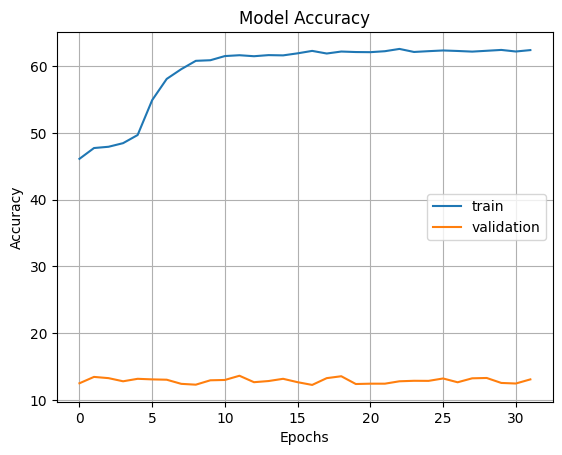

In [14]:
plt.plot(accs_train, label='Train_accuracy')
plt.plot(accs_val, label='Validation_accuracy')
plt.grid()
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

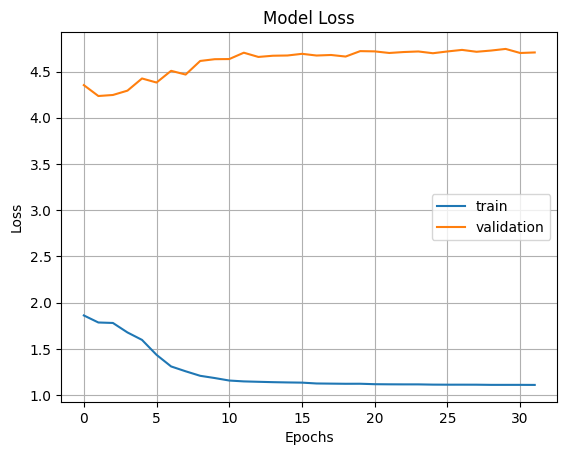

In [15]:
plt.plot(losses_train, label='Train_loss')
plt.plot(losses_val, label='Validation_loss')
plt.grid()
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['train', 'validation'])
plt.show()

In [16]:
#Test
class MyTestSet(Dataset):
    def __init__(self, img):
        self.img = np.load(img)
        self.transforms = transforms.Compose([transforms.ToTensor(), ])
    def __getitem__(self, index):
        img = self.img[index, :, :, :]
        img = np.squeeze(img)
        img = Image.fromarray(np.uint8(img))
        img = self.transforms(img)
        return img
    def __len__(self):
        return self.img.shape[0]

In [17]:
test = MyTestSet("./pretrained_0/test_pre.npy")
test_loader = torch.utils.data.DataLoader(test, batch_size=128, shuffle=False)

In [18]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0,1'
mod =EfficientNet.from_pretrained('efficientnet-b3', num_classes=classes)
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
if torch.cuda.device_count() > 1:
    mod = nn.DataParallel(mod)

torch.cuda.is_available()
torch.cuda.device_count()
torch.cuda.current_device()
torch.cuda.get_device_name()

mod.to(device)
mod = mod.to(device)
mod.load_state_dict(torch.load(("./pretrained_0/checkpoint_model_pre.pth")))
mod.eval()

Loaded pretrained weights for efficientnet-b3


DataParallel(
  (module): EfficientNet(
    (_conv_stem): Conv2dStaticSamePadding(
      3, 40, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          40, 40, kernel_size=(3, 3), stride=[1, 1], groups=40, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(40, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          40, 10, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          10, 40, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePaddi

In [19]:
out = []
for i, data in enumerate(test_loader):
    query = data
    query = query.to(device)
    pred= mod(query)
    _, predicted = torch.max(pred.data, 1)
    out.append(predicted)

pred = torch.cat(out, dim=0)
pr = pred.cpu().numpy()

In [20]:
real_label = pd.read_csv("./pretrained_0/testy_pre.csv", index_col=0)
real_label.value_counts()

celltype_l2      
CD14 Mono            2132
CD4 Naive             874
NK                    859
CD4 TCM               745
CD8 TEM               587
CD8 Naive             539
B naive               385
CD16 Mono             315
CD4 TEM               214
gdT                   183
B memory              164
CD8 TCM               144
MAIT                  139
Treg                  125
cDC2                  123
B intermediate        121
Platelet              114
CD4 CTL                87
NK_CD56bright          47
pDC                    43
Doublet                29
NK Proliferating       27
dnT                    17
Plasmablast            16
HSPC                   16
ILC                     7
cDC1                    7
Eryth                   4
CD8 Proliferating       4
ASDC                    4
CD4 Proliferating       3
dtype: int64

In [21]:
file = open("./pretrained_0/label_encoder_pre.obj",'rb')
le = pickle.load(file)
file.close()
pred_label = le.inverse_transform(pr)
pred_label = pd.DataFrame(pred_label)
pred_label.value_counts()

CD14 Mono         2146
CD4 Naive         1428
NK                1318
B naive           1308
CD4 TCM            616
CD8 TEM            450
CD8 Naive          210
Treg               196
CD4 TEM            160
B memory           148
CD16 Mono           42
CD4 CTL             24
B intermediate      10
MAIT                 6
CD8 TCM              6
Doublet              2
Platelet             2
dnT                  2
dtype: int64

In [22]:
ls = list(set(pd.unique(pred_label[0]).tolist()) | set(pd.unique(real_label["celltype_l2"]).tolist()))
acc = accuracy_score(pred_label,real_label)

le2 = preprocessing.LabelEncoder()
le2.fit(ls)
pred_label_2 = le2.transform(pred_label[0])
real_label_2 = le2.transform(real_label["celltype_l2"])
ari = adjusted_rand_score(real_label_2, pred_label_2)

print("Accuray: %.03f, ARI = %.03f" % (acc, ari))

Accuray: 0.132, ARI = 0.001
